## 线性回归

In [17]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [2]:
# 创建示例数据集
data = {
    "0": [2, 3, 4, 5, 6],
    "X": [1, 2, 3, 4, 5],
    "1": [5, 4, 3, 2, 1],
    "2": [1, 2, 3, 4, 5],
    "Y": [3, 4, 2, 5, 6]
}

# 将数据集转换为 DataFrame
dataset = pd.DataFrame(data)

def Squared_term(dataset, variables):
    for var in variables:
        dataset[f'{var}_squared_term'] = dataset[var] ** 2
    return dataset

def Interaction_term(dataset, variables):
    for i in range(len(variables)):
        for j in range(i + 1, len(variables)):
            dataset[f'{variables[i]}_{variables[j]}'] = dataset[variables[i]] * dataset[variables[j]]
    return dataset

In [3]:
variables = dataset.columns.drop(["X", "Y"]).tolist()
model1_features = ["X"] + variables
d1 = Squared_term(dataset[model1_features], variables)
d1 = Interaction_term(d1, variables)
model1_features = ["X"] + variables + [f'{var}_squared_term' for var in variables]
print(model1_features)
model1_features = d1.columns.tolist()
print(model1_features)

['X', '0', '1', '2', '0_squared_term', '1_squared_term', '2_squared_term']
['X', '0', '1', '2', '0_squared_term', '1_squared_term', '2_squared_term', '0_1', '0_2', '1_2']


In [4]:
scaler = StandardScaler()
d1_scaled = scaler.fit_transform(d1)
model1 = LinearRegression().fit(d1_scaled, dataset[["Y"]])
model1_coefs = model1.coef_[0].tolist()
model1_dict = {name: coef for name, coef in zip(model1_features, model1_coefs)}
print(model1_dict)

{'X': 0.08959372776926722, '0': 0.08959372776926722, '1': -0.0895937277692671, '2': 0.0895937277692671, '0_squared_term': 0.13368279918203282, '1_squared_term': -0.028323816801206637, '2_squared_term': 0.1474778756831382, '0_1': -0.2930171810439319, '0_2': 0.13966211127148917, '1_2': -0.3079290260806433}


In [ ]:
# 将 X 放到第一列
variables.remove("X")
variables = ["X"] + variables

In [5]:
model = LinearRegression().fit(dataset[variables], dataset[["Y"]])
coefs = model.coef_[0].tolist()
names = model.feature_names_in_.tolist()
variables.remove("X")

In [6]:
df = []
for i, variable in enumerate(variables):
    for j, name in enumerate(names):
        if variable == name:
            df.append({
                "variable": variable,
                "v~Y_coefficient": coefs[j],
            })
    
df = pd.DataFrame(df)
df
# df["dataset"] = dataset.name

,variable,v~Y_coefficient
0,0,0.233333
1,1,-0.233333


In [7]:
df["X~Y_coefficient"] = coefs[0]

# # Reorder columns:
# df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

In [8]:
df

,variable,v~Y_coefficient,X~Y_coefficient
0,0,0.233333,0.233333
1,1,-0.233333,0.233333


## 岭回归

In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
import crunch
crunch = crunch.load_notebook()

loaded inline runner with module: <module '__main__'>


In [20]:
X_train, y_train, X_test = crunch.load_data()

download data\X_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_train.pickle (1523944532 bytes)
already exists: file length match
download data\y_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_train.pickle (7017735 bytes)
already exists: file length match
download data\X_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_test_reduced.pickle (122341879 bytes)
already exists: file length match
download data\y_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_test_reduced.pickle (562930 bytes)
already exists: file length match
download data\example_prediction.parquet from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/example_prediction_reduced.parquet (668981 bytes)
already exists: file length match


In [4]:
def ridge_regression_feature(dataset):
    variables = dataset.columns.drop(["X", "Y"]).tolist()
    param_grid = {'alpha': np.logspace(-6, 6, 13)}
    
    # model1: Fit X, v ~ Y
    model1_features = ["X"] + variables
    scaler1 = StandardScaler()
    d1_scaled = scaler1.fit_transform(dataset[model1_features])
    model1 = GridSearchCV(Ridge(random_state=42), param_grid, cv=5)
    model1.fit(d1_scaled, dataset["Y"])
    model1_coefs = model1.best_estimator_.coef_.tolist()
    model1_dict = {name: coef for name, coef in zip(model1_features, model1_coefs)}
    
    # model2: Fit v ~ X
    model2_features = variables
    scaler2 = StandardScaler()
    d2_scaled = scaler2.fit_transform(dataset[model2_features])
    model2 = GridSearchCV(Ridge(random_state=42), param_grid, cv=5)
    model2.fit(d2_scaled, dataset["X"])
    model2_coefs = model2.best_estimator_.coef_.tolist()
    model2_dict = {name: coef for name, coef in zip(model2_features, model2_coefs)}
    
    df = []
    for i, variable in enumerate(variables):
        df.append({
            "variable": variable,
            "v~Y_ridge_coefficient": model1_dict[variable],
            "v~X_ridge_coefficient": model2_dict[variable]
        })
        
    df = pd.DataFrame(df)
    # df["dataset"] = dataset.name
    
    df["X~Y_ridge_coefficient"] = model1_dict["X"]
    
    # Reorder columns:
    # df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    # 获取最优的 alpha 值
    best_alpha_model1 = model1.best_params_['alpha']
    best_alpha_model2 = model2.best_params_['alpha']

    return df, best_alpha_model1, best_alpha_model2

In [5]:
alpha_model1 = []
alpha_model2 = []
from tqdm import tqdm
count = 0

for key, df in tqdm(X_train.items(), total=len(X_train), desc="Processing datasets"):
    df, best_alpha_model1, best_alpha_model2 = ridge_regression_feature(df)
    alpha_model1.append(best_alpha_model1)
    alpha_model2.append(best_alpha_model2)
    count+=1
    if count == 2000:
        break

Processing datasets:   9%|▊         | 1999/23500 [06:01<1:04:48,  5.53it/s]


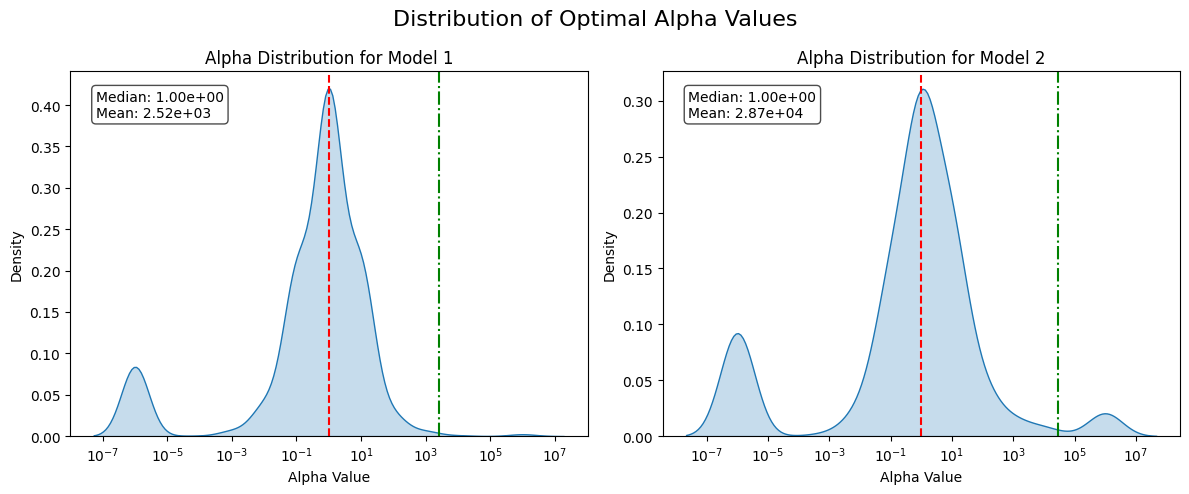

In [6]:
def plot_alpha_distributions(alpha_model1, alpha_model2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Distribution of Optimal Alpha Values', fontsize=16)

    for ax, data, title in zip([ax1, ax2], [alpha_model1, alpha_model2], ['Model 1', 'Model 2']):
        sns.kdeplot(data, ax=ax, log_scale=True, fill=True)
        ax.set_title(f'Alpha Distribution for {title}')
        ax.set_xlabel('Alpha Value')
        ax.set_ylabel('Density')

        # 添加统计信息
        median = np.median(data)
        mean = np.mean(data)
        ax.axvline(median, color='r', linestyle='--', label=f'Median: {median:.2e}')
        ax.axvline(mean, color='g', linestyle='-.', label=f'Mean: {mean:.2e}')
        
        # 添加文本注释
        ax.text(0.05, 0.95, f'Median: {median:.2e}\nMean: {mean:.2e}', 
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    plt.tight_layout()
    plt.show()

# 调用函数
plot_alpha_distributions(alpha_model1, alpha_model2)

## 聚类特征

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import pandas as pd

In [2]:
def enhanced_cluster_features(dataset):
    variables = dataset.columns.drop(["X", "Y"]).tolist()
    scaler = StandardScaler()
    d_scaled = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)

    results = []
    eps_values = [0.3, 0.5, 0.7]
    
    for variable in variables:
        cluster_counts = []
        noise_counts = []
        avg_cluster_sizes = []
        density_variations = []
        feature_importances = []
        silhouette_scores = []
        
        for eps in eps_values:
            cluster_df = d_scaled[[variable, "X", "Y"]].copy()
            dbscan = DBSCAN(eps=eps, min_samples=5)
            cluster_df["cluster"] = dbscan.fit_predict(cluster_df)
            
            # 基本统计
            cluster_count = len(set(cluster_df["cluster"])) - (1 if -1 in cluster_df["cluster"] else 0)
            noise_count = (cluster_df["cluster"] == -1).sum()
            cluster_counts.append(cluster_count)
            noise_counts.append(noise_count)
            
            # 密度分析
            cluster_sizes = cluster_df[cluster_df["cluster"] != -1]["cluster"].value_counts()
            avg_cluster_size = cluster_sizes.mean() if not cluster_sizes.empty else 0
            density_variation = cluster_sizes.std() / avg_cluster_size if avg_cluster_size > 0 else 0
            avg_cluster_sizes.append(avg_cluster_size)
            density_variations.append(density_variation)
            
            # 特征重要性
            if cluster_count > 1:  # 确保有多个簇
                feature_importance = abs(np.corrcoef(cluster_df[variable], cluster_df["cluster"]))[0, 1]
            else:
                feature_importance = 0
            feature_importances.append(feature_importance)
            
            # 轮廓系数
            non_noise_mask = cluster_df["cluster"] != -1
            if len(set(cluster_df.loc[non_noise_mask, "cluster"])) > 1:
                sil_score = silhouette_score(cluster_df.loc[non_noise_mask, [variable, "X", "Y"]], 
                                             cluster_df.loc[non_noise_mask, "cluster"], 
                                             metric="euclidean")
            else:
                sil_score = 0
            silhouette_scores.append(sil_score)
        
        result = {
            "variable": variable
        }
        for i, eps in enumerate(eps_values):
            result.update({
                f"cluster_count_{eps}": cluster_counts[i],
                f"noise_count_{eps}": noise_counts[i],
                f"avg_cluster_size_{eps}": avg_cluster_sizes[i],
                f"density_variation_{eps}": density_variations[i],
                f"feature_importance_{eps}": feature_importances[i],
                f"silhouette_score_{eps}": silhouette_scores[i]
            })
        results.append(result)

    df = pd.DataFrame(results)
    # df["dataset"] = dataset.name

    # # Reorder columns:
    # df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

In [3]:
# 创建示例数据集
data = {
    "0": [2, 3, 4, 5, 6],
    "X": [1, 2, 3, 4, 5],
    "1": [5, 4, 3, 2, 1],
    "2": [1, 2, 3, 4, 5],
    "Y": [3, 4, 2, 5, 6]
}

# 将数据集转换为 DataFrame
dataset = pd.DataFrame(data)
print(dataset)

   0  X  1  2  Y
0  2  1  5  1  3
1  3  2  4  2  4
2  4  3  3  3  2
3  5  4  2  4  5
4  6  5  1  5  6


In [4]:
df = enhanced_cluster_features(dataset)
print(df)

  variable  cluster_count_0.3  noise_count_0.3  avg_cluster_size_0.3  \
0        0                  1                5                     0   
1        1                  1                5                     0   
2        2                  1                5                     0   

   density_variation_0.3  feature_importance_0.3  silhouette_score_0.3  \
0                      0                       0                     0   
1                      0                       0                     0   
2                      0                       0                     0   

   cluster_count_0.5  noise_count_0.5  avg_cluster_size_0.5  \
0                  1                5                     0   
1                  1                5                     0   
2                  1                5                     0   

   density_variation_0.5  feature_importance_0.5  silhouette_score_0.5  \
0                      0                       0                     0   
1            

## PC

In [1]:
import numpy as np
import pandas as pd
from pgmpy.estimators import PC
from pgmpy.independencies import Independencies

In [2]:
import crunch
crunch = crunch.load_notebook()
X_train, y_train, X_test = crunch.load_data()

loaded inline runner with module: <module '__main__'>
download data\X_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_train.pickle (1523944532 bytes)
already exists: file length match
download data\y_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_train.pickle (7017735 bytes)
already exists: file length match
download data\X_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_test_reduced.pickle (122341879 bytes)
already exists: file length match
download data\y_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_test_reduced.pickle (562930 bytes)
already exists: file length match
download data\example_prediction.parquet from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/example_prediction_reduced.parquet (668981 bytes)
already exist

In [3]:
# 数据预处理函数
def preprocess_data(data):
    # 确保数据是浮点型
    data = data.astype(float)
    # 替换无穷大值为NaN
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    # 删除包含NaN的行
    data.dropna(inplace=True)
    return data

def discretize_dataframe(df, n_bins=5, strategy='uniform', labels=None):
    """
    将数据框中的所有连续变量离散化为分箱后的离散变量。

    参数:
    df (pandas.DataFrame): 输入的数据框
    n_bins (int 或 dict): 分箱数量。可以是整数（对所有列使用相同的分箱数），
                          或者是字典（为每列指定不同的分箱数）
    strategy (str 或 dict): 分箱策略，可选 'uniform'（等宽）, 'quantile'（等频）或 'kmeans'
                            可以是字符串（对所有列使用相同的策略），
                            或者是字典（为每列指定不同的策略）
    labels (bool 或 dict): 是否用标签替换分箱的整数。True 使用标签，False 使用整数。
                           可以是布尔值（对所有列使用相同的设置），
                           或者是字典（为每列指定不同的设置）

    返回:
    pandas.DataFrame: 离散化后的数据框
    """
    df_discretized = df.copy()
    
    for column in df.columns:
        if df[column].dtype in ['int64', 'float64']:
            # 获取当前列的参数
            col_bins = n_bins[column] if isinstance(n_bins, dict) else n_bins
            col_strategy = strategy[column] if isinstance(strategy, dict) else strategy
            col_labels = labels[column] if isinstance(labels, dict) else labels
            
            # 处理特殊情况：如果列中的唯一值少于分箱数，就直接使用这些唯一值
            unique_values = df[column].nunique()
            if unique_values <= col_bins:
                df_discretized[column] = pd.Categorical(df[column])
            else:
                # 执行离散化
                if col_strategy == 'uniform':
                    df_discretized[column] = pd.cut(df[column], bins=col_bins, labels=col_labels)
                elif col_strategy == 'quantile':
                    df_discretized[column] = pd.qcut(df[column], q=col_bins, labels=col_labels)
                elif col_strategy == 'kmeans':
                    from sklearn.preprocessing import KBinsDiscretizer
                    kbd = KBinsDiscretizer(n_bins=col_bins, encode='ordinal', strategy='kmeans')
                    df_discretized[column] = kbd.fit_transform(df[[column]])
                    if col_labels:
                        df_discretized[column] = pd.Categorical(df_discretized[column])
                else:
                    raise ValueError(f"不支持的策略 '{col_strategy}' 用于列 '{column}'")
    
    return df_discretized

A = X_train['00016']
A = preprocess_data(A)
# A = discretize_dataframe(A, n_bins=5, strategy='uniform', labels=[1, 2, 3, 4, 5])
B = y_train['00016']
print(A)
print(B)

         0      1      2      Y      4      X
0    0.023 -0.365  0.781  0.255  0.223 -0.367
1    0.177 -0.057 -0.333 -0.165 -0.625  0.759
2    0.393 -0.035 -0.879 -0.565 -0.065  0.243
3   -0.501  0.211 -0.273 -0.377 -0.551  0.345
4    0.119  0.849  0.727 -0.737  0.343 -0.165
..     ...    ...    ...    ...    ...    ...
995 -0.487 -0.805  0.001  0.767  0.357 -0.617
996 -0.521 -0.913 -0.215 -0.031  0.931 -0.929
997 -0.585  0.441 -0.189 -0.581 -0.357  0.449
998 -0.857 -0.643  0.191  0.495  0.405 -0.707
999  0.301  0.659  0.441 -0.489  0.035 -0.005

[1000 rows x 6 columns]
        0  1  2  Y  4  X
parent                  
0       0  0  0  0  0  0
1       0  0  0  1  0  0
2       1  0  0  1  0  0
Y       1  0  0  0  0  0
4       1  1  0  1  0  1
X       1  0  0  1  0  0


In [4]:
# 使用estimate方法学习DAG结构
est = PC(A)
estimated_model = est.estimate(
    variant='parallel',
    ci_test='pearsonr',
    max_cond_vars=3,  # 减少最大条件变量数
    return_type='dag',
    significance_level=0.05,
    n_jobs=-1,  # 使用所有可用的CPU核心
)

# 打印估计的边
print("Estimated edges:")
print(estimated_model.edges())

# 将估计的模型转换为邻接矩阵格式
adj_matrix = np.zeros((6, 6), dtype=int)
for edge in estimated_model.edges():
    i = A.columns.get_loc(edge[0])
    j = A.columns.get_loc(edge[1])
    adj_matrix[i, j] = 1

print("\nEstimated adjacency matrix:")
print(adj_matrix)

# 比较估计的结构与真实结构
true_adj_matrix = y_train['00016'].values

print("\nTrue adjacency matrix:")
print(true_adj_matrix)

# 计算结构学习的准确度
accuracy = np.mean(adj_matrix == true_adj_matrix)
print(f"\nStructure learning accuracy: {accuracy:.2f}")

  0%|          | 0/3 [00:00<?, ?it/s]

INFO:pgmpy:Reached maximum number of allowed conditional variables. Exiting


Estimated edges:
[('X', '0'), ('4', '1'), ('4', '0'), ('4', 'X'), ('2', 'Y')]

Estimated adjacency matrix:
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 0]
 [1 1 0 0 0 1]
 [1 0 0 0 0 0]]

True adjacency matrix:
[[0 0 0 0 0 0]
 [0 0 0 1 0 0]
 [1 0 0 1 0 0]
 [1 0 0 0 0 0]
 [1 1 0 1 0 1]
 [1 0 0 1 0 0]]

Structure learning accuracy: 0.86


In [7]:
import pandas as pd
import numpy as np
from pgmpy.estimators import PC
from tqdm import tqdm

def classify_relationship(edges):
    edge_set = set(edges)
    if ('X', 'Y') not in edge_set:
        return "Invalid (X->Y not found)"
    if (('v', 'X') in edge_set or ('X', 'v') in edge_set) and (('v', 'Y') in edge_set or ('Y', 'v') in edge_set):
        return "Mediator or Confounder"
    if ('X', 'v') in edge_set and ('Y', 'v') in edge_set:
        return "Collider"
    if ('v', 'X') in edge_set:
        return "Cause of X"
    if ('v', 'Y') in edge_set:
        return "Cause of Y"
    if ('X', 'v') in edge_set:
        return "Consequence of X"
    if ('Y', 'v') in edge_set:
        return "Consequence of Y"
    return "Independent"

def print_adjacency_matrix(edges, variables):
    adj_matrix = np.zeros((len(variables), len(variables)), dtype=int)
    for i, v1 in enumerate(variables):
        for j, v2 in enumerate(variables):
            if (v1, v2) in edges:
                adj_matrix[i, j] = 1
    print(pd.DataFrame(adj_matrix, index=variables, columns=variables))

variables = A.columns.drop(["X", "Y"]).tolist()
results = {}
true_relationships = {}

for variable in tqdm(variables, desc="Analyzing variables"):
    # 使用estimate方法学习DAG结构
    data = A[[variable, "X", "Y"]]
    est = PC(data)
    estimated_model = est.estimate(
        variant='parallel',
        ci_test='pearsonr',
        return_type='dag',
        significance_level=0.05,
        n_jobs=-1,
    )

    # 获取估计的边
    estimated_edges = estimated_model.edges()
    
    # 分类关系
    relationship = classify_relationship(estimated_edges)
    results[variable] = relationship

    # 获取真实关系
    true_adj_matrix = y_train['00016'].values
    true_edges = []
    if true_adj_matrix[A.columns.get_loc(variable), A.columns.get_loc("X")] == 1:
        true_edges.append((variable, "X"))
    if true_adj_matrix[A.columns.get_loc(variable), A.columns.get_loc("Y")] == 1:
        true_edges.append((variable, "Y"))
    if true_adj_matrix[A.columns.get_loc("X"), A.columns.get_loc("Y")] == 1:
        true_edges.append(("X", "Y"))
    true_relationship = classify_relationship(true_edges)
    true_relationships[variable] = true_relationship

    # 打印结果和邻接矩阵
    print(f"\nVariable: {variable}")
    print(f"Estimated relationship: {relationship}")
    print(f"True relationship: {true_relationship}")
    
    print("\nEstimated Adjacency Matrix:")
    print_adjacency_matrix(estimated_edges, [variable, "X", "Y"])
    
    print("\nTrue Adjacency Matrix:")
    print_adjacency_matrix(true_edges, [variable, "X", "Y"])

# 计算准确率
accuracy = sum(results[v] == true_relationships[v] for v in variables) / len(variables)
print(f"\nOverall accuracy: {accuracy:.2f}")

# 打印结果汇总
print("\nResults summary:")
for relationship in set(results.values()):
    count = list(results.values()).count(relationship)
    print(f"{relationship}: {count}")

Analyzing variables:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Analyzing variables:  25%|██▌       | 1/4 [00:00<00:00,  7.41it/s]


Variable: 0
Estimated relationship: Independent
True relationship: Independent

Estimated Adjacency Matrix:
   0  X  Y
0  0  1  1
X  0  0  1
Y  0  0  0

True Adjacency Matrix:
   0  X  Y
0  0  0  0
X  0  0  1
Y  0  0  0


  0%|          | 0/5 [00:00<?, ?it/s]

Analyzing variables:  50%|█████     | 2/4 [00:00<00:00,  8.12it/s]


Variable: 1
Estimated relationship: Independent
True relationship: Independent

Estimated Adjacency Matrix:
   1  X  Y
1  0  0  1
X  1  0  1
Y  0  0  0

True Adjacency Matrix:
   1  X  Y
1  0  0  1
X  0  0  1
Y  0  0  0


  0%|          | 0/5 [00:00<?, ?it/s]

Analyzing variables:  75%|███████▌  | 3/4 [00:00<00:00,  8.36it/s]


Variable: 2
Estimated relationship: Independent
True relationship: Independent

Estimated Adjacency Matrix:
   2  X  Y
2  0  0  1
X  0  0  1
Y  0  0  0

True Adjacency Matrix:
   2  X  Y
2  0  0  1
X  0  0  1
Y  0  0  0


  0%|          | 0/5 [00:00<?, ?it/s]


Variable: 4

Analyzing variables: 100%|██████████| 4/4 [00:00<00:00,  8.71it/s]


Estimated relationship: Invalid (X->Y not found)
True relationship: Independent

Estimated Adjacency Matrix:
   4  X  Y
4  0  0  1
X  1  0  0
Y  0  0  0

True Adjacency Matrix:
   4  X  Y
4  0  1  1
X  0  0  1
Y  0  0  0

Overall accuracy: 0.75

Results summary:
Independent: 3
Invalid (X->Y not found): 1


In [ ]:
from pgmpy.estimators import PC, HillClimbSearch
from pgmpy.models import BayesianNetwork
import pandas as pd
import numpy as np

# 假设数据已经准备好，存储在DataFrame中
data = pd.DataFrame(np.random.rand(1000, 3), columns=['v', 'X', 'Y'])

# 使用PC算法
pc = PC(data)
pc_graph = pc.estimate(variant='stable')
print("PC Algorithm Result:")
print(pc_graph.edges())

# 使用Hill-Climb搜索
hc = HillClimbSearch(data)
hc_model = hc.estimate()
print("\nHill-Climb Search Result:")
print(hc_model.edges())

# 将结果映射到预定义的关系类型
def map_to_relationship(edges):
    if ('X', 'Y') not in edges:
        return "Invalid (X->Y not found)"
    if ('v', 'X') in edges and ('v', 'Y') in edges:
        return "Confounder"
    if ('X', 'v') in edges and ('Y', 'v') in edges:
        return "Collider"
    # ... 添加其他关系类型的判断
    return "Unknown"

print("\nInferred Relationship (PC):", map_to_relationship(pc_graph.edges()))
print("Inferred Relationship (HC):", map_to_relationship(hc_model.edges()))

## PC-0926

In [1]:
import numpy as np
import pandas as pd
from pgmpy.estimators import PC
from pgmpy.independencies import Independencies

In [2]:
import crunch
crunch = crunch.load_notebook()
X_train, y_train, X_test = crunch.load_data()

loaded inline runner with module: <module '__main__'>
download data\X_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_train.pickle (1523944532 bytes)
already exists: file length match
download data\y_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_train.pickle (7017735 bytes)
already exists: file length match
download data\X_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_test_reduced.pickle (122341879 bytes)
already exists: file length match
download data\y_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_test_reduced.pickle (562930 bytes)
already exists: file length match
download data\example_prediction.parquet from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/example_prediction_reduced.parquet (668981 bytes)
already exist

In [3]:
def preprocess_data(data):
    # 确保数据是浮点型
    data = data.astype(float)
    # 替换无穷大值为NaN
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    # 删除包含NaN的行
    data.dropna(inplace=True)
    return data

In [4]:
def PC_estimate(dataset, mcv, significance, isprint):
    dim = dataset.shape[1]
    if mcv == 'dim-1':
        mcv = dim - 1
    else:
        mcv = int(mcv)

    # 使用estimate方法学习DAG结构
    est = PC(dataset)
    estimated_model = est.estimate(
        variant='parallel',
        ci_test='pearsonr',
        max_cond_vars=mcv,  # 减少最大条件变量数
        return_type='dag',
        significance_level=significance,
        n_jobs=-1,  # 使用所有可用的CPU核心
    )

    # 打印估计的边
    if isprint:
        print("Estimated edges:")
        print(estimated_model.edges())

    # 将估计的模型转换为邻接矩阵格式
    adj_matrix = np.zeros((dim, dim), dtype=int)
    for edge in estimated_model.edges():
        i = dataset.columns.get_loc(edge[0])
        j = dataset.columns.get_loc(edge[1])
        adj_matrix[i, j] = 1

    # 打印估计的邻接矩阵
    if isprint:
        print("\nEstimated adjacency matrix:")
        print(adj_matrix)

    return adj_matrix

In [44]:
A = X_train['00016']
A = preprocess_data(A)
# A = discretize_dataframe(A, n_bins=5, strategy='uniform', labels=[1, 2, 3, 4, 5])
B = y_train['00016']
print(A.columns)
print(B)

adj_matrix = PC_estimate(A, 4, 0.1, True)
adj_df = pd.DataFrame(adj_matrix, index=A.columns, columns=A.columns)
print(adj_df)

# 比较估计的结构与真实结构
true_adj_matrix = B.values

print("\nTrue adjacency matrix:")
print(true_adj_matrix)

# 计算结构学习的准确度
accuracy = np.mean(adj_matrix == true_adj_matrix)
print(f"\nStructure learning accuracy: {accuracy:.2f}")

Index(['0', '1', '2', 'Y', '4', 'X'], dtype='object')
        0  1  2  Y  4  X
parent                  
0       0  0  0  0  0  0
1       0  0  0  1  0  0
2       1  0  0  1  0  0
Y       1  0  0  0  0  0
4       1  1  0  1  0  1
X       1  0  0  1  0  0


  0%|          | 0/4 [00:00<?, ?it/s]

INFO:pgmpy:Reached maximum number of allowed conditional variables. Exiting


Estimated edges:
[('X', '0'), ('0', 'Y'), ('2', 'Y'), ('2', '0'), ('4', 'X')]

Estimated adjacency matrix:
[[0 0 0 1 0 0]
 [0 0 0 0 0 0]
 [1 0 0 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 1]
 [1 0 0 0 0 0]]
   0  1  2  Y  4  X
0  0  0  0  1  0  0
1  0  0  0  0  0  0
2  1  0  0  1  0  0
Y  0  0  0  0  0  0
4  0  0  0  0  0  1
X  1  0  0  0  0  0

True adjacency matrix:
[[0 0 0 0 0 0]
 [0 0 0 1 0 0]
 [1 0 0 1 0 0]
 [1 0 0 0 0 0]
 [1 1 0 1 0 1]
 [1 0 0 1 0 0]]

Structure learning accuracy: 0.81


In [9]:
A = X_train['00018']
A = preprocess_data(A)
# A = discretize_dataframe(A, n_bins=5, strategy='uniform', labels=[1, 2, 3, 4, 5])
B = y_train['00018']
print(A.shape)

adj_matrix = PC_estimate(A, 3, 0.05, True)

# 比较估计的结构与真实结构
true_adj_matrix = B.values

print("\nTrue adjacency matrix:")
print(true_adj_matrix)

# 计算结构学习的准确度
accuracy = np.mean(adj_matrix == true_adj_matrix)
print(f"\nStructure learning accuracy: {accuracy:.2f}")

(1000, 9)


  0%|          | 0/3 [00:00<?, ?it/s]

INFO:pgmpy:Reached maximum number of allowed conditional variables. Exiting


Estimated edges:
[('4', '6'), ('5', 'Y'), ('Y', '4'), ('7', '6'), ('7', 'Y'), ('X', '5'), ('3', 'X')]

Estimated adjacency matrix:
[[0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1]
 [0 0 0 0 1 0 0 0 0]]

True adjacency matrix:
[[0 0 0 0 0 1 0 0 1]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 1]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0]]

Structure learning accuracy: 0.85


In [25]:
A = X_train['00024']
A = preprocess_data(A)
# A = discretize_dataframe(A, n_bins=5, strategy='uniform', labels=[1, 2, 3, 4, 5])
B = y_train['00024']
print(A.shape)

adj_matrix = PC_estimate(A, '3')

# 比较估计的结构与真实结构
true_adj_matrix = B.values

print("\nTrue adjacency matrix:")
print(true_adj_matrix)

# 计算结构学习的准确度
accuracy = np.mean(adj_matrix == true_adj_matrix)
print(f"\nStructure learning accuracy: {accuracy:.2f}")

(1000, 8)


  0%|          | 0/3 [00:00<?, ?it/s]

INFO:pgmpy:Reached maximum number of allowed conditional variables. Exiting


Estimated edges:
[('6', '3'), ('5', '3'), ('0', '3'), ('Y', '3'), ('Y', '6'), ('X', 'Y'), ('7', '5'), ('1', '0')]

Estimated adjacency matrix:
[[0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 1 0]
 [0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0]]

True adjacency matrix:
[[0 0 0 1 0 0 1 0]
 [1 0 1 0 0 1 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0]]

Structure learning accuracy: 0.94


In [ ]:
def PC_feature(dataset):
    variables = dataset.columns.drop(["X", "Y"]).tolist()

    results = []     # 用于存储每个变量的特征
    PC_result = {}   # 存储不同显著性水平下的PC算法结果
    significance = [0.01, 0.05, 0.1]  # 显著性水平列表
    
    for sig in significance:
        adj_matrix = PC_estimate(dataset, 3, sig, False)
        adj_df = pd.DataFrame(adj_matrix, index=dataset.columns, columns=dataset.columns)
        PC_result[sig] = adj_df

    df = []
    for variable in variables:
        result = {
            "variable": variable
        }
        for sig in significance:
            adj_df = PC_result[sig]

            # 检查变量与'X'和'Y'之间的边
            v_to_X = adj_df.loc[variable, 'X']
            X_to_v = adj_df.loc['X', variable]
            v_to_Y = adj_df.loc[variable, 'Y']
            Y_to_v = adj_df.loc['Y', variable]

            # 将结果添加到特征字典中
            result.update({
                f"v~X_PC_{sig}": v_to_X,
                f"X~v_PC_{sig}": X_to_v,
                f"v~Y_PC_{sig}": v_to_Y,
                f"Y~v_PC_{sig}": Y_to_v
            })
        results.append(result)

    df = pd.DataFrame(results)
    df["dataset"] = dataset.name

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

In [ ]:
X_y_group_train_copy = X_y_group_train.copy()

In [ ]:
X_y_group_train = X_y_group_train_copy.copy()
print(X_y_group_train.shape)
X_y_group_train = X_y_group_train.drop(columns=[
     'v~X_PC_0.01', 'X~v_PC_0.01', 'v~Y_PC_0.01', 'Y~v_PC_0.01', 'X~Y_PC_0.01',
     # 'v~X_PC_0.05', 'X~v_PC_0.05', 'v~Y_PC_0.05', 'Y~v_PC_0.05', 'X~Y_PC_0.05', 
     # 'v~X_PC_0.1', 'X~v_PC_0.1', 'v~Y_PC_0.1', 'Y~v_PC_0.1', 'X~Y_PC_0.1'
])
print(X_y_group_train.shape)

## DML

In [1]:
import pandas as pd
import numpy as np

In [2]:
X_train = pd.read_pickle('./data/X_train.pickle')
y_train = pd.read_pickle('./data/y_train.pickle')

A = X_train['00018']
print(A.columns)
B = y_train['00018']

Index(['X', '1', '2', '3', '4', '5', '6', '7', 'Y'], dtype='object')


In [9]:
from econml.dml import CausalForestDML, LinearDML
from sklearn.linear_model import LassoCV

# 设置处理变量、结果变量和控制变量
T_ = '1'
Y_ = 'X'
X_ = ['2', '3', '4', '5', '6', '7', 'Y']
data = A.copy()

T = data[T_].values
Y = data[Y_].values
X = data[X_].values

# # 定义 LassoCV 作为第一阶段模型
# model_t = LassoCV(random_state=42, n_jobs=None)
# model_y = LassoCV(random_state=42, n_jobs=None)

model_t = "forest"
model_y = "forest"

# 初始化 CausalForestDML 使用自定义的估计器
model = CausalForestDML(model_t=model_t, model_y=model_y,
    cv=4, n_estimators=36, n_jobs=None, random_state=42, inference=True)

# # 初始化 LinearDML 使用自定义的估计器
# model = LinearDML(model_t=model_t, model_y=model_y, cv=4, random_state=42)

model.fit(Y, T, X=X)

In [10]:
# 平均边际处理效应的推断结果
amte_inference = model.ate_inference(X=X)
print(amte_inference.summary())
print(amte_inference.mean_point)
print(amte_inference.pvalue())
print(amte_inference.std_point)
print(amte_inference.stderr_point)

               Uncertainty of Mean Point Estimate              
mean_point stderr_mean zstat pvalue ci_mean_lower ci_mean_upper
---------------------------------------------------------------
     0.001        0.03 0.042  0.966        -0.058          0.06
      Distribution of Point Estimate     
std_point pct_point_lower pct_point_upper
-----------------------------------------
    0.019          -0.033           0.039
     Total Variance of Point Estimate     
stderr_point ci_point_lower ci_point_upper
------------------------------------------
       0.035         -0.069          0.073
------------------------------------------

Note: The stderr_mean is a conservative upper bound.
0.0012724049502857565
0.9663466719115306
0.018725126616904446
0.035498740393624


In [11]:
# 条件平均处理效应的推断结果
cate_inference = model.effect_inference(X=X)
print(cate_inference.summary_frame())

     point_estimate  stderr  zstat  pvalue  ci_lower  ci_upper
X                                                             
0             0.002   0.036  0.045   0.964    -0.068     0.071
1            -0.007   0.026 -0.278   0.781    -0.059     0.044
2            -0.017   0.029 -0.569   0.570    -0.074     0.041
3             0.008   0.038  0.210   0.833    -0.066     0.082
4            -0.005   0.029 -0.156   0.876    -0.062     0.053
..              ...     ...    ...     ...       ...       ...
995           0.000   0.019  0.010   0.992    -0.037     0.038
996          -0.001   0.032 -0.017   0.986    -0.063     0.062
997           0.031   0.028  1.115   0.265    -0.023     0.085
998           0.003   0.029  0.116   0.908    -0.054     0.060
999          -0.012   0.022 -0.532   0.595    -0.054     0.031

[1000 rows x 6 columns]


In [12]:
# 边际处理效果
mate_inference = model.marginal_ate_inference(T=T, X=X)
print(mate_inference.summary())

               Uncertainty of Mean Point Estimate              
mean_point stderr_mean zstat pvalue ci_mean_lower ci_mean_upper
---------------------------------------------------------------
     0.001        0.03 0.042  0.966        -0.058          0.06
      Distribution of Point Estimate     
std_point pct_point_lower pct_point_upper
-----------------------------------------
    0.019          -0.033           0.039
     Total Variance of Point Estimate     
stderr_point ci_point_lower ci_point_upper
------------------------------------------
       0.035         -0.069          0.073
------------------------------------------

Note: The stderr_mean is a conservative upper bound.


In [13]:
# 常数边际处理效果
cmate_inference = model.const_marginal_ate_inference(X=X)
print(cmate_inference.summary())

               Uncertainty of Mean Point Estimate              
mean_point stderr_mean zstat pvalue ci_mean_lower ci_mean_upper
---------------------------------------------------------------
     0.001        0.03 0.042  0.966        -0.058          0.06
      Distribution of Point Estimate     
std_point pct_point_lower pct_point_upper
-----------------------------------------
    0.019          -0.033           0.039
     Total Variance of Point Estimate     
stderr_point ci_point_lower ci_point_upper
------------------------------------------
       0.035         -0.069          0.073
------------------------------------------

Note: The stderr_mean is a conservative upper bound.


## Independence test

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
import crunch
crunch = crunch.load_notebook()
X_train, y_train, X_test = crunch.load_data()

loaded inline runner with module: <module '__main__'>
download data\X_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_train.pickle (1523944532 bytes)
already exists: file length match
download data\y_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_train.pickle (7017735 bytes)
already exists: file length match
download data\X_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_test_reduced.pickle (122341879 bytes)
already exists: file length match
download data\y_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_test_reduced.pickle (562930 bytes)
already exists: file length match
download data\example_prediction.parquet from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/example_prediction_reduced.parquet (668981 bytes)
already exist

In [4]:
# Example usage
A = X_train['00000']
A = A.values
B = y_train['00000']
print(A)
print(B)
X = 8   # '8'
Y = 9   # 'X'
Z = [0, 2, 3, 4, 5, 6, 7]  # 不含'Y'

[[ 0.311 -0.365  0.327 ...  0.183  0.515  0.951]
 [ 0.125  0.657 -0.097 ...  0.711  0.591 -0.515]
 [ 0.499 -0.307 -0.395 ...  0.015  0.267  0.109]
 ...
 [ 0.795  0.409 -0.629 ...  0.355  0.941  0.363]
 [ 0.855 -0.721  0.193 ... -0.007 -0.329  0.715]
 [-0.851 -0.395 -0.925 ... -0.773 -0.691  0.001]]
        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0  0  0  0  0  0  0  0  0
Y       1  0  0  0  0  0  0  0  0  0
2       0  0  0  0  0  1  0  0  0  0
3       0  1  0  0  0  1  0  0  0  0
4       0  1  0  0  0  1  0  0  0  0
5       1  1  0  0  0  0  0  0  0  0
6       0  1  0  0  0  1  0  0  0  0
7       0  1  0  0  0  1  0  0  0  0
8       0  0  1  1  0  0  0  1  0  1
X       0  1  0  0  0  1  0  0  0  0


In [5]:
from causallearn.utils.cit import CIT
# 使用高斯核，自动估计带宽
kci_gaussian = CIT(
    A, 
    "kci",
    kernelX='Gaussian', 
    kernelY='Gaussian', 
    kernelZ='Gaussian',
    est_width='empirical'
)

In [6]:
# 计算p值
pValue = kci_gaussian(X, Y, Z)
print("p-value:", pValue)

p-value: 0.0005533800093291408


In [7]:
from causallearn.utils.cit import CIT
# 使用多项式核，次数为3，常数项为1.0
kci_polynomial = CIT(
    A, 
    "kci",
    kernelX='Polynomial', 
    kernelY='Polynomial', 
    kernelZ='Polynomial',
    polyd=2,
    c=1.0
)

In [8]:
# 计算p值
pValue = kci_polynomial(X, Y, Z)
print("p-value:", pValue)

p-value: 0.00015758140856281244


In [9]:
from causallearn.utils.cit import CIT
# 使用线性核
kci_linear = CIT(
    A, 
    "kci",
    kernelX='Linear', 
    kernelY='Linear', 
    kernelZ='Linear'
)

In [10]:
# 计算p值
pValue = kci_linear(X, Y, Z)
print("p-value:", pValue)

p-value: 1.5863954662576063e-05


## Causal-learn

In [23]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [24]:
def handle_multicollinearity(data, epsilon=1e-7, corr_threshold=0.99):
    """
    检查数据中的多重共线性，并在需要时向存在多重共线性的列添加随机扰动。
    
    参数:
    - data (np.ndarray): 输入的数据矩阵，形状为 (样本数, 特征数)。
    - epsilon (float): 添加的随机扰动的尺度，默认值为1e-10。
    - corr_threshold (float): 判断高相关性的阈值，默认值为0.95。
    
    返回:
    - data (np.ndarray): 处理后的数据矩阵。
    """
    # 计算相关系数矩阵
    corr_matrix = np.corrcoef(data, rowvar=False)
    n_cols = corr_matrix.shape[0]

    # 使用集合存储所有涉及多重共线性的列索引，避免重复
    high_corr_indices = set()
    
    # 遍历相关系数矩阵的上三角部分，寻找高相关的列对
    for i in range(n_cols):
        for j in range(i+1, n_cols):
            if np.abs(corr_matrix[i, j]) > corr_threshold:
                high_corr_indices.add(i)
                high_corr_indices.add(j)
    
    if high_corr_indices:
        sorted_indices = sorted(high_corr_indices)
        # print(f"检测到多重共线性，涉及的列索引: {sorted_indices}。正在添加随机扰动...")
        
        # 生成与高相关性列对应的随机扰动
        noise = np.random.normal(0, epsilon, (data.shape[0], len(sorted_indices)))
        
        # 将扰动添加到相应的列
        data[:, sorted_indices] += noise
    
    return data

def convert_bidirectional_to_dag(bidirectional_adj: pd.DataFrame) -> pd.DataFrame:
    """
    将双向编码的邻接矩阵转换为单向编码的邻接矩阵（DAG表示）。
    
    在双向编码的邻接矩阵中：
    - [j, i] = 1 且 [i, j] = -1 表示 i → j
    - [j, i] = 1 且 [i, j] = 1 表示 i ↔ j（互为因果）
    - 其他情况 [i, j] = 0 表示无边
    
    转换后，单向编码的邻接矩阵将：
    - [i, j] = 1 表示 i → j
    - [i, j] = 1 且 [j, i] = 1 表示 i ↔ j
    - [i, j] = 0 表示无边
    
    参数:
    - bidirectional_adj (pd.DataFrame): 双向编码的邻接矩阵，使用 1 和 -1 表示有向边。
    
    返回:
    - pd.DataFrame: 单向编码的邻接矩阵（DAG表示）。
    """
    # 确保输入是一个方阵
    if bidirectional_adj.shape[0] != bidirectional_adj.shape[1]:
        raise ValueError("输入的邻接矩阵必须是方阵（行数等于列数）。")
    
    # 确保行列索引一致
    if not bidirectional_adj.index.equals(bidirectional_adj.columns):
        raise ValueError("邻接矩阵的行索引和列索引必须相同。")
    
    # 初始化一个全零的邻接矩阵
    single_direction_adj = pd.DataFrame(0, index=bidirectional_adj.index, columns=bidirectional_adj.columns)
    
    # 遍历每一对变量，确定有向边
    for source in bidirectional_adj.columns:
        for target in bidirectional_adj.index:
            if source == target:
                # 根据DAG定义，通常不允许自环，因此设置为0
                single_direction_adj.at[source, target] = 0
                continue
            
            # 检查双向编码的邻接矩阵来确定有向边
            if bidirectional_adj.at[target, source] == 1:
                if bidirectional_adj.at[source, target] == -1:
                    # 表示 source → target
                    single_direction_adj.at[source, target] = 1
                elif bidirectional_adj.at[source, target] == 1:
                    # 表示 source ↔ target（互为因果）
                    single_direction_adj.at[source, target] = 1
                    single_direction_adj.at[target, source] = 1
                # 如果 [source, target] == 0 或其他情况，不设置边
    return single_direction_adj

def convert_dag_with_strength_to_dag(adj: pd.DataFrame) -> pd.DataFrame:
    """
    将表示因果影响强度的邻接矩阵数据框转换为二元邻接矩阵数据框。
    无论存在正向影响还是负向影响，都将其转换为1；不存在影响则为0。
    
    参数:
    - adj (pd.DataFrame): 原始的因果影响强度邻接矩阵，元素可以是正数、负数或0。
    
    返回:
    - pd.DataFrame: 二元邻接矩阵，元素为0或1。
    """
    # 确保输入是一个方阵
    if adj.shape[0] != adj.shape[1]:
        raise ValueError("输入的邻接矩阵必须是方阵（行数等于列数）。")
    
    # 确保行列索引一致
    if not adj.index.equals(adj.columns):
        raise ValueError("邻接矩阵的行索引和列索引必须相同。")
    
    # 将所有非零元素转换为1，零元素保持为0
    return adj.ne(0).astype(int)

def has_directed_edge(adj, source, target):
    """
    判断DAG邻接矩阵中是否存在从source到target的有向边。
    根据用户的邻接矩阵表示：
    - [source, target] = 1 表示 source -> target
    """
    return adj.at[source, target] == 1

def evaluate_causal_discovery(estimate_adj, true_adj, focus_vars=['X', 'Y']):
    """
    评估因果发现算法的效果，关注变量与指定focus_vars（默认是'X'和'Y'）之间的连接正确率。
    
    参数:
    - estimate_adj (pd.DataFrame): 因果发现算法输出的邻接矩阵。
    - true_adj (pd.DataFrame): 真实的因果关系邻接矩阵。
    - focus_vars (list): 需要关注的变量列表，默认 ['X', 'Y']。
    
    返回:
    - dict: 包含正确率相关信息的字典。
    """
    
    # 1. 验证邻接矩阵的形状和索引/列名是否一致
    if not (estimate_adj.index.equals(true_adj.index) and estimate_adj.columns.equals(true_adj.columns)):
        raise ValueError("estimate_adj 和 true_adj 必须具有相同的行索引和列名。")
    
    all_vars = list(estimate_adj.columns)
    
    # 2. 验证focus_vars是否在邻接矩阵中
    for var in focus_vars:
        if var not in all_vars:
            raise ValueError(f"关注变量 '{var}' 不存在于邻接矩阵中。")
    
    # 3. 确定其他变量
    other_vars = [v for v in all_vars if v not in focus_vars]
    
    # 4. 构建需要检查的连接对
    connections_to_check = []
    
    for ov in other_vars:
        for fv in focus_vars:
            if ov != fv:
                connections_to_check.append( (ov, fv) )  # ov -> fv
                connections_to_check.append( (fv, ov) )  # fv -> ov
    
    # 5. 初始化计数器
    correct = 0
    total = 0
    
    # 6. 遍历每个连接对，比较估计结果与真实数据
    for (source, target) in connections_to_check:
        est_edge = has_directed_edge(estimate_adj, source, target)
        true_edge = has_directed_edge(true_adj, source, target)
        
        if est_edge == true_edge:
            correct += 1
        total += 1
    
    # 7. 计算正确率
    accuracy = correct / total if total > 0 else 0
    accuracy_percentage = accuracy * 100
    
    # 8. 计算每个其他变量与 focus_vars 的四种连接关系是否全部正确
    strict_correct_count = 0
    for ov in other_vars:
        all_correct = True  # 假设该变量的所有连接都正确
        
        for fv in focus_vars:
            if ov != fv:
                # 检查 ov -> fv
                est_edge = has_directed_edge(estimate_adj, ov, fv)
                true_edge = has_directed_edge(true_adj, ov, fv)
                if est_edge != true_edge:
                    all_correct = False
                    break  # 提前退出，不需要继续检查
                
                # 检查 fv -> ov
                est_edge = has_directed_edge(estimate_adj, fv, ov)
                true_edge = has_directed_edge(true_adj, fv, ov)
                if est_edge != true_edge:
                    all_correct = False
                    break  # 提前退出，不需要继续检查
        
        if all_correct:
            strict_correct_count += 1
    
    # 9. 计算严格正确率（所有四种连接均正确的 other_vars 比例）
    strict_accuracy = strict_correct_count / len(other_vars) if other_vars else 0
    strict_accuracy_percentage = strict_accuracy * 100

    # 10. 返回结果
    return {
        'dimension': len(all_vars),
        'correct_connections': correct,
        'total_connections': total,
        'accuracy': accuracy,
        'accuracy_percentage': accuracy_percentage,
        'strict_accuracy': strict_accuracy,
        'strict_accuracy_percentage': strict_accuracy_percentage
    }

def plot_average_accuracy(evaluation_results, name):
    """
    绘制不同维度数据集的平均准确率和严格准确率柱状图。

    每个维度展示两个柱状图：分别是accuracy_percentage的均值和strict_accuracy_percentage的均值。

    参数:
    - evaluation_results (dict): 包含每个数据集评估结果的字典。
                                  e.g., {'dataset1': {...}, 'dataset2': {...}, ...}
    """
    # 将评估结果转换为DataFrame
    df = pd.DataFrame.from_dict(evaluation_results, orient='index')

    # 检查必要的列是否存在
    required_columns = {'dimension', 'accuracy_percentage', 'strict_accuracy_percentage'}
    if not required_columns.issubset(df.columns):
        missing = required_columns - set(df.columns)
        raise ValueError(f"缺少必要的列: {missing}")

    # 按维度分组，计算每个维度的平均 accuracy_percentage 和 strict_accuracy_percentage
    avg_metrics = df.groupby('dimension')[['accuracy_percentage', 'strict_accuracy_percentage']].mean().reset_index()

    # 排序维度以便更清晰的展示
    avg_metrics = avg_metrics.sort_values('dimension')

    # 设置柱状图的位置
    x = np.arange(len(avg_metrics))  # 维度的数量
    width = 0.35  # 每个柱状图的宽度

    # 绘制柱状图
    plt.figure(figsize=(12, 8))
    plt.bar(x - width/2, avg_metrics['accuracy_percentage'], width, label='Accuracy Percentage', color='skyblue')
    plt.bar(x + width/2, avg_metrics['strict_accuracy_percentage'], width, label='Strict Accuracy Percentage', color='salmon')

    # 添加标签和标题
    plt.xlabel('Number of Variables', fontsize=14)
    plt.ylabel('Average Accuracy (%)', fontsize=14)
    plt.title(f'{name} - Average Accuracy and Strict Accuracy for Datasets of Different Dimensions', fontsize=16)
    plt.xticks(x, avg_metrics['dimension'].astype(int), fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(0, 100)

    # 添加图例
    plt.legend(fontsize=12, loc='upper left')

    # 添加数据标签（可选）
    for i in range(len(avg_metrics)):
        plt.text(x[i] - width/2, avg_metrics['accuracy_percentage'].iloc[i] + 1, 
                 f"{avg_metrics['accuracy_percentage'].iloc[i]:.1f}%", ha='center', va='bottom', fontsize=10)
        plt.text(x[i] + width/2, avg_metrics['strict_accuracy_percentage'].iloc[i] + 1, 
                 f"{avg_metrics['strict_accuracy_percentage'].iloc[i]:.1f}%", ha='center', va='bottom', fontsize=10)

    # 优化布局
    plt.tight_layout()
    plt.show()

In [25]:
import crunch
crunch = crunch.load_notebook()
X_train, y_train, X_test = crunch.load_data()

loaded inline runner with module: <module '__main__'>
download data\X_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_train.pickle (1523944532 bytes)
already exists: file length match
download data\y_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_train.pickle (7017735 bytes)
already exists: file length match
download data\X_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_test_reduced.pickle (122341879 bytes)
already exists: file length match
download data\y_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_test_reduced.pickle (562930 bytes)
already exists: file length match
download data\example_prediction.parquet from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/example_prediction_reduced.parquet (668981 bytes)
already exist

### Constrain-based causal discovery

In [26]:
from causallearn.graph.GraphNode import GraphNode
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from causallearn.utils.GraphUtils import GraphUtils

#### PC

In [27]:
def Squared_col(dataset, variables):
    for var in variables:
        dataset[var] = dataset[var] ** 2
    return dataset

def Cos_col(dataset, variables):
    for var in variables:
        dataset[var] = np.cos(dataset[var])
    return dataset

def Sin_col(dataset, variables):
    for var in variables:
        dataset[var] = np.sin(dataset[var])
    return dataset

def merge_dags(dag_dfs):
    if not dag_dfs:
        return pd.DataFrame()  # 如果列表为空，返回一个空的 DataFrame
    
    # 初始化一个与输入的 DataFrame 形状相同的全零 DataFrame
    merged_dag = pd.DataFrame(0, index=dag_dfs[0].index, columns=dag_dfs[0].columns)
    
    # 遍历每个 DAG 数据框，进行逻辑或操作
    for dag_df in dag_dfs:
        merged_dag |= dag_df  # 使用位运算符进行逻辑或操作
        
    return merged_dag

In [21]:
from causallearn.search.ConstraintBased.PC import pc

def PC_estimate(dataset, alpha=0.05, indep_test='fisherz', kernel=None, stable=True, 
               uc_rule=0, uc_priority=2, verbose=False, show_progress=False):
    """
    使用PC算法进行因果发现，并应用先验知识。

    参数:
    - dataset (pd.DataFrame): 输入的数据框，包含'X'、'Y'和其他协变量。
    - alpha (float): 显著性水平，默认值为0.05。
    - indep_test (str): 独立性检验方法，默认值为'fisherz'。
    - kernel (str): 核函数类型，默认值为'linear'。
    - stable (bool): 是否运行稳定的骨架发现，默认值为True。
    - uc_rule (int): 未屏蔽碰撞点的定向规则，默认值为0。
    - uc_priority (int): 解决未屏蔽碰撞点冲突的优先规则，默认值为2。
    - verbose (bool): 是否打印详细输出，默认值为False。
    - show_progress (bool): 是否显示算法进度，默认值为False。

    返回:
    - adj_df (pd.DataFrame): 因果图的邻接矩阵，格式为pivot_table。
    """
    
    # 1. 将数据框转换为numpy.ndarray
    data = dataset.values

    # 检验相关系数是否奇异，如果存在多重共线性，对存在多重共线性的变量添加随机扰动
    data = handle_multicollinearity(data)
    
    # 2. 定义先验知识：'X' → 'Y'
    # 创建GraphNode对象
    try:
        node_X = GraphNode('X')
        node_Y = GraphNode('Y')
    except Exception as e:
        raise ValueError("确保数据框中包含名为'X'和'Y'的列。") from e
    
    # 初始化BackgroundKnowledge对象并添加先验知识
    bk = BackgroundKnowledge().add_required_by_node(node_X, node_Y)

    # 3. 配置核参数
    if indep_test == 'kci':
        if kernel is None:
            kernel = 'linear'
        if kernel == 'linear':
            kernel_kwargs = {
                'kernelX': 'Linear', 
                'kernelY': 'Linear', 
                'kernelZ': 'Linear', 
                'approx': True,           # 使用伽玛近似
                'nullss': 1000,          # 原假设下模拟的样本量
            }
        elif kernel == 'polynomial':
            kernel_kwargs = {
                'kernelX': 'Polynomial', 
                'kernelY': 'Polynomial', 
                'kernelZ': 'Polynomial', 
                'polyd': 3,               # 多项式次数设置为3
                'approx': True,           # 使用伽玛近似
                'nullss': 1000,          # 原假设下模拟的样本量
            }
        elif kernel == 'gaussian':
            kernel_kwargs = {
                'kernelX': 'Gaussian', 
                'kernelY': 'Gaussian', 
                'kernelZ': 'Gaussian', 
                'est_width': 'empirical', # 使用经验宽度
                'approx': True,           # 使用伽玛近似
                'nullss': 1000,          # 原假设下模拟的样本量
            }
        elif kernel == 'mix':
            kernel_kwargs = {
                'kernelX': 'Polynomial', 
                'kernelY': 'Polynomial', 
                'kernelZ': 'Gaussian',     # Z使用高斯核
                'polyd': 3,                # 多项式次数设置为3
                'est_width': 'median',     # Z的高斯核带宽使用中位数技巧
                'approx': True,            # 使用伽玛近似
                'nullss': 1000,           # 原假设下模拟的样本量
            }
        else:
            raise ValueError(f'Unknown kernel: {kernel}')
    else:
        kernel_kwargs = {}

    # 4. 运行PC算法，传入先验知识
    cg = pc(data, 
            alpha=alpha, 
            indep_test=indep_test, 
            stable=stable, 
            uc_rule=uc_rule, 
            uc_priority=uc_priority, 
            background_knowledge=bk, 
            verbose=verbose, 
            show_progress=show_progress,
            **kernel_kwargs
    )
    
    # 5. 提取邻接矩阵
    adj_matrix = cg.G.graph
    
    # 6. 将邻接矩阵转换为pandas DataFrame，并设置行列索引为原数据框的列名
    adj_df = pd.DataFrame(adj_matrix, index=dataset.columns, columns=dataset.columns)
    
    return adj_df

def evaluate_pc_on_datasets(X_train, y_train, num=None, merge=False):
    """
    遍历多个数据集，评估PC算法的效果。

    参数:
    - X_train (dict): 输入的训练数据集，键为数据集名称，值为pd.DataFrame。
    - y_train (dict): 真实因果关系的邻接矩阵，键为数据集名称，值为pd.DataFrame。
    - num (int, optional): 要评估的数据集数量，默认遍历全部。

    返回:
    - evaluation_results (dict): 包含每个数据集评估结果的字典。
    """
    evaluation_results = {}
    
    # 获取所有数据集的键
    dataset_keys = list(X_train.keys())
    
    # 如果num未指定，遍历所有
    if num is None:
        num = len(dataset_keys)
    else:
        num = min(num, len(dataset_keys))
    
    # 使用tqdm添加进度条
    for key in tqdm(dataset_keys[:num], desc="Evaluating PC Algorithm", unit="dataset"):
        dataset = X_train[key]
        true_adj_df_dag = y_train[key]
        if merge == True:
            variables = dataset.columns.drop(["X", "Y"]).tolist()
            Raw_dataset = dataset.copy()
            Squared_dataset = Squared_col(dataset, variables)
            Cos_dataset = Cos_col(dataset, variables)
            Sin_dataset = Sin_col(dataset, variables)
            datasets = [Raw_dataset, Squared_dataset, Cos_dataset, Sin_dataset]
            estimate_adj_df_dags = [convert_bidirectional_to_dag(PC_estimate(d)) for d in datasets]
            estimate_adj_df_dag = merge_dags(estimate_adj_df_dags)
        else:
            estimate_adj_df_bidirectional = PC_estimate(dataset)  # 双向的估计因果图
            estimate_adj_df_dag = convert_bidirectional_to_dag(estimate_adj_df_bidirectional)  # 将双向图转换为有向图
        evaluation_result = evaluate_causal_discovery(estimate_adj_df_dag, true_adj_df_dag, focus_vars=['X', 'Y'])
        evaluation_results[key] = evaluation_result
    
    return evaluation_results

In [14]:
# Example usage
A = X_train['00000'].copy()
B = y_train['00000'].copy()
# print(A)
# print(B)
C = PC_estimate(A, alpha=0.05, indep_test='fisherz')
# print(C)
D1 = convert_bidirectional_to_dag(C)
print(D1)

   0  Y  2  3  4  5  6  7  8  X
0  0  0  0  0  0  1  0  0  0  0
Y  0  0  0  0  0  0  0  0  0  0
2  0  0  0  0  0  0  0  0  0  0
3  1  0  0  0  0  1  0  0  0  0
4  0  0  0  0  0  0  0  0  0  0
5  0  1  0  0  0  0  0  0  0  0
6  1  1  0  0  0  0  0  0  0  0
7  0  1  0  0  0  1  0  0  0  0
8  0  1  0  0  0  0  0  0  0  0
X  0  1  0  0  0  0  0  0  0  0


In [15]:
# Example usage
A = X_train['00000'].copy()
variables = A.columns.drop(["X", "Y"]).tolist()
A = Squared_col(A, variables)
B = y_train['00000'].copy()
# print(A)
# print(B)
C = PC_estimate(A, alpha=0.05, indep_test='fisherz')
# print(C)
D2 = convert_bidirectional_to_dag(C)
print(D2)

   0  Y  2  3  4  5  6  7  8  X
0  0  0  0  0  0  0  0  0  0  0
Y  0  0  0  0  0  0  0  0  0  0
2  0  0  0  0  0  0  0  0  0  0
3  0  0  0  0  0  1  0  0  1  0
4  0  0  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0  0
6  1  0  0  0  0  1  0  0  0  0
7  0  1  0  0  0  0  0  0  1  0
8  0  0  0  0  0  0  0  0  0  0
X  0  1  0  0  0  0  0  0  1  0


In [16]:
# Example usage
A = X_train['00000'].copy()
variables = A.columns.drop(["X", "Y"]).tolist()
A = Cos_col(A, variables)
B = y_train['00000'].copy()
# print(A)
# print(B)
C = PC_estimate(A, alpha=0.05, indep_test='fisherz')
# print(C)
D3 = convert_bidirectional_to_dag(C)
print(D3)

   0  Y  2  3  4  5  6  7  8  X
0  0  0  0  0  0  0  0  0  0  0
Y  0  0  0  0  0  0  0  0  0  0
2  0  0  0  0  0  0  0  0  0  0
3  1  0  0  0  0  1  0  0  1  0
4  0  0  0  0  0  0  0  0  0  0
5  0  0  0  0  0  0  0  0  0  0
6  1  0  0  0  0  1  0  0  0  0
7  0  1  0  0  0  0  0  0  1  0
8  0  0  0  0  0  0  0  0  0  0
X  0  1  0  0  0  0  0  0  1  0


In [17]:
# Example usage
A = X_train['00000'].copy()
variables = A.columns.drop(["X", "Y"]).tolist()
A = Sin_col(A, variables)
B = y_train['00000'].copy()
# print(A)
# print(B)
C = PC_estimate(A, alpha=0.05, indep_test='fisherz')
# print(C)
D4 = convert_bidirectional_to_dag(C)
print(D4)

   0  Y  2  3  4  5  6  7  8  X
0  0  0  0  0  0  1  0  0  0  0
Y  0  0  0  0  0  0  0  0  0  0
2  0  0  0  0  0  0  0  0  0  0
3  1  0  0  0  0  1  0  0  0  0
4  0  0  0  0  0  0  0  0  0  0
5  0  1  0  0  0  0  0  0  0  0
6  1  1  0  0  0  0  0  0  0  0
7  0  1  0  0  0  1  0  0  0  0
8  0  1  0  0  0  0  0  0  0  0
X  0  1  0  0  0  0  0  0  0  0


In [18]:
# Example Megre
B = y_train['00000'].copy()
print(B)
Ds = [D1, D2, D3, D4]
D = merge_dags(Ds)
print(D)

        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0  0  0  0  0  0  0  0  0
Y       1  0  0  0  0  0  0  0  0  0
2       0  0  0  0  0  1  0  0  0  0
3       0  1  0  0  0  1  0  0  0  0
4       0  1  0  0  0  1  0  0  0  0
5       1  1  0  0  0  0  0  0  0  0
6       0  1  0  0  0  1  0  0  0  0
7       0  1  0  0  0  1  0  0  0  0
8       0  0  1  1  0  0  0  1  0  1
X       0  1  0  0  0  1  0  0  0  0
   0  Y  2  3  4  5  6  7  8  X
0  0  0  0  0  0  1  0  0  0  0
Y  0  0  0  0  0  0  0  0  0  0
2  0  0  0  0  0  0  0  0  0  0
3  1  0  0  0  0  1  0  0  1  0
4  0  0  0  0  0  0  0  0  0  0
5  1  1  0  0  0  0  0  0  0  0
6  1  1  0  0  0  1  0  0  0  0
7  0  1  0  0  0  1  0  0  1  0
8  0  1  0  0  0  0  0  0  0  0
X  0  1  0  0  0  0  0  0  1  0


Evaluating PC Algorithm: 100%|██████████| 1000/1000 [01:00<00:00, 16.48dataset/s]


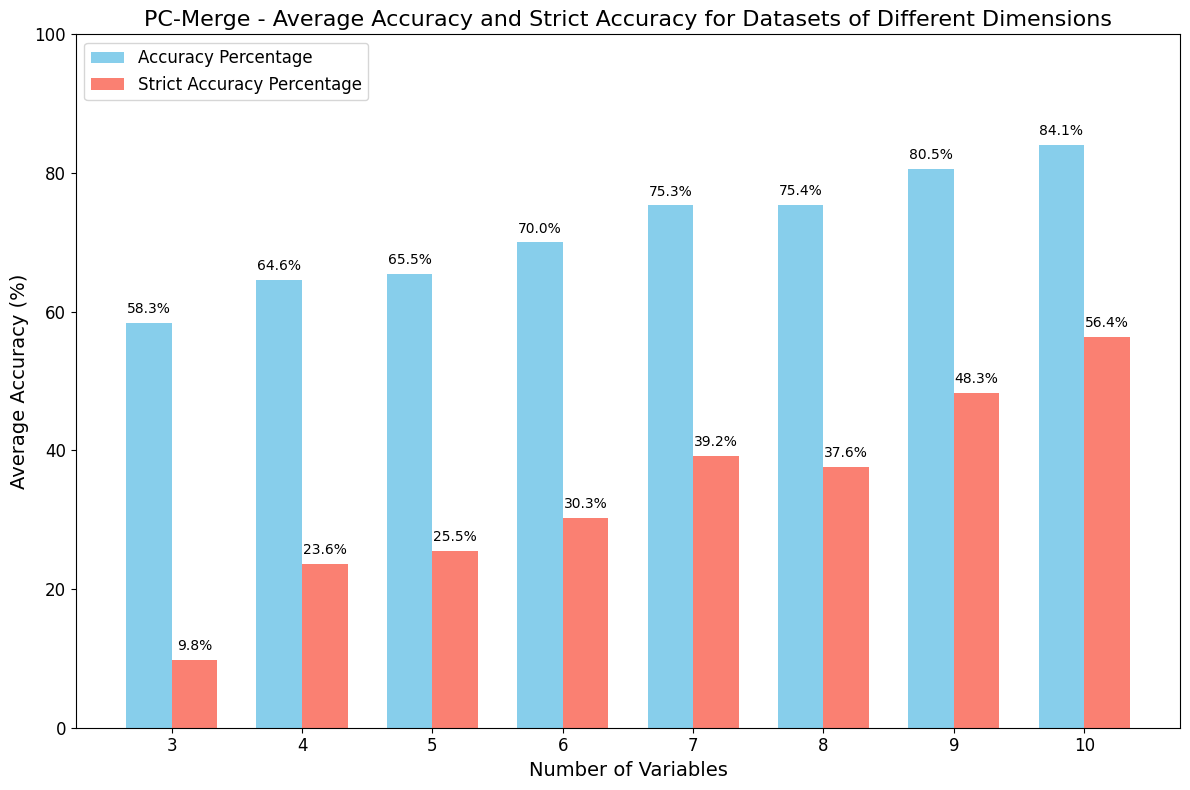

In [22]:
evaluation_results = evaluate_pc_on_datasets(X_train, y_train, num=1000, merge=True)
plot_average_accuracy(evaluation_results, 'PC-Merge')

#### FCI

In [ ]:
from causallearn.search.ConstraintBased.FCI import fci

def FCI_estimate(dataset, alpha=0.05, indep_test='fisherz', kernel=None, 
               depth=-1, max_path_length=-1, verbose=False, show_progress=False):
    """
    使用FCI算法进行因果发现，并应用先验知识。

    参数:
    - dataset (pd.DataFrame): 输入的数据框，包含'X'、'Y'和其他协变量。
    - alpha (float): 显著性水平，默认值为0.05。
    - indep_test (str): 独立性检验方法，默认值为'fisherz'。
    - kernel (str): 核函数类型，默认值为'linear'。
    - verbose (bool): 是否打印详细输出，默认值为False。
    - show_progress (bool): 是否显示算法进度，默认值为False。

    返回:
    - adj_df (pd.DataFrame): 因果图的邻接矩阵，格式为pivot_table。
    """
    
    # 1. 将数据框转换为numpy.ndarray
    data = dataset.values

    # 检验相关系数是否奇异，如果存在多重共线性，对存在多重共线性的变量添加随机扰动
    data = handle_multicollinearity(data)
    
    # 2. 定义先验知识：'X' → 'Y'
    # 创建GraphNode对象
    try:
        node_X = GraphNode('X')
        node_Y = GraphNode('Y')
    except Exception as e:
        raise ValueError("确保数据框中包含名为'X'和'Y'的列。") from e
    
    # 初始化BackgroundKnowledge对象并添加先验知识
    bk = BackgroundKnowledge().add_required_by_node(node_X, node_Y)

    # 3. 配置核参数
    if indep_test == 'kci':
        if kernel is None:
            kernel = 'linear'
        if kernel == 'linear':
            kernel_kwargs = {
                'kernelX': 'Linear', 
                'kernelY': 'Linear', 
                'kernelZ': 'Linear', 
                'approx': True,           # 使用伽玛近似
                'nullss': 1000,          # 原假设下模拟的样本量
            }
        elif kernel == 'polynomial':
            kernel_kwargs = {
                'kernelX': 'Polynomial', 
                'kernelY': 'Polynomial', 
                'kernelZ': 'Polynomial', 
                'polyd': 3,               # 多项式次数设置为3
                'approx': True,           # 使用伽玛近似
                'nullss': 1000,          # 原假设下模拟的样本量
            }
        elif kernel == 'gaussian':
            kernel_kwargs = {
                'kernelX': 'Gaussian', 
                'kernelY': 'Gaussian', 
                'kernelZ': 'Gaussian', 
                'est_width': 'empirical', # 使用经验宽度
                'approx': True,           # 使用伽玛近似
                'nullss': 1000,          # 原假设下模拟的样本量
            }
        elif kernel == 'mix':
            kernel_kwargs = {
                'kernelX': 'Polynomial', 
                'kernelY': 'Polynomial', 
                'kernelZ': 'Gaussian',     # Z使用高斯核
                'polyd': 3,                # 多项式次数设置为3
                'est_width': 'median',     # Z的高斯核带宽使用中位数技巧
                'approx': True,            # 使用伽玛近似
                'nullss': 1000,           # 原假设下模拟的样本量
            }
        else:
            raise ValueError(f'Unknown kernel: {kernel}')
    else:
        kernel_kwargs = {}

    # 4. 运行FCI算法，传入先验知识
    g, edges = fci(data, 
            alpha=alpha, 
            independence_test_method=indep_test, 
            depth=depth,
            max_path_length=max_path_length,
            background_knowledge=bk, 
            verbose=verbose, 
            show_progress=show_progress,
            **kernel_kwargs
    )
    
    # 5. 提取邻接矩阵
    adj_matrix = g.graph
    
    # 6. 将邻接矩阵转换为pandas DataFrame，并设置行列索引为原数据框的列名
    adj_df = pd.DataFrame(adj_matrix, index=dataset.columns, columns=dataset.columns)
    
    return adj_df

### Score-based causal discovery

#### GES

In [70]:
from causallearn.search.ScoreBased.GES import ges

def GES_estimate(dataset, score_func='local_score_CV_general', maxP=None, parameters=None, alpha=0.05):
    """
    使用GES算法进行因果发现。
    
    参数:
    - dataset (pd.DataFrame): 输入的数据框，包含'X'、'Y'和其他协变量。
    - score_func (str): 评分函数，默认为'local_score_BIC'。
    - maxP (int, optional): 最大父节点数量，默认值为None（不限制）。
    - parameters (dict, optional): 评分函数所需的其他参数，默认值为None。
    - alpha (float): 显著性水平，用于多重共线性处理，默认值为0.05。
    
    返回:
    - adj_df (pd.DataFrame): 因果图的邻接矩阵，格式为DataFrame。|
    """

    # 1. 将数据框转换为numpy.ndarray
    data = dataset.values
    
    # 2. 检查相关系数是否奇异，如果存在多重共线性，对存在多重共线性的变量添加随机扰动
    data = handle_multicollinearity(data)
    
    # 3. 运行GES算法，使用指定的评分函数和参数
    # 设置默认参数如果未提供
    if parameters is None:
        parameters = {}
    if score_func == 'local_score_CV_general':
        if 'lambda' not in parameters:
            parameters['lambda'] = 0.01
        if 'kfold' not in parameters:
            parameters['kfold'] = 10
            
    if score_func == 'local_score_marginal_general':
        if 'lambda' not in parameters:
            parameters['lambda'] = 0.01

    Record = ges(data, score_func=score_func, maxP=maxP, parameters=parameters)
    
    # 4. 提取邻接矩阵
    adj_matrix = Record['G'].graph
    
    # 5. 将邻接矩阵转换为pandas DataFrame，并设置行列索引为原数据框的列名
    adj_df = pd.DataFrame(adj_matrix, index=dataset.columns, columns=dataset.columns)
    
    return adj_df

def evaluate_ges_on_datasets(X_train, y_train, num=None, merge=False, score_func='local_score_CV_general', maxP=None, parameters=None):
    """
    遍历多个数据集，评估GES算法的效果。
    
    参数:
    - X_train (dict): 输入的训练数据集，键为数据集名称，值为pd.DataFrame。
    - y_train (dict): 真实因果关系的邻接矩阵，键为数据集名称，值为pd.DataFrame。
    - num (int, optional): 要评估的数据集数量，默认遍历全部。
    - score_func (str): 评分函数，默认为'local_score_BIC'。
    - maxP (int, optional): 最大父节点数量，默认值为None（不限制）。
    - parameters (dict, optional): 评分函数所需的其他参数，默认值为None。
    
    返回:
    - evaluation_results (dict): 包含每个数据集评估结果的字典。
    """
    evaluation_results = {}
    
    # 获取所有数据集的键
    dataset_keys = list(X_train.keys())
    
    # 如果num未指定，遍历所有
    if num is None:
        num = len(dataset_keys)
    else:
        num = min(num, len(dataset_keys))
    
    # 使用tqdm添加进度条
    for key in tqdm(dataset_keys[:num], desc="Evaluating GES Algorithm", unit="dataset"):
        dataset = X_train[key]
        true_adj_df_dag = y_train[key]
        if merge == True:
            variables = dataset.columns.drop(["X", "Y"]).tolist()
            Raw_dataset = dataset.copy()
            Squared_dataset = Squared_col(dataset, variables)
            Cos_dataset = Cos_col(dataset, variables)
            Sin_dataset = Sin_col(dataset, variables)
            datasets = [Raw_dataset, Squared_dataset, Cos_dataset, Sin_dataset]
            estimate_adj_df_dags = [convert_bidirectional_to_dag(GES_estimate(d)) for d in datasets]
            estimate_adj_df_dag = merge_dags(estimate_adj_df_dags)
        else:
            estimate_adj_df_bidirectional = GES_estimate(A, score_func=score_func)
            estimate_adj_df_dag = convert_bidirectional_to_dag(estimate_adj_df_bidirectional)  # 将双向图转换为有向图
        evaluation_result = evaluate_causal_discovery(estimate_adj_df_dag, true_adj_df_dag, focus_vars=['X', 'Y'])
        evaluation_results[key] = evaluation_result
    
    return evaluation_results

In [71]:
# Example usage
A = X_train['00000']
B = y_train['00000']
print(A)
print(B)
C = GES_estimate(A)
print(C)
D = convert_bidirectional_to_dag(C)
print(D)

         0      Y      2      3      4      5      6      7      8      X
0    0.311 -0.365  0.327  0.383 -0.519 -0.015 -0.713  0.183  0.515  0.951
1    0.125  0.657 -0.097 -0.341 -0.807 -0.527 -0.027  0.711  0.591 -0.515
2    0.499 -0.307 -0.395  0.067  0.761 -0.147 -0.501  0.015  0.267  0.109
3   -0.337 -0.105  0.455  0.267 -0.091  0.427  0.037 -0.221 -0.455  0.157
4   -0.139 -0.691 -0.287 -0.383 -0.899  0.415  0.899 -0.771 -0.593 -0.049
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
995 -0.965  0.853 -0.187  0.319 -0.841  0.281  0.795  0.599  0.245 -0.931
996  0.323  0.851  0.775 -0.187  0.361 -0.681 -0.307  0.351  0.433 -0.829
997  0.795  0.409 -0.629 -0.879  0.035 -0.761  0.301  0.355  0.941  0.363
998  0.855 -0.721  0.193 -0.025  0.485 -0.351 -0.799 -0.007 -0.329  0.715
999 -0.851 -0.395 -0.925  0.831 -0.275  0.981  0.607 -0.773 -0.691  0.001

[1000 rows x 10 columns]
        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0

KeyboardInterrupt: 

Evaluating GES Algorithm:   2%|▏         | 21/1000 [00:33<31:36,  1.94s/dataset]d:\anaconda3\envs\adia_py311\Lib\site-packages\causallearn\score\LocalScoreFunction.py:73: RuntimeWarning: invalid value encountered in log
  H = np.log(cov[i, i] - yX * np.linalg.inv(XX) * yX.T)
Evaluating GES Algorithm:  10%|▉         | 98/1000 [02:32<25:04,  1.67s/dataset]d:\anaconda3\envs\adia_py311\Lib\site-packages\causallearn\score\LocalScoreFunction.py:73: RuntimeWarning: invalid value encountered in log
  H = np.log(cov[i, i] - yX * np.linalg.inv(XX) * yX.T)
Evaluating GES Algorithm:  17%|█▋        | 171/1000 [04:18<19:11,  1.39s/dataset]d:\anaconda3\envs\adia_py311\Lib\site-packages\causallearn\score\LocalScoreFunction.py:73: RuntimeWarning: invalid value encountered in log
  H = np.log(cov[i, i] - yX * np.linalg.inv(XX) * yX.T)
Evaluating GES Algorithm:  18%|█▊        | 185/1000 [04:36<21:38,  1.59s/dataset]d:\anaconda3\envs\adia_py311\Lib\site-packages\causallearn\score\LocalScoreFunction.py:73:

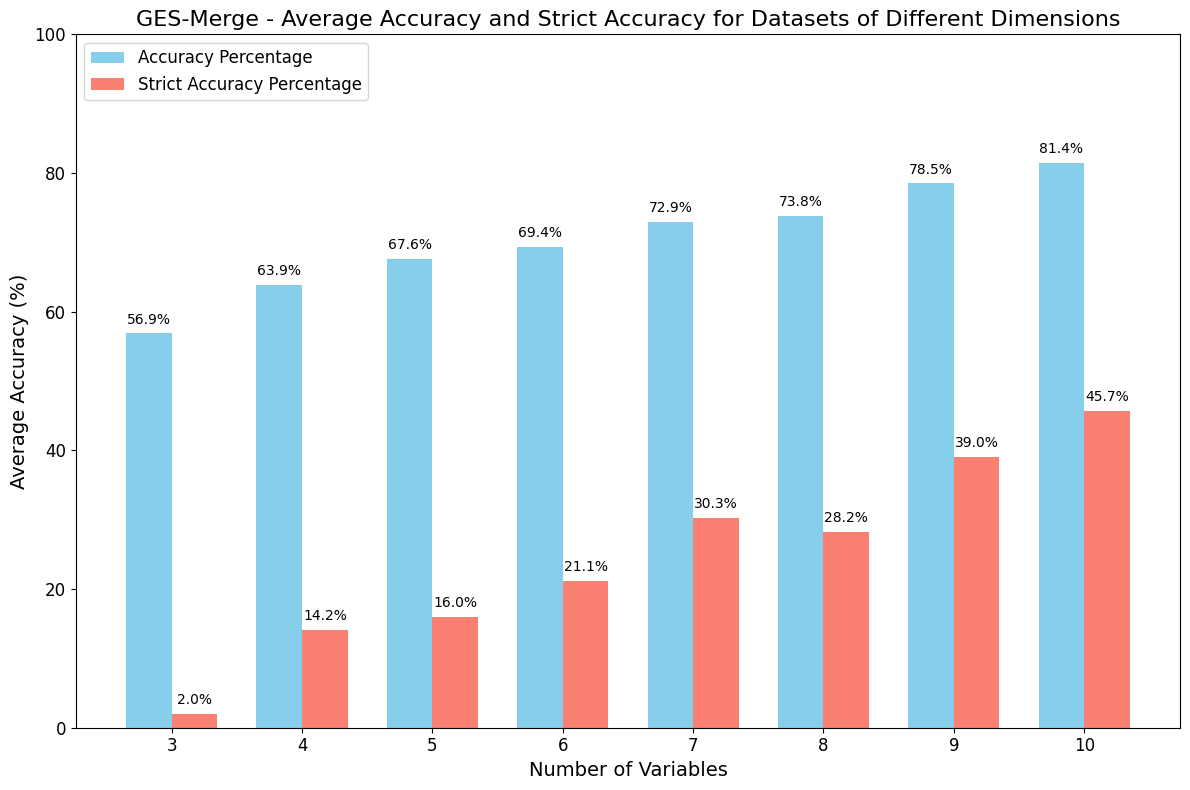

In [24]:
evaluation_results = evaluate_ges_on_datasets(X_train, y_train, num=1000, merge=True)
plot_average_accuracy(evaluation_results, 'GES-Merge')

#### Exact Search

In [23]:
from causallearn.search.ScoreBased.ExactSearch import bic_exact_search

def ExactSearch_estimate(dataset, search_method='astar', use_path_extension=True, 
                        use_k_cycle_heuristic=False, k=3, max_parents=None):
    """
    使用Exact Search算法进行因果发现。
    
    参数:
    - dataset (pd.DataFrame): 输入的数据框，包含'X'、'Y'和其他协变量。
    - search_method (str): Exact Search方法，'astar'或'dp'。默认值为'astar'。
    - use_path_extension (bool): 是否使用路径扩展。默认值为True。
    - use_k_cycle_heuristic (bool): 是否使用k-cycle冲突启发式。仅适用于'astar'方法。默认值为False。
    - k (int): k-cycle启发式的参数。默认值为3。
    - max_parents (int or None): 节点的最大父节点数量。默认值为None。
    
    返回:
    - adj_df (pd.DataFrame): 因果图的邻接矩阵，格式为DataFrame。
    """
    
    # 1. 将数据框转换为numpy.ndarray
    data = dataset.values

    # 2. 定义X→Y的超级图
    d = dataset.shape[1]   
    super_graph = np.ones((d, d), dtype=int)  # 初始化为全1，表示所有边默认允许
    columns = dataset.columns.tolist()
    x_idx = columns.index('X')
    y_idx = columns.index('Y')
    super_graph[y_idx][x_idx] = 0     # 禁止'Y'→'X'
    np.fill_diagonal(super_graph, 0)  # 禁止自环：确保对角线为0
    
    # 3. 运行Exact Search算法，使用指定的参数
    dag_est, search_stats = bic_exact_search(
        X=data, 
        super_graph=super_graph, 
        search_method=search_method,
        use_path_extension=use_path_extension, 
        use_k_cycle_heuristic=use_k_cycle_heuristic,
        k=k, 
        verbose=False, 
        max_parents=max_parents
    )
    
    # 4. 将邻接矩阵转换为pandas DataFrame，并设置行列索引为原数据框的列名
    adj_df = pd.DataFrame(dag_est, index=dataset.columns, columns=dataset.columns)
    
    return adj_df

def evaluate_exact_search_on_datasets(X_train, y_train, num=None, search_method='astar', 
                                      use_path_extension=True, use_k_cycle_heuristic=False, k=3, max_parents=None):
    """
    遍历多个数据集，评估Exact Search算法的效果。
    
    参数:
    - X_train (dict): 输入的训练数据集，键为数据集名称，值为pd.DataFrame。
    - y_train (dict): 真实因果关系的邻接矩阵，键为数据集名称，值为pd.DataFrame。
    - num (int, optional): 要评估的数据集数量，默认遍历全部。
    - super_graph (numpy.ndarray or None): 超结构，用于限制搜索空间。默认值为None。
    - search_method (str): Exact Search方法，'astar'或'dp'。默认值为'astar'。
    - use_path_extension (bool): 是否使用路径扩展。默认值为True。
    - use_k_cycle_heuristic (bool): 是否使用k-cycle冲突启发式。仅适用于'astar'方法。默认值为False。
    - k (int): k-cycle启发式的参数。默认值为3。
    - verbose (bool): 是否打印详细输出。默认值为False。
    - include_graph (bool): 是否在搜索统计中包含图信息。默认值为True。
    - max_parents (int or None): 节点的最大父节点数量。默认值为None。
    - score_func (str): 评分函数。默认为'local_score_BIC'。
    - alpha (float): 显著性水平，用于多重共线性处理。默认值为0.05。
    
    返回:
    - evaluation_results (dict): 包含每个数据集评估结果的字典。
    """
    evaluation_results = {}
    
    # 获取所有数据集的键
    dataset_keys = list(X_train.keys())
    
    # 如果num未指定，遍历所有
    if num is None:
        num = len(dataset_keys)
    else:
        num = min(num, len(dataset_keys))
    
    # 使用tqdm添加进度条
    for key in tqdm(dataset_keys[:num], desc="Evaluating Exact Search Algorithm", unit="dataset"):
        dataset = X_train[key]
        true_adj_df_dag = y_train[key]
        estimate_adj_df = ExactSearch_estimate(
            dataset, 
            search_method=search_method, 
            use_path_extension=use_path_extension,
            use_k_cycle_heuristic=use_k_cycle_heuristic, 
            k=k, 
            max_parents=max_parents
        )
        estimate_adj_df_dag = estimate_adj_df.astype(int)  # Directly using the estimated DAG
        evaluation_result = evaluate_causal_discovery(estimate_adj_df_dag, true_adj_df_dag, focus_vars=['X', 'Y'])
        evaluation_results[key] = evaluation_result
    
    return evaluation_results

In [24]:
# Example usage
A = X_train['00000']
B = y_train['00000']
print(A)
print(B)
C = ExactSearch_estimate(A)
print(C)
D = C.astype(int)
print(D)

         0      Y      2      3      4      5      6      7      8      X
0    0.311 -0.365  0.327  0.383 -0.519 -0.015 -0.713  0.183  0.515  0.951
1    0.125  0.657 -0.097 -0.341 -0.807 -0.527 -0.027  0.711  0.591 -0.515
2    0.499 -0.307 -0.395  0.067  0.761 -0.147 -0.501  0.015  0.267  0.109
3   -0.337 -0.105  0.455  0.267 -0.091  0.427  0.037 -0.221 -0.455  0.157
4   -0.139 -0.691 -0.287 -0.383 -0.899  0.415  0.899 -0.771 -0.593 -0.049
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
995 -0.965  0.853 -0.187  0.319 -0.841  0.281  0.795  0.599  0.245 -0.931
996  0.323  0.851  0.775 -0.187  0.361 -0.681 -0.307  0.351  0.433 -0.829
997  0.795  0.409 -0.629 -0.879  0.035 -0.761  0.301  0.355  0.941  0.363
998  0.855 -0.721  0.193 -0.025  0.485 -0.351 -0.799 -0.007 -0.329  0.715
999 -0.851 -0.395 -0.925  0.831 -0.275  0.981  0.607 -0.773 -0.691  0.001

[1000 rows x 10 columns]
        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0

Evaluating Exact Search Algorithm: 100%|██████████| 1000/1000 [27:11<00:00,  1.63s/dataset]


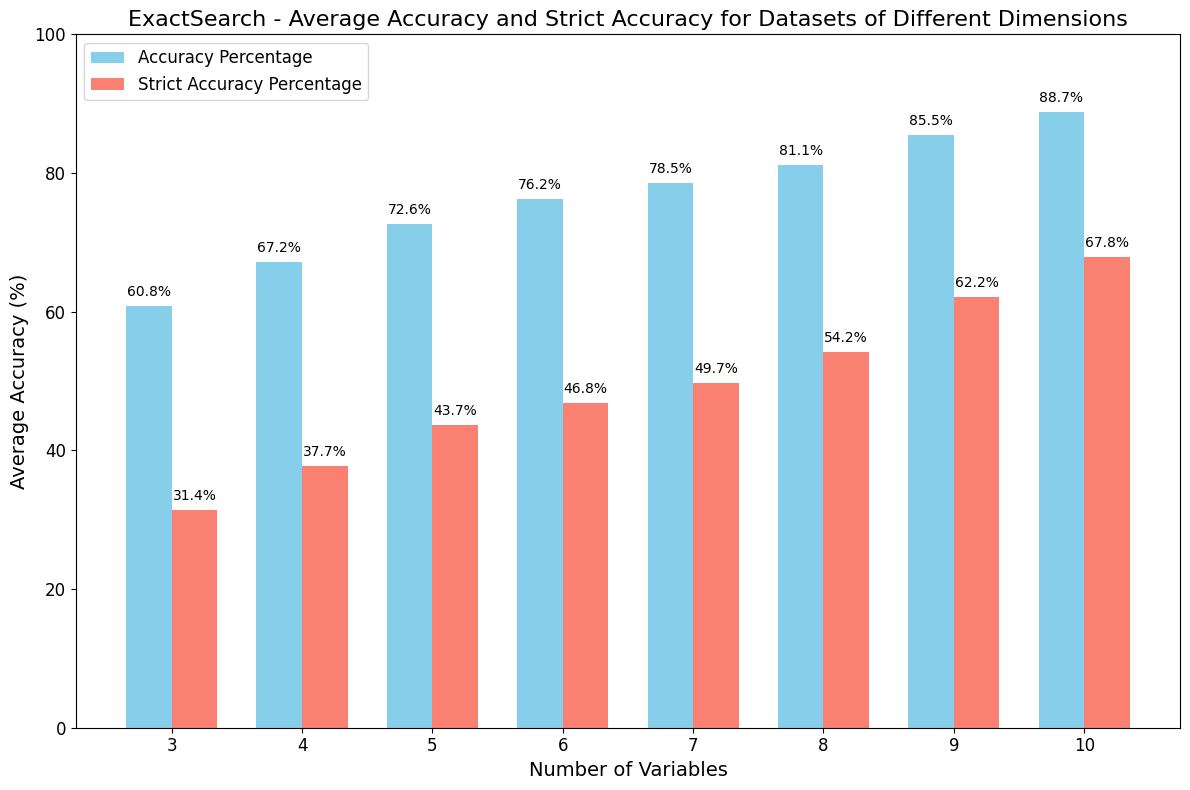

In [25]:
evaluation_results = evaluate_exact_search_on_datasets(X_train, y_train, num=1000)
plot_average_accuracy(evaluation_results, 'ExactSearch')

In [10]:
from dagma.linear import DagmaLinear
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

def NOTEARS_estimate(dataset, lambda1=0.1, w_threshold=0.3):
    """
    使用NOTEARS算法进行因果发现。
    
    参数:
    - dataset (pd.DataFrame): 输入的数据框，包含'X'、'Y'和其他协变量。
    - lambda1 (float): L1正则化参数，默认为0.1。
    - w_threshold (float): 边权重阈值，低于此值的边将被视为不存在，默认为0.3。
    
    返回:
    - adj_df (pd.DataFrame): 因果图的邻接矩阵，格式为DataFrame。
    """
    
    # 1. 将数据框转换为numpy.ndarray
    data = dataset.values
    
    # 2. 运行NOTEARS算法
    model = DagmaLinear(loss_type='l2')
    W_est = model.fit(data, lambda1=lambda1)
    
    # 3. 应用阈值
    W_est[np.abs(W_est) < w_threshold] = 0
    
    # 4. 将邻接矩阵转换为pandas DataFrame，并设置行列索引为原数据框的列名
    adj_df = pd.DataFrame(W_est, index=dataset.columns, columns=dataset.columns)
    
    return adj_df

def evaluate_NOTEARS_on_datasets(X_train, y_train, num=None, lambda1=0.1, w_threshold=0.3):
    """
    遍历多个数据集，评估NOTEARS算法的效果。
    
    参数:
    - X_train (dict): 输入的训练数据集，键为数据集名称，值为pd.DataFrame。
    - y_train (dict): 真实因果关系的邻接矩阵，键为数据集名称，值为pd.DataFrame。
    - num (int, optional): 要评估的数据集数量，默认遍历全部。
    - lambda1 (float): L1正则化参数，默认为0.1。
    - w_threshold (float): 边权重阈值，默认为0.3。
    
    返回:
    - evaluation_results (dict): 包含每个数据集评估结果的字典。
    - last_est_graph (nx.DiGraph): 最后一个数据集的估计图。
    - last_true_graph (nx.DiGraph): 最后一个数据集的真实图。
    """
    evaluation_results = {}
    
    # 获取所有数据集的键
    dataset_keys = list(X_train.keys())
    
    # 如果num未指定，遍历所有
    if num is None:
        num = len(dataset_keys)
    else:
        num = min(num, len(dataset_keys))
    
    last_est_graph = None
    last_true_graph = None
    
    # 使用tqdm添加进度条
    for key in tqdm(dataset_keys[:num], desc="Evaluating NOTEARS Algorithm", unit="dataset"):
        dataset = X_train[key]
        true_adj_df_dag = y_train[key]
        estimate_adj_df = NOTEARS_estimate(dataset, lambda1=lambda1, w_threshold=w_threshold)
        estimate_adj_df_dag = (estimate_adj_df != 0).astype(int)  # 将非零值转换为1
        evaluation_result = evaluate_causal_discovery(estimate_adj_df_dag, true_adj_df_dag, focus_vars=['X', 'Y'])
        evaluation_results[key] = evaluation_result
        
        # 保存最后一个数据集的图
        last_est_graph = nx.from_pandas_adjacency(estimate_adj_df_dag, create_using=nx.DiGraph)
        last_true_graph = nx.from_pandas_adjacency(true_adj_df_dag, create_using=nx.DiGraph)
    
    return evaluation_results, last_est_graph, last_true_graph

def plot_graph(G, title):
    """
    绘制有向图。
    
    参数:
    - G (nx.DiGraph): 要绘制的图。
    - title (str): 图的标题。
    """
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', 
            node_size=500, arrowsize=20, font_size=12)
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


A = X_train['00000']
B = y_train['00000']
print(A)
print(B)
C = NOTEARS_estimate(A)
print(C)
D = (C != 0).astype(int)
print(D)




e:\Softwares\Anaconda\CondaEnvs\casual\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


         0      Y      2      3      4      5      6      7      8      X
0    0.311 -0.365  0.327  0.383 -0.519 -0.015 -0.713  0.183  0.515  0.951
1    0.125  0.657 -0.097 -0.341 -0.807 -0.527 -0.027  0.711  0.591 -0.515
2    0.499 -0.307 -0.395  0.067  0.761 -0.147 -0.501  0.015  0.267  0.109
3   -0.337 -0.105  0.455  0.267 -0.091  0.427  0.037 -0.221 -0.455  0.157
4   -0.139 -0.691 -0.287 -0.383 -0.899  0.415  0.899 -0.771 -0.593 -0.049
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
995 -0.965  0.853 -0.187  0.319 -0.841  0.281  0.795  0.599  0.245 -0.931
996  0.323  0.851  0.775 -0.187  0.361 -0.681 -0.307  0.351  0.433 -0.829
997  0.795  0.409 -0.629 -0.879  0.035 -0.761  0.301  0.355  0.941  0.363
998  0.855 -0.721  0.193 -0.025  0.485 -0.351 -0.799 -0.007 -0.329  0.715
999 -0.851 -0.395 -0.925  0.831 -0.275  0.981  0.607 -0.773 -0.691  0.001

[1000 rows x 10 columns]
        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0

100%|██████████| 180000/180000.0 [00:03<00:00, 59577.11it/s]

     0         Y    2         3    4         5    6        7    8         X
0  0.0  0.000000  0.0  0.000000  0.0 -0.516909  0.0  0.00000  0.0  0.000000
Y  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.00000  0.0 -0.471042
2  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.00000  0.0  0.000000
3  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.00000  0.0  0.000000
4  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.00000  0.0  0.000000
5  0.0  0.000000  0.0  0.424703  0.0  0.000000  0.0  0.00000  0.0  0.000000
6  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.00000  0.0  0.000000
7  0.0  0.320319  0.0  0.000000  0.0  0.000000  0.0  0.00000  0.0  0.000000
8  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.50884  0.0  0.000000
X  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.00000  0.0  0.000000
   0  Y  2  3  4  5  6  7  8  X
0  0  0  0  0  0  1  0  0  0  0
Y  0  0  0  0  0  0  0  0  0  1
2  0  0  0  0  0  0  0  0  0  0
3  0  0  0  0  0  0  0  0  0  0
4  0

100%|██████████| 180000/180000.0 [00:03<00:00, 56963.16it/s]?, ?dataset/s]
100%|██████████| 180000/180000.0 [00:06<00:00, 26672.95it/s]05:13,  3.17s/dataset]
100%|██████████| 180000/180000.0 [00:06<00:00, 29173.02it/s]08:37,  5.28s/dataset]
100%|██████████| 180000/180000.0 [00:05<00:00, 33596.03it/s]09:12,  5.69s/dataset]
100%|██████████| 180000/180000.0 [00:02<00:00, 73682.52it/s] 8:54,  5.56s/dataset]
100%|██████████| 180000/180000.0 [00:02<00:00, 85422.63it/s] 7:01,  4.44s/dataset]
100%|██████████| 180000/180000.0 [00:05<00:00, 32099.84it/s]05:43,  3.65s/dataset]
100%|██████████| 180000/180000.0 [00:06<00:00, 27548.98it/s]06:39,  4.29s/dataset]
100%|██████████| 180000/180000.0 [00:04<00:00, 43644.05it/s]07:40,  5.01s/dataset]
100%|██████████| 180000/180000.0 [00:03<00:00, 53432.03it/s]07:10,  4.73s/dataset]
100%|██████████| 180000/180000.0 [00:07<00:00, 24105.36it/s]<06:28,  4.32s/dataset]
100%|██████████| 180000/180000.0 [00:02<00:00, 67914.62it/s] 07:50,  5.28s/dataset]
100%|█████

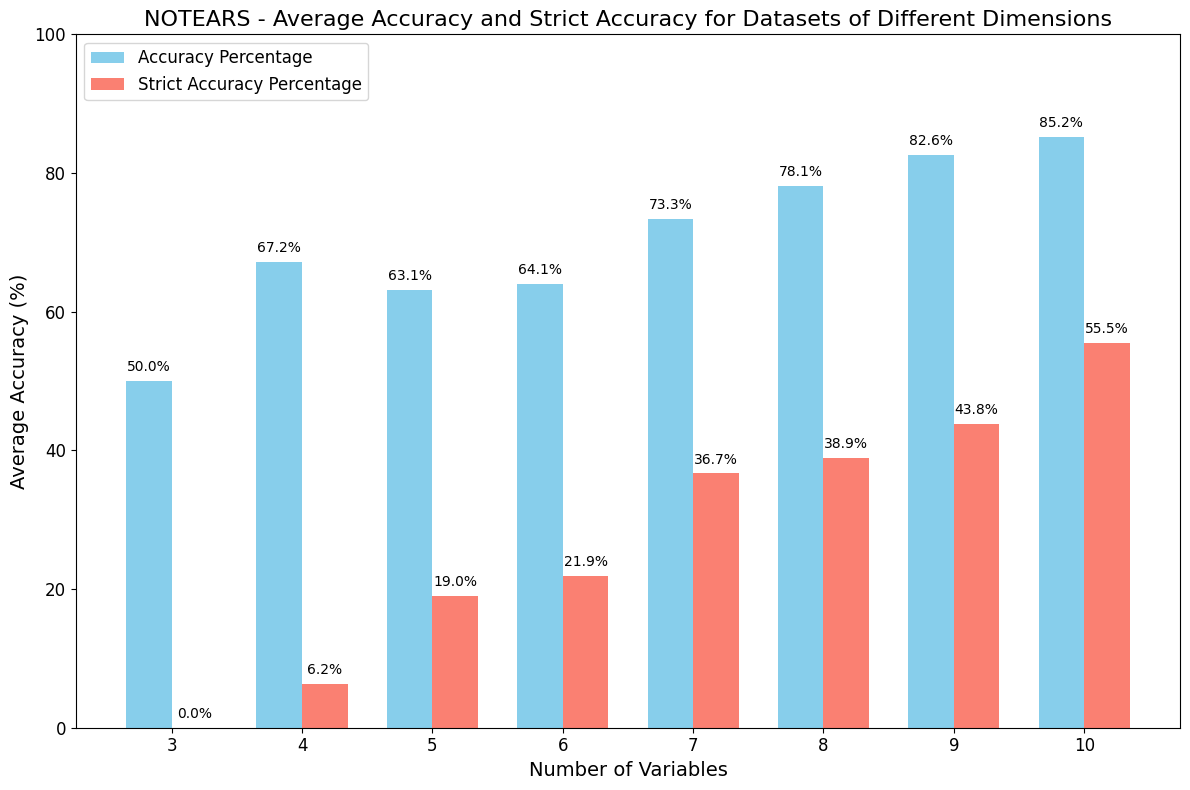

In [16]:
from tqdm import tqdm

evaluation_results = evaluate_NOTEARS_on_datasets(X_train, y_train, num=100)
plot_average_accuracy(evaluation_results, 'NOTEARS')

### LiNGAM-based Methods

#### ICA-based LiNGAM

In [25]:
from causallearn.search.FCMBased import lingam

def ICALiNGAM_estimate(dataset, random_state=42, max_iter=1000):
    # 1. 将数据框转换为numpy.ndarray
    data = dataset.values
    
    # 2. 运行ICALiNGAM算法，使用指定的参数
    model = lingam.ICALiNGAM(random_state=random_state, max_iter=max_iter)
    model.fit(data)

    # print(model.causal_order_)
    # 3. 将邻接矩阵转换为pandas DataFrame，并设置行列索引为原数据框的列名
    adj_df = pd.DataFrame(model.adjacency_matrix_, index=dataset.columns, columns=dataset.columns)
    
    return adj_df

def evaluate_ICALiNGAM_on_datasets(X_train, y_train, num=None, merge=False, random_state=42, max_iter=1000):
    evaluation_results = {}
    
    # 获取所有数据集的键
    dataset_keys = list(X_train.keys())
    
    # 如果num未指定，遍历所有
    if num is None:
        num = len(dataset_keys)
    else:
        num = min(num, len(dataset_keys))
    
    # 使用tqdm添加进度条
    for key in tqdm(dataset_keys[:num], desc="Evaluating ICA-based LiNGAM Algorithm", unit="dataset"):
        dataset = X_train[key]
        true_adj_df_dag = y_train[key]
        if merge == True:
            variables = dataset.columns.drop(["X", "Y"]).tolist()
            Raw_dataset = dataset.copy()
            Squared_dataset = Squared_col(dataset, variables)
            Cos_dataset = Cos_col(dataset, variables)
            Sin_dataset = Sin_col(dataset, variables)
            datasets = [Raw_dataset, Squared_dataset, Cos_dataset, Sin_dataset]
            estimate_adj_df_dags = [convert_dag_with_strength_to_dag(ICALiNGAM_estimate(d)) for d in datasets]
            estimate_adj_df_dag = merge_dags(estimate_adj_df_dags)
        else:
            estimate_adj_df = ICALiNGAM_estimate(dataset, random_state=random_state, max_iter=max_iter)
            estimate_adj_df_dag = convert_dag_with_strength_to_dag(estimate_adj_df)  # convert to no-strength DAG
        evaluation_result = evaluate_causal_discovery(estimate_adj_df_dag, true_adj_df_dag, focus_vars=['X', 'Y'])
        evaluation_results[key] = evaluation_result
    
    return evaluation_results

In [36]:
# Example usage
A = X_train['00000']
B = y_train['00000']
print(A)
print(B)
C = ICALiNGAM_estimate(A)
print(C)
D = convert_dag_with_strength_to_dag(C)
print(D)

         0      Y      2      3      4      5      6      7      8      X
0    0.311 -0.365  0.327  0.383 -0.519 -0.015 -0.713  0.183  0.515  0.951
1    0.125  0.657 -0.097 -0.341 -0.807 -0.527 -0.027  0.711  0.591 -0.515
2    0.499 -0.307 -0.395  0.067  0.761 -0.147 -0.501  0.015  0.267  0.109
3   -0.337 -0.105  0.455  0.267 -0.091  0.427  0.037 -0.221 -0.455  0.157
4   -0.139 -0.691 -0.287 -0.383 -0.899  0.415  0.899 -0.771 -0.593 -0.049
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
995 -0.965  0.853 -0.187  0.319 -0.841  0.281  0.795  0.599  0.245 -0.931
996  0.323  0.851  0.775 -0.187  0.361 -0.681 -0.307  0.351  0.433 -0.829
997  0.795  0.409 -0.629 -0.879  0.035 -0.761  0.301  0.355  0.941  0.363
998  0.855 -0.721  0.193 -0.025  0.485 -0.351 -0.799 -0.007 -0.329  0.715
999 -0.851 -0.395 -0.925  0.831 -0.275  0.981  0.607 -0.773 -0.691  0.001

[1000 rows x 10 columns]
        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0

In [26]:
evaluation_results = evaluate_ICALiNGAM_on_datasets(X_train, y_train, num=1000, merge=True)

Evaluating ICA-based LiNGAM Algorithm:   0%|          | 1/1000 [00:00<03:14,  5.14dataset/s]d:\anaconda3\envs\adia_py311\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
d:\anaconda3\envs\adia_py311\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
d:\anaconda3\envs\adia_py311\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
Evaluating ICA-based LiNGAM Algorithm:   1%|          | 8/1000 [00:02<03:24,  4.85dataset/s]d:\anaconda3\envs\adia_py311\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the

ValueError: cost matrix is infeasible

In [ ]:
plot_average_accuracy(evaluation_results, 'ICA-based LiNGAM')

#### DirectLiNGAM

In [50]:
from causallearn.search.FCMBased import lingam

def DirectLiNGAM_estimate(dataset, random_state=42, measure='pwling'):
    # 1. 将数据框转换为numpy.ndarray
    data = dataset.values

    # 2. 定义先验知识
    d = dataset.shape[1]   
    super_graph = np.ones((d, d), dtype=int) * -1  # 初始化为全-1，表示所有边默认无先验知识
    columns = dataset.columns.tolist()
    x_idx = columns.index('X')
    y_idx = columns.index('Y')
    super_graph[x_idx][y_idx] = 1     # 固定'X'→'Y'
    super_graph[y_idx][x_idx] = 0     # 禁止'Y'→'X'
    np.fill_diagonal(super_graph, 0)  # 禁止自环：确保对角线为0
    
    # 3. 运行DirectLiNGAM算法，使用指定的参数
    model = lingam.DirectLiNGAM(random_state, prior_knowledge=super_graph, apply_prior_knowledge_softly=False, measure=measure)
    model.fit(data)

    # 4. 将邻接矩阵转换为pandas DataFrame，并设置行列索引为原数据框的列名
    adj_df = pd.DataFrame(model.adjacency_matrix_, index=dataset.columns, columns=dataset.columns)
    
    return adj_df

def evaluate_DirectLiNGAM_on_datasets(X_train, y_train, num=None, random_state=42, measure='pwling'):
    evaluation_results = {}
    
    # 获取所有数据集的键
    dataset_keys = list(X_train.keys())
    
    # 如果num未指定，遍历所有
    if num is None:
        num = len(dataset_keys)
    else:
        num = min(num, len(dataset_keys))
    
    # 使用tqdm添加进度条
    for key in tqdm(dataset_keys[:num], desc="Evaluating DirectLiNGAM Algorithm", unit="dataset"):
        dataset = X_train[key]
        true_adj_df_dag = y_train[key]
        estimate_adj_df = DirectLiNGAM_estimate(dataset, random_state=random_state, measure=measure)
        estimate_adj_df_dag = convert_dag_with_strength_to_dag(estimate_adj_df)  # convert to no-strength DAG
        evaluation_result = evaluate_causal_discovery(estimate_adj_df_dag, true_adj_df_dag, focus_vars=['X', 'Y'])
        evaluation_results[key] = evaluation_result
    
    return evaluation_results

In [49]:
# Example usage
A = X_train['00000']
B = y_train['00000']
print(A)
print(B)
C = DirectLiNGAM_estimate(A, random_state=42, measure='pwling')
print(C)
D = convert_dag_with_strength_to_dag(C)
print(D)

         0      Y      2      3      4      5      6      7      8      X
0    0.311 -0.365  0.327  0.383 -0.519 -0.015 -0.713  0.183  0.515  0.951
1    0.125  0.657 -0.097 -0.341 -0.807 -0.527 -0.027  0.711  0.591 -0.515
2    0.499 -0.307 -0.395  0.067  0.761 -0.147 -0.501  0.015  0.267  0.109
3   -0.337 -0.105  0.455  0.267 -0.091  0.427  0.037 -0.221 -0.455  0.157
4   -0.139 -0.691 -0.287 -0.383 -0.899  0.415  0.899 -0.771 -0.593 -0.049
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
995 -0.965  0.853 -0.187  0.319 -0.841  0.281  0.795  0.599  0.245 -0.931
996  0.323  0.851  0.775 -0.187  0.361 -0.681 -0.307  0.351  0.433 -0.829
997  0.795  0.409 -0.629 -0.879  0.035 -0.761  0.301  0.355  0.941  0.363
998  0.855 -0.721  0.193 -0.025  0.485 -0.351 -0.799 -0.007 -0.329  0.715
999 -0.851 -0.395 -0.925  0.831 -0.275  0.981  0.607 -0.773 -0.691  0.001

[1000 rows x 10 columns]
        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0

Evaluating ICA-based LiNGAM Algorithm: 100%|██████████| 1000/1000 [03:20<00:00,  4.99dataset/s]


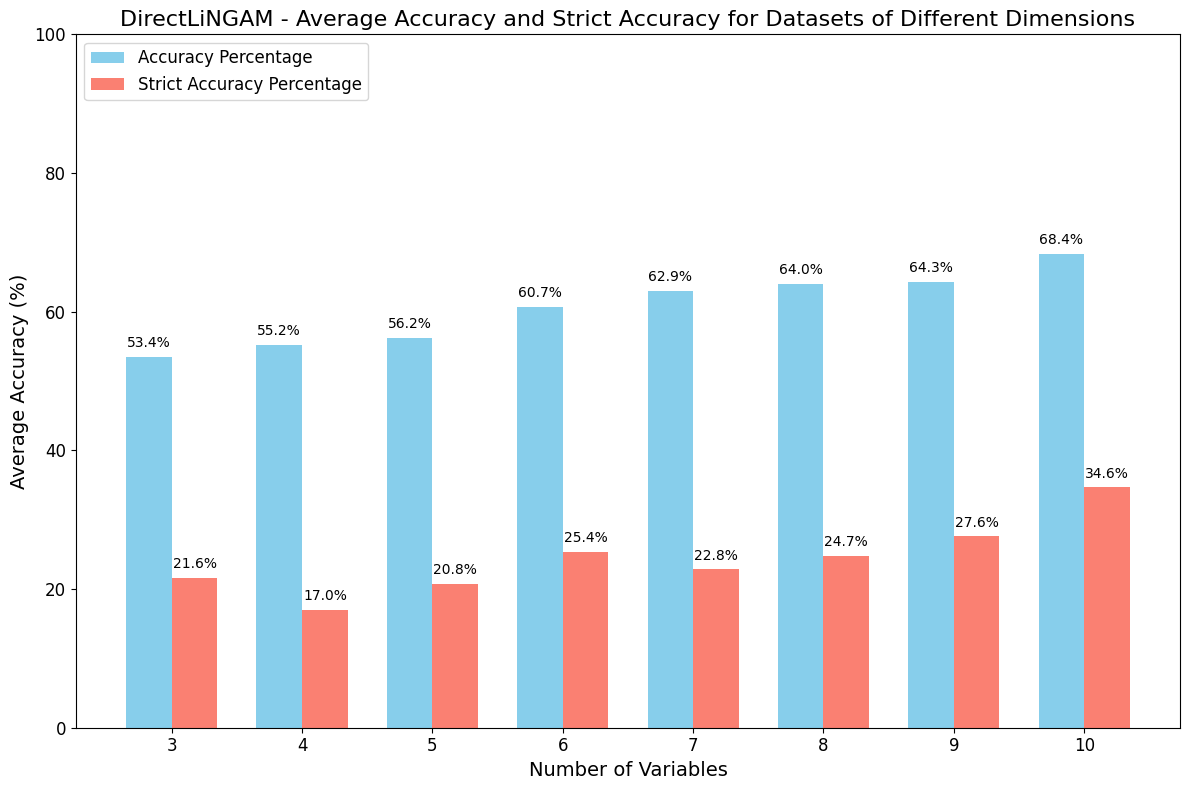

In [51]:
evaluation_results = evaluate_DirectLiNGAM_on_datasets(X_train, y_train, num=1000)
plot_average_accuracy(evaluation_results, 'DirectLiNGAM')

#### RCD

In [52]:
from causallearn.search.FCMBased import lingam

def RCD_estimate(dataset, max_explanatory_num=3, cor_alpha=0.05, ind_alpha=0.05, shapiro_alpha=0.05, MLHSICR=True, bw_method='mdbs'):
    # 1. 将数据框转换为numpy.ndarray
    data = dataset.values
    
    # 2. 运行RCD算法，使用指定的参数
    model = lingam.RCD(
        max_explanatory_num=max_explanatory_num, 
        cor_alpha=cor_alpha, 
        ind_alpha=ind_alpha, 
        shapiro_alpha=shapiro_alpha, 
        MLHSICR=MLHSICR, 
        bw_method=bw_method
    )
    model.fit(data)

    # 3. 将邻接矩阵转换为pandas DataFrame，并设置行列索引为原数据框的列名
    adj_df = pd.DataFrame(model.adjacency_matrix_, index=dataset.columns, columns=dataset.columns)
    
    return adj_df

def evaluate_RCD_on_datasets(X_train, y_train, num=None, max_explanatory_num=3, cor_alpha=0.05, ind_alpha=0.05, shapiro_alpha=0.05, MLHSICR=True, bw_method='mdbs'):
    evaluation_results = {}
    
    # 获取所有数据集的键
    dataset_keys = list(X_train.keys())
    
    # 如果num未指定，遍历所有
    if num is None:
        num = len(dataset_keys)
    else:
        num = min(num, len(dataset_keys))
    
    # 使用tqdm添加进度条
    for key in tqdm(dataset_keys[:num], desc="Evaluating RCD Algorithm", unit="dataset"):
        dataset = X_train[key]
        true_adj_df_dag = y_train[key]
        estimate_adj_df = RCD_estimate(dataset, max_explanatory_num=max_explanatory_num, cor_alpha=cor_alpha,
            ind_alpha=ind_alpha, shapiro_alpha=shapiro_alpha, MLHSICR=MLHSICR, bw_method=bw_method)
        estimate_adj_df_dag = convert_dag_with_strength_to_dag(estimate_adj_df)  # convert to no-strength DAG
        evaluation_result = evaluate_causal_discovery(estimate_adj_df_dag, true_adj_df_dag, focus_vars=['X', 'Y'])
        evaluation_results[key] = evaluation_result
    
    return evaluation_results

In [54]:
# Example usage
A = X_train['00000']
B = y_train['00000']
print(A)
print(B)
C = RCD_estimate(A, max_explanatory_num=3, cor_alpha=0.05, ind_alpha=0.05, shapiro_alpha=0.05, MLHSICR=False, bw_method='mdbs')
print(C)
D = convert_dag_with_strength_to_dag(C)
print(D)

         0      Y      2      3      4      5      6      7      8      X
0    0.311 -0.365  0.327  0.383 -0.519 -0.015 -0.713  0.183  0.515  0.951
1    0.125  0.657 -0.097 -0.341 -0.807 -0.527 -0.027  0.711  0.591 -0.515
2    0.499 -0.307 -0.395  0.067  0.761 -0.147 -0.501  0.015  0.267  0.109
3   -0.337 -0.105  0.455  0.267 -0.091  0.427  0.037 -0.221 -0.455  0.157
4   -0.139 -0.691 -0.287 -0.383 -0.899  0.415  0.899 -0.771 -0.593 -0.049
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
995 -0.965  0.853 -0.187  0.319 -0.841  0.281  0.795  0.599  0.245 -0.931
996  0.323  0.851  0.775 -0.187  0.361 -0.681 -0.307  0.351  0.433 -0.829
997  0.795  0.409 -0.629 -0.879  0.035 -0.761  0.301  0.355  0.941  0.363
998  0.855 -0.721  0.193 -0.025  0.485 -0.351 -0.799 -0.007 -0.329  0.715
999 -0.851 -0.395 -0.925  0.831 -0.275  0.981  0.607 -0.773 -0.691  0.001

[1000 rows x 10 columns]
        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0

#### CAM-UV

In [6]:
from causallearn.search.FCMBased.lingam import CAMUV

def CAMUV_estimate(dataset, alpha=0.05):
    # 1. 将数据框转换为numpy.ndarray
    data = dataset.values
    num_explanatory_vals = data.shape[1] - 1
    print(num_explanatory_vals)
    
    # 2. 运行CAMUV算法，使用指定的参数
    P, U = CAMUV.execute(data, alpha, num_explanatory_vals)

    # 3. 获取邻接矩阵
    num_features = len(dataset.columns)
    adjacency_matrix = np.zeros((num_features, num_features), dtype=int)
    for child_idx, parents in enumerate(P):
        for parent_idx in parents:
            adjacency_matrix[parent_idx, child_idx] = 1

    # 4. 将邻接矩阵转换为pandas DataFrame，并设置行列索引为原数据框的列名
    adj_df = pd.DataFrame(adjacency_matrix, index=dataset.columns, columns=dataset.columns)
    
    return adj_df

def evaluate_CAMUV_on_datasets(X_train, y_train, num=None, alpha=0.05):
    evaluation_results = {}
    
    # 获取所有数据集的键
    dataset_keys = list(X_train.keys())
    
    # 如果num未指定，遍历所有
    if num is None:
        num = len(dataset_keys)
    else:
        num = min(num, len(dataset_keys))
    
    # 使用tqdm添加进度条
    for key in tqdm(dataset_keys[:num], desc="Evaluating CAM-UV Algorithm", unit="dataset"):
        dataset = X_train[key]
        true_adj_df_dag = y_train[key]
        estimate_adj_df = CAMUV_estimate(dataset, alpha=0.05)
        estimate_adj_df_dag = estimate_adj_df.astype(int)  # Directly using the estimated DAG
        evaluation_result = evaluate_causal_discovery(estimate_adj_df_dag, true_adj_df_dag, focus_vars=['X', 'Y'])
        evaluation_results[key] = evaluation_result
    
    return evaluation_results

In [8]:
# Example usage
A = X_train['00000']
B = y_train['00000']
print(A)
print(B)
C = CAMUV_estimate(A, alpha=0.05)
print(C)

         0      Y      2      3      4      5      6      7      8      X
0    0.311 -0.365  0.327  0.383 -0.519 -0.015 -0.713  0.183  0.515  0.951
1    0.125  0.657 -0.097 -0.341 -0.807 -0.527 -0.027  0.711  0.591 -0.515
2    0.499 -0.307 -0.395  0.067  0.761 -0.147 -0.501  0.015  0.267  0.109
3   -0.337 -0.105  0.455  0.267 -0.091  0.427  0.037 -0.221 -0.455  0.157
4   -0.139 -0.691 -0.287 -0.383 -0.899  0.415  0.899 -0.771 -0.593 -0.049
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
995 -0.965  0.853 -0.187  0.319 -0.841  0.281  0.795  0.599  0.245 -0.931
996  0.323  0.851  0.775 -0.187  0.361 -0.681 -0.307  0.351  0.433 -0.829
997  0.795  0.409 -0.629 -0.879  0.035 -0.761  0.301  0.355  0.941  0.363
998  0.855 -0.721  0.193 -0.025  0.485 -0.351 -0.799 -0.007 -0.329  0.715
999 -0.851 -0.395 -0.925  0.831 -0.275  0.981  0.607 -0.773 -0.691  0.001

[1000 rows x 10 columns]
        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0

### Permutation-based causal discovery methods

#### GRaSP

In [12]:
from causallearn.search.PermutationBased.GRaSP import grasp

def GRaSP_estimate(dataset, score_func='local_score_BIC', maxP=None):    
    # 1. 将数据框转换为numpy.ndarray
    data = dataset.values
    # 检验相关系数是否奇异，如果存在多重共线性，对存在多重共线性的变量添加随机扰动
    data = handle_multicollinearity(data)
    
    parameters = {
        'kfold': 2,         # 2 折交叉验证
        'lambda': 0.01      # 正则化参数
    }

    # 2. 运行PC算法，传入先验知识
    G = grasp(
        data, 
        score_func=score_func, 
        maxP=maxP, 
        parameters=parameters
    )

    # 3. 获取邻接矩阵
    adj_matrix = G.graph
    
    # 4. 将邻接矩阵转换为pandas DataFrame，并设置行列索引为原数据框的列名
    adj_df = pd.DataFrame(adj_matrix, index=dataset.columns, columns=dataset.columns)
    
    return adj_df

def evaluate_GRaSP_on_datasets(X_train, y_train, num=None, score_func='local_score_BIC', maxP=None):
    evaluation_results = {}
    
    # 获取所有数据集的键
    dataset_keys = list(X_train.keys())
    
    # 如果num未指定，遍历所有
    if num is None:
        num = len(dataset_keys)
    else:
        num = min(num, len(dataset_keys))
    
    # 使用tqdm添加进度条
    for key in tqdm(dataset_keys[:num], desc="Evaluating GRaSP Algorithm", unit="dataset"):
        dataset = X_train[key]
        true_adj_df_dag = y_train[key]
        estimate_adj_df_bidirectional = GRaSP_estimate(dataset, score_func=score_func, maxP=maxP)  # 双向的估计因果图
        estimate_adj_df_dag = convert_bidirectional_to_dag(estimate_adj_df_bidirectional)  # 将双向图转换为有向图
        evaluation_result = evaluate_causal_discovery(estimate_adj_df_dag, true_adj_df_dag, focus_vars=['X', 'Y'])
        evaluation_results[key] = evaluation_result
    
    return evaluation_results

In [13]:
# Example usage
A = X_train['00000']
B = y_train['00000']
print(A)
print(B)
C = GRaSP_estimate(A)
print(C)
D = convert_bidirectional_to_dag(C)
print(D)

         0      Y      2      3      4      5      6      7      8      X
0    0.311 -0.365  0.327  0.383 -0.519 -0.015 -0.713  0.183  0.515  0.951
1    0.125  0.657 -0.097 -0.341 -0.807 -0.527 -0.027  0.711  0.591 -0.515
2    0.499 -0.307 -0.395  0.067  0.761 -0.147 -0.501  0.015  0.267  0.109
3   -0.337 -0.105  0.455  0.267 -0.091  0.427  0.037 -0.221 -0.455  0.157
4   -0.139 -0.691 -0.287 -0.383 -0.899  0.415  0.899 -0.771 -0.593 -0.049
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
995 -0.965  0.853 -0.187  0.319 -0.841  0.281  0.795  0.599  0.245 -0.931
996  0.323  0.851  0.775 -0.187  0.361 -0.681 -0.307  0.351  0.433 -0.829
997  0.795  0.409 -0.629 -0.879  0.035 -0.761  0.301  0.355  0.941  0.363
998  0.855 -0.721  0.193 -0.025  0.485 -0.351 -0.799 -0.007 -0.329  0.715
999 -0.851 -0.395 -0.925  0.831 -0.275  0.981  0.607 -0.773 -0.691  0.001

[1000 rows x 10 columns]
        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0

KeyboardInterrupt: 

In [20]:
evaluation_results = evaluate_GRaSP_on_datasets(X_train, y_train, num=1000)

Evaluating GRaSP Algorithm:   0%|          | 0/1000 [00:00<?, ?dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:   0%|          | 1/1000 [00:00<02:59,  5.57dataset/s]

GRaSP edge count: 24    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:   0%|          | 2/1000 [00:00<03:22,  4.92dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:   0%|          | 3/1000 [00:00<03:08,  5.29dataset/s]

GRaSP edge count: 18    
GRaSP completed in: 0.40s 


Evaluating GRaSP Algorithm:   0%|          | 4/1000 [00:00<04:34,  3.63dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.08s 
GRaSP edge count: 9    
GRaSP completed in: 0.04s 


Evaluating GRaSP Algorithm:   1%|          | 6/1000 [00:01<02:45,  5.99dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.03s 
GRaSP edge count: 10    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:   1%|          | 8/1000 [00:01<02:26,  6.79dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:   1%|          | 9/1000 [00:01<02:34,  6.42dataset/s]

GRaSP edge count: 7     
GRaSP completed in: 0.09s 
GRaSP edge count: 11    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:   1%|          | 11/1000 [00:01<02:39,  6.21dataset/s]

GRaSP edge count: 2    
GRaSP completed in: 0.01s 

GRaSP completed in: 0.01s 
GRaSP edge count: 21    
GRaSP completed in: 0.34s 


Evaluating GRaSP Algorithm:   1%|▏         | 14/1000 [00:02<02:22,  6.90dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:   2%|▏         | 15/1000 [00:02<02:20,  7.03dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:   2%|▏         | 16/1000 [00:02<02:36,  6.27dataset/s]


GRaSP completed in: 0.04s 

GRaSP completed in: 0.07s 


Evaluating GRaSP Algorithm:   2%|▏         | 18/1000 [00:02<02:01,  8.08dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:   2%|▏         | 19/1000 [00:02<02:23,  6.84dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:   2%|▏         | 20/1000 [00:03<02:48,  5.81dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.28s 


Evaluating GRaSP Algorithm:   2%|▏         | 21/1000 [00:03<03:17,  4.96dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 15    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:   2%|▏         | 23/1000 [00:03<02:42,  6.03dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:   2%|▏         | 24/1000 [00:03<02:46,  5.85dataset/s]


GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:   2%|▎         | 25/1000 [00:04<02:31,  6.43dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.29s 


Evaluating GRaSP Algorithm:   3%|▎         | 26/1000 [00:04<03:07,  5.18dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.02s 
GRaSP edge count: 3    
GRaSP completed in: 0.01s 
GRaSP edge count: 14    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:   3%|▎         | 29/1000 [00:04<02:20,  6.89dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:   3%|▎         | 30/1000 [00:04<02:25,  6.67dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:   3%|▎         | 31/1000 [00:04<02:18,  7.01dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:   3%|▎         | 32/1000 [00:05<02:33,  6.32dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:   3%|▎         | 33/1000 [00:05<02:23,  6.72dataset/s]


GRaSP completed in: 0.30s 


Evaluating GRaSP Algorithm:   3%|▎         | 34/1000 [00:05<03:07,  5.15dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:   4%|▎         | 35/1000 [00:05<02:51,  5.62dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 
GRaSP edge count: 11    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:   4%|▎         | 37/1000 [00:05<02:25,  6.62dataset/s]


GRaSP completed in: 0.02s 

GRaSP completed in: 0.05s 
GRaSP edge count: 9     
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:   4%|▍         | 40/1000 [00:06<01:52,  8.52dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.03s 
GRaSP edge count: 18    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:   4%|▍         | 42/1000 [00:06<01:53,  8.42dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:   4%|▍         | 43/1000 [00:06<02:03,  7.76dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.31s 


Evaluating GRaSP Algorithm:   4%|▍         | 44/1000 [00:06<02:40,  5.94dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.02s 
GRaSP edge count: 11    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:   5%|▍         | 46/1000 [00:07<02:07,  7.49dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.31s 


Evaluating GRaSP Algorithm:   5%|▍         | 47/1000 [00:07<02:44,  5.78dataset/s]


GRaSP completed in: 0.02s 
GRaSP edge count: 16    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:   5%|▍         | 49/1000 [00:07<02:28,  6.38dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:   5%|▌         | 50/1000 [00:07<02:38,  5.98dataset/s]

GRaSP edge count: 22    
GRaSP completed in: 0.40s 


Evaluating GRaSP Algorithm:   5%|▌         | 51/1000 [00:08<03:33,  4.45dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:   5%|▌         | 52/1000 [00:08<03:27,  4.57dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:   5%|▌         | 53/1000 [00:08<03:12,  4.91dataset/s]


GRaSP completed in: 0.06s 
GRaSP edge count: 11    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:   6%|▌         | 55/1000 [00:08<02:30,  6.27dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:   6%|▌         | 56/1000 [00:08<02:21,  6.65dataset/s]

GRaSP edge count: 21    
GRaSP completed in: 0.30s 


Evaluating GRaSP Algorithm:   6%|▌         | 57/1000 [00:09<03:01,  5.19dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.09s 
GRaSP edge count: 14    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:   6%|▌         | 59/1000 [00:09<02:45,  5.67dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.03s 
GRaSP edge count: 18    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:   6%|▌         | 61/1000 [00:09<02:16,  6.88dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.47s 


Evaluating GRaSP Algorithm:   6%|▌         | 62/1000 [00:10<03:23,  4.60dataset/s]

GRaSP edge count: 8     
GRaSP completed in: 0.08s 
GRaSP edge count: 12    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:   6%|▋         | 64/1000 [00:10<02:45,  5.64dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 14    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:   7%|▋         | 66/1000 [00:10<02:14,  6.93dataset/s]

GRaSP edge count: 20    
GRaSP completed in: 0.27s 


Evaluating GRaSP Algorithm:   7%|▋         | 67/1000 [00:10<02:40,  5.81dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:   7%|▋         | 68/1000 [00:11<02:33,  6.07dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.09s 

GRaSP completed in: 0.01s 


Evaluating GRaSP Algorithm:   7%|▋         | 70/1000 [00:11<01:53,  8.20dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.30s 
GRaSP edge count: 13    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:   7%|▋         | 72/1000 [00:11<02:23,  6.45dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.27s 


Evaluating GRaSP Algorithm:   7%|▋         | 73/1000 [00:11<02:48,  5.52dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.03s 
GRaSP edge count: 14    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:   8%|▊         | 75/1000 [00:12<02:29,  6.17dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.03s 
GRaSP edge count: 14    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:   8%|▊         | 77/1000 [00:12<02:08,  7.20dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.32s 


Evaluating GRaSP Algorithm:   8%|▊         | 78/1000 [00:12<02:43,  5.64dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:   8%|▊         | 79/1000 [00:12<02:43,  5.62dataset/s]

GRaSP edge count: 7     
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:   8%|▊         | 80/1000 [00:13<02:40,  5.73dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:   8%|▊         | 81/1000 [00:13<02:58,  5.15dataset/s]

GRaSP edge count: 18    
GRaSP completed in: 0.37s 


Evaluating GRaSP Algorithm:   8%|▊         | 82/1000 [00:13<03:44,  4.09dataset/s]

GRaSP edge count: 2    
GRaSP completed in: 0.01s 
GRaSP edge count: 16    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:   8%|▊         | 84/1000 [00:13<03:05,  4.94dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:   8%|▊         | 85/1000 [00:14<02:50,  5.37dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:   9%|▊         | 86/1000 [00:14<03:05,  4.93dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:   9%|▊         | 87/1000 [00:14<03:07,  4.87dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:   9%|▉         | 88/1000 [00:14<03:13,  4.72dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:   9%|▉         | 89/1000 [00:14<03:11,  4.76dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 
GRaSP edge count: 11    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:   9%|▉         | 91/1000 [00:15<02:52,  5.27dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:   9%|▉         | 92/1000 [00:15<02:39,  5.71dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:   9%|▉         | 93/1000 [00:15<02:27,  6.15dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.07s 
GRaSP edge count: 5    
GRaSP completed in: 0.04s 


Evaluating GRaSP Algorithm:  10%|▉         | 95/1000 [00:15<01:49,  8.27dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  10%|▉         | 96/1000 [00:15<01:53,  7.96dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  10%|▉         | 97/1000 [00:16<02:22,  6.33dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  10%|▉         | 98/1000 [00:16<02:49,  5.31dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  10%|▉         | 99/1000 [00:16<02:51,  5.27dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  10%|█         | 100/1000 [00:16<02:58,  5.03dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:  10%|█         | 101/1000 [00:17<03:18,  4.54dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  10%|█         | 102/1000 [00:17<03:30,  4.28dataset/s]

GRaSP edge count: 27    
GRaSP completed in: 0.53s 


Evaluating GRaSP Algorithm:  10%|█         | 103/1000 [00:17<04:50,  3.08dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 9    
GRaSP completed in: 0.09s 


Evaluating GRaSP Algorithm:  10%|█         | 105/1000 [00:17<03:00,  4.95dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 8    
GRaSP completed in: 0.07s 
GRaSP edge count: 16    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  11%|█         | 108/1000 [00:18<02:16,  6.53dataset/s]

GRaSP edge count: 19    
GRaSP completed in: 0.29s 


Evaluating GRaSP Algorithm:  11%|█         | 109/1000 [00:18<02:41,  5.52dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.06s 
GRaSP edge count: 14    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:  11%|█         | 111/1000 [00:18<02:39,  5.58dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:  11%|█         | 112/1000 [00:19<02:55,  5.05dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  11%|█▏        | 113/1000 [00:19<02:54,  5.07dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  11%|█▏        | 114/1000 [00:19<02:54,  5.07dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  12%|█▏        | 115/1000 [00:19<03:07,  4.72dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 14    
GRaSP completed in: 0.33s 


Evaluating GRaSP Algorithm:  12%|█▏        | 117/1000 [00:20<02:53,  5.08dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  12%|█▏        | 118/1000 [00:20<02:58,  4.94dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  12%|█▏        | 119/1000 [00:20<02:51,  5.14dataset/s]


GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  12%|█▏        | 120/1000 [00:20<02:55,  5.01dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.37s 


Evaluating GRaSP Algorithm:  12%|█▏        | 121/1000 [00:21<03:41,  3.96dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  12%|█▏        | 122/1000 [00:21<03:38,  4.02dataset/s]

GRaSP edge count: 23    
GRaSP completed in: 0.40s 


Evaluating GRaSP Algorithm:  12%|█▏        | 123/1000 [00:21<04:19,  3.38dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  12%|█▏        | 124/1000 [00:22<03:41,  3.96dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  12%|█▎        | 125/1000 [00:22<03:25,  4.26dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  13%|█▎        | 126/1000 [00:22<03:04,  4.73dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  13%|█▎        | 127/1000 [00:22<03:01,  4.82dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.05s 
GRaSP edge count: 3    
GRaSP completed in: 0.02s 

GRaSP completed in: 0.01s 
GRaSP edge count: 23    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  13%|█▎        | 131/1000 [00:22<01:43,  8.43dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.09s 
GRaSP edge count: 10    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  13%|█▎        | 133/1000 [00:23<01:45,  8.21dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  13%|█▎        | 134/1000 [00:23<01:47,  8.04dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.44s 


Evaluating GRaSP Algorithm:  14%|█▎        | 135/1000 [00:23<02:45,  5.23dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  14%|█▎        | 136/1000 [00:23<02:41,  5.36dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  14%|█▎        | 137/1000 [00:24<02:55,  4.91dataset/s]


GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  14%|█▍        | 138/1000 [00:24<02:57,  4.85dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:  14%|█▍        | 139/1000 [00:24<03:05,  4.63dataset/s]


GRaSP completed in: 0.03s 
GRaSP edge count: 12    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  14%|█▍        | 141/1000 [00:24<02:19,  6.14dataset/s]

GRaSP edge count: 20    
GRaSP completed in: 0.34s 


Evaluating GRaSP Algorithm:  14%|█▍        | 142/1000 [00:25<03:00,  4.74dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  14%|█▍        | 143/1000 [00:25<03:11,  4.47dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  14%|█▍        | 144/1000 [00:25<02:46,  5.13dataset/s]

GRaSP edge count: 22    
GRaSP completed in: 0.42s 


Evaluating GRaSP Algorithm:  14%|█▍        | 145/1000 [00:25<03:44,  3.80dataset/s]

GRaSP edge count: 24    
GRaSP completed in: 0.27s 


Evaluating GRaSP Algorithm:  15%|█▍        | 146/1000 [00:26<03:50,  3.70dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:  15%|█▍        | 147/1000 [00:26<03:44,  3.80dataset/s]


GRaSP completed in: 0.02s 

GRaSP completed in: 0.01s 
GRaSP edge count: 13    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  15%|█▌        | 150/1000 [00:26<02:09,  6.56dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  15%|█▌        | 151/1000 [00:26<02:10,  6.52dataset/s]

GRaSP edge count: 29    
GRaSP completed in: 0.74s 


Evaluating GRaSP Algorithm:  15%|█▌        | 152/1000 [00:27<04:06,  3.43dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  15%|█▌        | 153/1000 [00:27<03:45,  3.76dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  15%|█▌        | 154/1000 [00:27<03:33,  3.96dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.07s 
GRaSP edge count: 11    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  16%|█▌        | 156/1000 [00:28<02:52,  4.90dataset/s]


GRaSP completed in: 0.04s 
GRaSP edge count: 15    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:  16%|█▌        | 158/1000 [00:28<02:38,  5.32dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  16%|█▌        | 159/1000 [00:28<02:23,  5.86dataset/s]


GRaSP completed in: 0.06s 
GRaSP edge count: 18    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  16%|█▌        | 161/1000 [00:28<02:01,  6.88dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  16%|█▌        | 162/1000 [00:29<02:06,  6.65dataset/s]

GRaSP edge count: 18    
GRaSP completed in: 0.43s 


Evaluating GRaSP Algorithm:  16%|█▋        | 163/1000 [00:29<03:02,  4.60dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  16%|█▋        | 164/1000 [00:29<02:45,  5.04dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.04s 
GRaSP edge count: 15    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  17%|█▋        | 166/1000 [00:29<02:14,  6.22dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  17%|█▋        | 167/1000 [00:29<02:09,  6.41dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  17%|█▋        | 168/1000 [00:30<02:23,  5.82dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.29s 


Evaluating GRaSP Algorithm:  17%|█▋        | 169/1000 [00:30<02:51,  4.85dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 12    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  17%|█▋        | 171/1000 [00:30<02:12,  6.24dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  17%|█▋        | 172/1000 [00:30<02:04,  6.67dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  17%|█▋        | 173/1000 [00:30<02:06,  6.55dataset/s]

GRaSP edge count: 2    
GRaSP completed in: 0.01s 
GRaSP edge count: 13    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  18%|█▊        | 175/1000 [00:31<02:00,  6.82dataset/s]


GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  18%|█▊        | 176/1000 [00:31<01:56,  7.08dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  18%|█▊        | 177/1000 [00:31<01:59,  6.90dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  18%|█▊        | 178/1000 [00:31<01:52,  7.33dataset/s]


GRaSP completed in: 0.06s 
GRaSP edge count: 12    
GRaSP completed in: 0.28s 


Evaluating GRaSP Algorithm:  18%|█▊        | 180/1000 [00:32<02:06,  6.49dataset/s]

GRaSP edge count: 3    
GRaSP completed in: 0.02s 
GRaSP edge count: 19    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  18%|█▊        | 182/1000 [00:32<01:56,  7.01dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.03s 
GRaSP edge count: 14    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  18%|█▊        | 184/1000 [00:32<01:58,  6.89dataset/s]

GRaSP edge count: 19    
GRaSP completed in: 0.36s 


Evaluating GRaSP Algorithm:  18%|█▊        | 185/1000 [00:32<02:35,  5.24dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  19%|█▊        | 186/1000 [00:33<02:22,  5.70dataset/s]

GRaSP edge count: 23    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  19%|█▊        | 187/1000 [00:33<02:30,  5.41dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  19%|█▉        | 188/1000 [00:33<02:30,  5.40dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  19%|█▉        | 189/1000 [00:33<02:20,  5.78dataset/s]

GRaSP edge count: 19    
GRaSP completed in: 0.28s 


Evaluating GRaSP Algorithm:  19%|█▉        | 190/1000 [00:33<02:47,  4.85dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.02s 
GRaSP edge count: 22    
GRaSP completed in: 0.47s 


Evaluating GRaSP Algorithm:  19%|█▉        | 192/1000 [00:34<03:04,  4.39dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.09s 
GRaSP edge count: 8    
GRaSP completed in: 0.04s 


Evaluating GRaSP Algorithm:  19%|█▉        | 194/1000 [00:34<02:15,  5.93dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  20%|█▉        | 195/1000 [00:34<02:06,  6.34dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  20%|█▉        | 196/1000 [00:34<02:02,  6.54dataset/s]


GRaSP completed in: 0.02s 
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  20%|█▉        | 198/1000 [00:34<01:34,  8.49dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.29s 


Evaluating GRaSP Algorithm:  20%|█▉        | 199/1000 [00:35<02:08,  6.25dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.04s 
GRaSP edge count: 15    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  20%|██        | 201/1000 [00:35<01:58,  6.75dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  20%|██        | 202/1000 [00:35<02:00,  6.60dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.30s 


Evaluating GRaSP Algorithm:  20%|██        | 203/1000 [00:35<02:31,  5.25dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  20%|██        | 204/1000 [00:36<02:22,  5.59dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  20%|██        | 205/1000 [00:36<02:27,  5.38dataset/s]

GRaSP edge count: 3    
GRaSP completed in: 0.01s 
GRaSP edge count: 11    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  21%|██        | 207/1000 [00:36<01:52,  7.02dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  21%|██        | 208/1000 [00:36<01:49,  7.23dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  21%|██        | 209/1000 [00:36<02:03,  6.39dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.09s 


Evaluating GRaSP Algorithm:  21%|██        | 210/1000 [00:36<01:52,  7.05dataset/s]


GRaSP completed in: 0.01s 

GRaSP completed in: 0.02s 
GRaSP edge count: 9     
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  21%|██▏       | 213/1000 [00:37<01:16, 10.29dataset/s]


GRaSP completed in: 0.01s 

GRaSP completed in: 0.06s 
GRaSP edge count: 13    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  22%|██▏       | 216/1000 [00:37<01:10, 11.14dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 11    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:  22%|██▏       | 218/1000 [00:37<01:22,  9.47dataset/s]

GRaSP edge count: 19    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  22%|██▏       | 219/1000 [00:37<01:37,  8.02dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  22%|██▏       | 220/1000 [00:38<01:45,  7.42dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  22%|██▏       | 221/1000 [00:38<02:02,  6.34dataset/s]

GRaSP edge count: 22    
GRaSP completed in: 0.29s 


Evaluating GRaSP Algorithm:  22%|██▏       | 222/1000 [00:38<02:29,  5.22dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  22%|██▏       | 223/1000 [00:38<02:27,  5.28dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  22%|██▏       | 224/1000 [00:38<02:26,  5.29dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  22%|██▎       | 225/1000 [00:39<02:33,  5.06dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  23%|██▎       | 226/1000 [00:39<02:32,  5.09dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  23%|██▎       | 227/1000 [00:39<02:43,  4.73dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.05s 
GRaSP edge count: 15    
GRaSP completed in: 0.43s 


Evaluating GRaSP Algorithm:  23%|██▎       | 229/1000 [00:40<02:55,  4.39dataset/s]

GRaSP edge count: 4    
GRaSP completed in: 0.03s 
GRaSP edge count: 5    
GRaSP completed in: 0.02s 
GRaSP edge count: 11    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  23%|██▎       | 232/1000 [00:40<02:06,  6.08dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  23%|██▎       | 233/1000 [00:40<02:09,  5.93dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.31s 


Evaluating GRaSP Algorithm:  23%|██▎       | 234/1000 [00:40<02:34,  4.96dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.29s 


Evaluating GRaSP Algorithm:  24%|██▎       | 235/1000 [00:41<02:51,  4.46dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.04s 
GRaSP edge count: 2    
GRaSP completed in: 0.01s 
GRaSP edge count: 11    
GRaSP completed in: 0.09s 


Evaluating GRaSP Algorithm:  24%|██▍       | 238/1000 [00:41<01:46,  7.18dataset/s]


GRaSP completed in: 0.03s 
GRaSP edge count: 20    
GRaSP completed in: 0.47s 


Evaluating GRaSP Algorithm:  24%|██▍       | 240/1000 [00:41<02:17,  5.51dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  24%|██▍       | 241/1000 [00:42<02:19,  5.43dataset/s]

GRaSP edge count: 3    
GRaSP completed in: 0.02s 
GRaSP edge count: 11    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  24%|██▍       | 243/1000 [00:42<01:52,  6.70dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  24%|██▍       | 244/1000 [00:42<01:55,  6.53dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  24%|██▍       | 245/1000 [00:42<01:48,  6.97dataset/s]

GRaSP edge count: 4    
GRaSP completed in: 0.02s 
GRaSP edge count: 15    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  25%|██▍       | 247/1000 [00:42<01:43,  7.30dataset/s]

GRaSP edge count: 8     
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  25%|██▍       | 248/1000 [00:42<01:39,  7.59dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:  25%|██▍       | 249/1000 [00:43<02:04,  6.05dataset/s]

GRaSP edge count: 23    
GRaSP completed in: 0.32s 


Evaluating GRaSP Algorithm:  25%|██▌       | 250/1000 [00:43<02:36,  4.79dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 3    
GRaSP completed in: 0.02s 
GRaSP edge count: 19    
GRaSP completed in: 0.74s 


Evaluating GRaSP Algorithm:  25%|██▌       | 253/1000 [00:44<02:57,  4.20dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  25%|██▌       | 254/1000 [00:44<02:56,  4.24dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  26%|██▌       | 255/1000 [00:44<02:46,  4.47dataset/s]


GRaSP completed in: 0.02s 
GRaSP edge count: 11    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  26%|██▌       | 257/1000 [00:44<02:11,  5.67dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.07s 
GRaSP edge count: 10    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  26%|██▌       | 259/1000 [00:45<01:52,  6.61dataset/s]

GRaSP edge count: 4    
GRaSP completed in: 0.01s 
GRaSP edge count: 15    
GRaSP completed in: 0.32s 


Evaluating GRaSP Algorithm:  26%|██▌       | 261/1000 [00:45<01:57,  6.27dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  26%|██▌       | 262/1000 [00:45<02:03,  5.99dataset/s]

GRaSP edge count: 8     
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  26%|██▋       | 263/1000 [00:45<02:08,  5.72dataset/s]

GRaSP edge count: 3    
GRaSP completed in: 0.01s 
GRaSP edge count: 11    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  26%|██▋       | 265/1000 [00:46<01:40,  7.33dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  27%|██▋       | 266/1000 [00:46<01:55,  6.36dataset/s]

GRaSP edge count: 24    
GRaSP completed in: 0.42s 


Evaluating GRaSP Algorithm:  27%|██▋       | 267/1000 [00:46<02:43,  4.49dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.08s 

GRaSP completed in: 0.01s 


Evaluating GRaSP Algorithm:  27%|██▋       | 269/1000 [00:46<01:53,  6.46dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  27%|██▋       | 270/1000 [00:46<01:53,  6.42dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  27%|██▋       | 271/1000 [00:47<01:59,  6.10dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  27%|██▋       | 272/1000 [00:47<01:50,  6.58dataset/s]

GRaSP edge count: 24    
GRaSP completed in: 0.60s 


Evaluating GRaSP Algorithm:  27%|██▋       | 273/1000 [00:47<03:20,  3.62dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  27%|██▋       | 274/1000 [00:48<02:51,  4.23dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  28%|██▊       | 275/1000 [00:48<02:43,  4.42dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  28%|██▊       | 276/1000 [00:48<02:20,  5.16dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 11    
GRaSP completed in: 0.09s 


Evaluating GRaSP Algorithm:  28%|██▊       | 278/1000 [00:48<01:36,  7.47dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  28%|██▊       | 279/1000 [00:48<01:44,  6.90dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  28%|██▊       | 280/1000 [00:48<01:57,  6.15dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.03s 
GRaSP edge count: 16    
GRaSP completed in: 0.29s 


Evaluating GRaSP Algorithm:  28%|██▊       | 282/1000 [00:49<02:00,  5.97dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  28%|██▊       | 283/1000 [00:49<02:16,  5.25dataset/s]

GRaSP edge count: 2    
GRaSP completed in: 0.01s 
GRaSP edge count: 26    
GRaSP completed in: 0.39s 


Evaluating GRaSP Algorithm:  28%|██▊       | 285/1000 [00:49<02:21,  5.05dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  29%|██▊       | 286/1000 [00:50<02:20,  5.08dataset/s]

GRaSP edge count: 19    
GRaSP completed in: 0.30s 


Evaluating GRaSP Algorithm:  29%|██▊       | 287/1000 [00:50<02:40,  4.45dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.07s 
GRaSP edge count: 3    
GRaSP completed in: 0.04s 


Evaluating GRaSP Algorithm:  29%|██▉       | 289/1000 [00:50<01:52,  6.32dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  29%|██▉       | 290/1000 [00:50<01:51,  6.38dataset/s]

GRaSP edge count: 35    
GRaSP completed in: 0.66s 


Evaluating GRaSP Algorithm:  29%|██▉       | 291/1000 [00:51<03:22,  3.51dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  29%|██▉       | 292/1000 [00:51<02:57,  3.99dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.31s 


Evaluating GRaSP Algorithm:  29%|██▉       | 293/1000 [00:51<03:11,  3.70dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.07s 
GRaSP edge count: 20    
GRaSP completed in: 0.34s 


Evaluating GRaSP Algorithm:  30%|██▉       | 295/1000 [00:52<02:55,  4.01dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:  30%|██▉       | 296/1000 [00:52<02:53,  4.06dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  30%|██▉       | 297/1000 [00:52<02:46,  4.23dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  30%|██▉       | 298/1000 [00:52<02:45,  4.24dataset/s]

GRaSP edge count: 21    
GRaSP completed in: 0.30s 


Evaluating GRaSP Algorithm:  30%|██▉       | 299/1000 [00:53<03:00,  3.89dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  30%|███       | 300/1000 [00:53<02:53,  4.03dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  30%|███       | 301/1000 [00:53<02:42,  4.30dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  30%|███       | 302/1000 [00:53<02:47,  4.16dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.03s 

GRaSP completed in: 0.01s 
GRaSP edge count: 5    
GRaSP completed in: 0.07s 


Evaluating GRaSP Algorithm:  30%|███       | 305/1000 [00:54<01:30,  7.70dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.02s 
GRaSP edge count: 6    
GRaSP completed in: 0.04s 
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


Evaluating GRaSP Algorithm:  31%|███       | 308/1000 [00:54<01:07, 10.21dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.30s 
GRaSP edge count: 12    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  31%|███       | 310/1000 [00:54<01:43,  6.65dataset/s]


GRaSP completed in: 0.04s 
GRaSP edge count: 11    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  31%|███       | 312/1000 [00:55<01:36,  7.12dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.03s 
GRaSP edge count: 2    
GRaSP completed in: 0.01s 
GRaSP edge count: 10    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  32%|███▏      | 315/1000 [00:55<01:20,  8.48dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.11s 
GRaSP edge count: 10    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  32%|███▏      | 317/1000 [00:55<01:21,  8.37dataset/s]

GRaSP edge count: 23    
GRaSP completed in: 0.36s 


Evaluating GRaSP Algorithm:  32%|███▏      | 318/1000 [00:55<01:49,  6.24dataset/s]


GRaSP completed in: 0.07s 
GRaSP edge count: 17    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  32%|███▏      | 320/1000 [00:56<01:41,  6.69dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 7     
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  32%|███▏      | 322/1000 [00:56<01:23,  8.10dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  32%|███▏      | 323/1000 [00:56<01:30,  7.48dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.07s 
GRaSP edge count: 14    
GRaSP completed in: 0.29s 


Evaluating GRaSP Algorithm:  32%|███▎      | 325/1000 [00:56<01:42,  6.56dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  33%|███▎      | 326/1000 [00:56<01:43,  6.49dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  33%|███▎      | 327/1000 [00:57<01:42,  6.56dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:  33%|███▎      | 328/1000 [00:57<01:57,  5.74dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  33%|███▎      | 329/1000 [00:57<01:47,  6.22dataset/s]

GRaSP edge count: 4    
GRaSP completed in: 0.03s 
GRaSP edge count: 13    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  33%|███▎      | 331/1000 [00:57<01:32,  7.25dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  33%|███▎      | 332/1000 [00:57<01:36,  6.90dataset/s]


GRaSP completed in: 0.03s 
GRaSP edge count: 7    
GRaSP completed in: 0.05s 

GRaSP completed in: 0.03s 


Evaluating GRaSP Algorithm:  34%|███▎      | 335/1000 [00:58<01:01, 10.74dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.12s 
GRaSP edge count: 18    
GRaSP completed in: 0.44s 


Evaluating GRaSP Algorithm:  34%|███▎      | 337/1000 [00:58<01:43,  6.42dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 26    
GRaSP completed in: 0.31s 


Evaluating GRaSP Algorithm:  34%|███▍      | 339/1000 [00:58<01:44,  6.30dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  34%|███▍      | 340/1000 [00:59<01:52,  5.87dataset/s]

GRaSP edge count: 18    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:  34%|███▍      | 341/1000 [00:59<02:06,  5.21dataset/s]

GRaSP edge count: 18    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:  34%|███▍      | 342/1000 [00:59<02:13,  4.93dataset/s]

GRaSP edge count: 8     
GRaSP completed in: 0.09s 


Evaluating GRaSP Algorithm:  34%|███▍      | 343/1000 [00:59<01:57,  5.61dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.32s 


Evaluating GRaSP Algorithm:  34%|███▍      | 344/1000 [01:00<02:23,  4.59dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  34%|███▍      | 345/1000 [01:00<02:13,  4.90dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.04s 
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  35%|███▍      | 347/1000 [01:00<01:37,  6.73dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  35%|███▍      | 348/1000 [01:00<01:43,  6.31dataset/s]

GRaSP edge count: 4    
GRaSP completed in: 0.02s 
GRaSP edge count: 11    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  35%|███▌      | 350/1000 [01:00<01:24,  7.68dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.04s 
GRaSP edge count: 20    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  35%|███▌      | 352/1000 [01:01<01:29,  7.21dataset/s]


GRaSP completed in: 0.00s 
GRaSP edge count: 8     
GRaSP completed in: 0.09s 


Evaluating GRaSP Algorithm:  35%|███▌      | 354/1000 [01:01<01:10,  9.12dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.25s 
GRaSP edge count: 21    
GRaSP completed in: 0.30s 


Evaluating GRaSP Algorithm:  36%|███▌      | 356/1000 [01:01<01:47,  5.98dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  36%|███▌      | 357/1000 [01:01<01:49,  5.85dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  36%|███▌      | 358/1000 [01:02<01:54,  5.62dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  36%|███▌      | 359/1000 [01:02<01:53,  5.67dataset/s]

GRaSP edge count: 22    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  36%|███▌      | 360/1000 [01:02<02:00,  5.29dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.07s 
GRaSP edge count: 10    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  36%|███▌      | 362/1000 [01:02<01:41,  6.29dataset/s]

GRaSP edge count: 18    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  36%|███▋      | 363/1000 [01:02<01:44,  6.09dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:  36%|███▋      | 364/1000 [01:03<01:55,  5.50dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  36%|███▋      | 365/1000 [01:03<01:51,  5.70dataset/s]

GRaSP edge count: 26    
GRaSP completed in: 0.31s 


Evaluating GRaSP Algorithm:  37%|███▋      | 366/1000 [01:03<02:16,  4.63dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  37%|███▋      | 367/1000 [01:03<02:14,  4.70dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  37%|███▋      | 368/1000 [01:04<02:05,  5.03dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  37%|███▋      | 369/1000 [01:04<02:05,  5.04dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 9     
GRaSP completed in: 0.09s 


Evaluating GRaSP Algorithm:  37%|███▋      | 371/1000 [01:04<01:23,  7.57dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  37%|███▋      | 372/1000 [01:04<01:35,  6.55dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  37%|███▋      | 373/1000 [01:04<01:31,  6.86dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  37%|███▋      | 374/1000 [01:04<01:31,  6.82dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  38%|███▊      | 375/1000 [01:05<01:44,  6.00dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  38%|███▊      | 376/1000 [01:05<01:43,  6.06dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:  38%|███▊      | 377/1000 [01:05<01:56,  5.35dataset/s]

GRaSP edge count: 4    
GRaSP completed in: 0.02s 
GRaSP edge count: 20    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:  38%|███▊      | 379/1000 [01:05<01:44,  5.92dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  38%|███▊      | 380/1000 [01:05<01:38,  6.31dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.09s 
GRaSP edge count: 12    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  38%|███▊      | 382/1000 [01:06<01:29,  6.89dataset/s]

GRaSP edge count: 7     
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  38%|███▊      | 383/1000 [01:06<01:29,  6.86dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  38%|███▊      | 384/1000 [01:06<01:34,  6.55dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.09s 
GRaSP edge count: 15    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  39%|███▊      | 386/1000 [01:06<01:23,  7.31dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  39%|███▊      | 387/1000 [01:06<01:35,  6.41dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 11    
GRaSP completed in: 0.08s 


Evaluating GRaSP Algorithm:  39%|███▉      | 389/1000 [01:07<01:11,  8.56dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.34s 


Evaluating GRaSP Algorithm:  39%|███▉      | 390/1000 [01:07<01:43,  5.91dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  39%|███▉      | 391/1000 [01:07<01:39,  6.14dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:  39%|███▉      | 392/1000 [01:07<01:56,  5.23dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  39%|███▉      | 393/1000 [01:07<01:58,  5.13dataset/s]


GRaSP completed in: 0.00s 
GRaSP edge count: 8     
GRaSP completed in: 0.07s 
GRaSP edge count: 12    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  40%|███▉      | 396/1000 [01:08<01:22,  7.36dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.27s 


Evaluating GRaSP Algorithm:  40%|███▉      | 397/1000 [01:08<01:39,  6.04dataset/s]

GRaSP edge count: 18    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  40%|███▉      | 398/1000 [01:08<01:51,  5.42dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.08s 
GRaSP edge count: 23    
GRaSP completed in: 0.34s 


Evaluating GRaSP Algorithm:  40%|████      | 400/1000 [01:09<01:58,  5.08dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  40%|████      | 401/1000 [01:09<01:56,  5.16dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  40%|████      | 402/1000 [01:09<01:56,  5.14dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  40%|████      | 403/1000 [01:09<01:48,  5.51dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  40%|████      | 404/1000 [01:09<01:58,  5.02dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  40%|████      | 405/1000 [01:10<01:52,  5.29dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  41%|████      | 406/1000 [01:10<01:51,  5.33dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.03s 
GRaSP edge count: 9    
GRaSP completed in: 0.08s 


Evaluating GRaSP Algorithm:  41%|████      | 408/1000 [01:10<01:17,  7.65dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.02s 
GRaSP edge count: 13    
GRaSP completed in: 0.06s 
GRaSP edge count: 24    
GRaSP completed in: 0.31s 


Evaluating GRaSP Algorithm:  41%|████      | 411/1000 [01:10<01:18,  7.47dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  41%|████      | 412/1000 [01:11<01:21,  7.22dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.04s 
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


Evaluating GRaSP Algorithm:  41%|████▏     | 414/1000 [01:11<01:04,  9.09dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.06s 

GRaSP completed in: 0.01s 
GRaSP edge count: 18    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  42%|████▏     | 417/1000 [01:11<01:01,  9.42dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.05s 
GRaSP edge count: 12    
GRaSP completed in: 0.08s 


Evaluating GRaSP Algorithm:  42%|████▏     | 419/1000 [01:11<00:56, 10.36dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.16s 

GRaSP completed in: 0.01s 


Evaluating GRaSP Algorithm:  42%|████▏     | 421/1000 [01:11<00:54, 10.57dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.16s 
GRaSP edge count: 14    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  42%|████▏     | 423/1000 [01:12<01:09,  8.33dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  42%|████▏     | 424/1000 [01:12<01:18,  7.34dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  42%|████▎     | 425/1000 [01:12<01:31,  6.25dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.08s 
GRaSP edge count: 8     
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  43%|████▎     | 427/1000 [01:12<01:18,  7.27dataset/s]

GRaSP edge count: 20    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  43%|████▎     | 428/1000 [01:12<01:19,  7.22dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  43%|████▎     | 429/1000 [01:13<01:18,  7.24dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  43%|████▎     | 430/1000 [01:13<01:24,  6.74dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  43%|████▎     | 431/1000 [01:13<01:33,  6.09dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.03s 
GRaSP edge count: 15    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  43%|████▎     | 433/1000 [01:13<01:24,  6.72dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  43%|████▎     | 434/1000 [01:13<01:19,  7.10dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  44%|████▎     | 435/1000 [01:13<01:19,  7.12dataset/s]

GRaSP edge count: 3    
GRaSP completed in: 0.01s 
GRaSP edge count: 8     
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  44%|████▎     | 437/1000 [01:14<01:01,  9.14dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.05s 
GRaSP edge count: 22    
GRaSP completed in: 0.31s 


Evaluating GRaSP Algorithm:  44%|████▍     | 439/1000 [01:14<01:17,  7.23dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 11    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  44%|████▍     | 441/1000 [01:14<01:14,  7.54dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  44%|████▍     | 442/1000 [01:14<01:20,  6.91dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.06s 
GRaSP edge count: 17    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  44%|████▍     | 444/1000 [01:15<01:17,  7.20dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  44%|████▍     | 445/1000 [01:15<01:16,  7.27dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 7    
GRaSP completed in: 0.04s 
GRaSP edge count: 5    
GRaSP completed in: 0.03s 
GRaSP edge count: 11    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  45%|████▍     | 449/1000 [01:15<00:54, 10.06dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  45%|████▌     | 450/1000 [01:15<00:58,  9.41dataset/s]


GRaSP completed in: 0.05s 
GRaSP edge count: 19    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  45%|████▌     | 452/1000 [01:15<01:04,  8.55dataset/s]

GRaSP edge count: 18    
GRaSP completed in: 0.30s 


Evaluating GRaSP Algorithm:  45%|████▌     | 453/1000 [01:16<01:23,  6.59dataset/s]

GRaSP edge count: 19    
GRaSP completed in: 0.30s 


Evaluating GRaSP Algorithm:  45%|████▌     | 454/1000 [01:16<01:40,  5.42dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 24    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:  46%|████▌     | 456/1000 [01:16<01:28,  6.12dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  46%|████▌     | 457/1000 [01:17<01:26,  6.24dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.03s 

GRaSP completed in: 0.01s 
GRaSP edge count: 14    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  46%|████▌     | 460/1000 [01:17<00:58,  9.19dataset/s]

GRaSP edge count: 21    
GRaSP completed in: 0.24s 
GRaSP edge count: 18    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  46%|████▌     | 462/1000 [01:17<01:14,  7.24dataset/s]

GRaSP edge count: 18    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  46%|████▋     | 463/1000 [01:17<01:22,  6.55dataset/s]

GRaSP edge count: 19    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  46%|████▋     | 464/1000 [01:18<01:30,  5.92dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.03s 

GRaSP completed in: 0.04s 
GRaSP edge count: 9     
GRaSP completed in: 0.09s 


Evaluating GRaSP Algorithm:  47%|████▋     | 467/1000 [01:18<01:03,  8.35dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  47%|████▋     | 468/1000 [01:18<01:11,  7.46dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  47%|████▋     | 469/1000 [01:18<01:08,  7.79dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.06s 
GRaSP edge count: 13    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  47%|████▋     | 471/1000 [01:18<00:59,  8.85dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.04s 
GRaSP edge count: 17    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  47%|████▋     | 473/1000 [01:18<00:55,  9.57dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  47%|████▋     | 474/1000 [01:19<00:57,  9.14dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.02s 
GRaSP edge count: 9     
GRaSP completed in: 0.07s 


Evaluating GRaSP Algorithm:  48%|████▊     | 476/1000 [01:19<00:47, 11.03dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.15s 
GRaSP edge count: 29    
GRaSP completed in: 0.45s 


Evaluating GRaSP Algorithm:  48%|████▊     | 478/1000 [01:19<01:25,  6.07dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  48%|████▊     | 479/1000 [01:19<01:24,  6.14dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  48%|████▊     | 480/1000 [01:20<01:20,  6.49dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.33s 


Evaluating GRaSP Algorithm:  48%|████▊     | 481/1000 [01:20<01:42,  5.07dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 11    
GRaSP completed in: 0.06s 
GRaSP edge count: 12    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  48%|████▊     | 484/1000 [01:20<01:10,  7.29dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  48%|████▊     | 485/1000 [01:20<01:12,  7.10dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.09s 


Evaluating GRaSP Algorithm:  49%|████▊     | 486/1000 [01:20<01:08,  7.52dataset/s]

GRaSP edge count: 4    
GRaSP completed in: 0.02s 
GRaSP edge count: 17    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  49%|████▉     | 488/1000 [01:21<01:02,  8.13dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  49%|████▉     | 489/1000 [01:21<01:08,  7.49dataset/s]


GRaSP completed in: 0.00s 

GRaSP completed in: 0.03s 
GRaSP edge count: 11    
GRaSP completed in: 0.09s 


Evaluating GRaSP Algorithm:  49%|████▉     | 492/1000 [01:21<00:46, 11.01dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.11s 
GRaSP edge count: 4    
GRaSP completed in: 0.01s 


Evaluating GRaSP Algorithm:  49%|████▉     | 494/1000 [01:21<00:42, 11.93dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.09s 
GRaSP edge count: 15    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  50%|████▉     | 496/1000 [01:21<00:50,  9.99dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.30s 
GRaSP edge count: 9     
GRaSP completed in: 0.07s 


Evaluating GRaSP Algorithm:  50%|████▉     | 498/1000 [01:22<01:04,  7.79dataset/s]

GRaSP edge count: 3    
GRaSP completed in: 0.01s 
GRaSP edge count: 7    
GRaSP completed in: 0.05s 
GRaSP edge count: 9     
GRaSP completed in: 0.07s 


Evaluating GRaSP Algorithm:  50%|█████     | 501/1000 [01:22<00:48, 10.31dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.07s 
GRaSP edge count: 11    
GRaSP completed in: 0.08s 


Evaluating GRaSP Algorithm:  50%|█████     | 503/1000 [01:22<00:46, 10.79dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.14s 

GRaSP completed in: 0.01s 


Evaluating GRaSP Algorithm:  50%|█████     | 505/1000 [01:22<00:44, 11.14dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.14s 
GRaSP edge count: 17    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  51%|█████     | 507/1000 [01:23<01:00,  8.20dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.05s 

GRaSP completed in: 0.01s 
GRaSP edge count: 15    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  51%|█████     | 510/1000 [01:23<00:55,  8.90dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 
GRaSP edge count: 9     
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  51%|█████     | 512/1000 [01:23<00:51,  9.40dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.04s 
GRaSP edge count: 6    
GRaSP completed in: 0.04s 


Evaluating GRaSP Algorithm:  51%|█████▏    | 514/1000 [01:23<00:44, 10.99dataset/s]

GRaSP edge count: 22    
GRaSP completed in: 0.39s 
GRaSP edge count: 17    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  52%|█████▏    | 516/1000 [01:24<01:15,  6.41dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.03s 
GRaSP edge count: 13    
GRaSP completed in: 0.08s 


Evaluating GRaSP Algorithm:  52%|█████▏    | 518/1000 [01:24<01:02,  7.72dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.08s 
GRaSP edge count: 16    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  52%|█████▏    | 520/1000 [01:24<01:02,  7.64dataset/s]

GRaSP edge count: 4    
GRaSP completed in: 0.02s 

GRaSP completed in: 0.03s 
GRaSP edge count: 17    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  52%|█████▏    | 523/1000 [01:24<00:53,  8.94dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.37s 
GRaSP edge count: 15    
GRaSP completed in: 0.31s 


Evaluating GRaSP Algorithm:  52%|█████▎    | 525/1000 [01:25<01:23,  5.69dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  53%|█████▎    | 526/1000 [01:25<01:25,  5.56dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.08s 

GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  53%|█████▎    | 528/1000 [01:26<01:14,  6.35dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.05s 
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  53%|█████▎    | 530/1000 [01:26<01:03,  7.44dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 21    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:  53%|█████▎    | 532/1000 [01:26<01:04,  7.26dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.09s 
GRaSP edge count: 8     
GRaSP completed in: 0.04s 


Evaluating GRaSP Algorithm:  53%|█████▎    | 534/1000 [01:26<00:54,  8.50dataset/s]

GRaSP edge count: 2    
GRaSP completed in: 0.00s 
GRaSP edge count: 14    
GRaSP completed in: 0.07s 
GRaSP edge count: 14    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  54%|█████▎    | 537/1000 [01:26<00:48,  9.47dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.15s 
GRaSP edge count: 3    
GRaSP completed in: 0.01s 


Evaluating GRaSP Algorithm:  54%|█████▍    | 539/1000 [01:27<00:46,  9.99dataset/s]

GRaSP edge count: 20    
GRaSP completed in: 0.25s 
GRaSP edge count: 18    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  54%|█████▍    | 541/1000 [01:27<01:06,  6.92dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  54%|█████▍    | 542/1000 [01:27<01:06,  6.90dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.07s 
GRaSP edge count: 6    
GRaSP completed in: 0.07s 


Evaluating GRaSP Algorithm:  54%|█████▍    | 544/1000 [01:27<00:55,  8.22dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  55%|█████▍    | 545/1000 [01:27<00:55,  8.16dataset/s]


GRaSP completed in: 0.02s 
GRaSP edge count: 9    
GRaSP completed in: 0.06s 
GRaSP edge count: 4    
GRaSP completed in: 0.01s 


Evaluating GRaSP Algorithm:  55%|█████▍    | 548/1000 [01:28<00:38, 11.77dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.13s 
GRaSP edge count: 7    
GRaSP completed in: 0.04s 


Evaluating GRaSP Algorithm:  55%|█████▌    | 550/1000 [01:28<00:38, 11.55dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.07s 
GRaSP edge count: 16    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  55%|█████▌    | 552/1000 [01:28<00:41, 10.83dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.09s 

GRaSP completed in: 0.04s 


Evaluating GRaSP Algorithm:  55%|█████▌    | 554/1000 [01:28<00:38, 11.63dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.16s 
GRaSP edge count: 17    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  56%|█████▌    | 556/1000 [01:28<00:48,  9.14dataset/s]

GRaSP edge count: 4    
GRaSP completed in: 0.01s 
GRaSP edge count: 10    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  56%|█████▌    | 558/1000 [01:29<00:44, 10.00dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.04s 
GRaSP edge count: 27    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  56%|█████▌    | 560/1000 [01:29<00:50,  8.68dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  56%|█████▌    | 561/1000 [01:29<00:51,  8.48dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.03s 

GRaSP completed in: 0.02s 
GRaSP edge count: 8     
GRaSP completed in: 0.07s 


Evaluating GRaSP Algorithm:  56%|█████▋    | 564/1000 [01:29<00:37, 11.52dataset/s]

GRaSP edge count: 8     
GRaSP completed in: 0.07s 
GRaSP edge count: 12    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:  57%|█████▋    | 566/1000 [01:30<00:48,  8.95dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.02s 
GRaSP edge count: 15    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:  57%|█████▋    | 568/1000 [01:30<00:51,  8.46dataset/s]

GRaSP edge count: 19    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  57%|█████▋    | 569/1000 [01:30<00:56,  7.66dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  57%|█████▋    | 570/1000 [01:30<01:03,  6.76dataset/s]


GRaSP completed in: 0.06s 
GRaSP edge count: 13    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  57%|█████▋    | 572/1000 [01:30<00:55,  7.73dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  57%|█████▋    | 573/1000 [01:31<00:53,  7.93dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.02s 
GRaSP edge count: 8    
GRaSP completed in: 0.06s 
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


Evaluating GRaSP Algorithm:  58%|█████▊    | 576/1000 [01:31<00:38, 10.98dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.15s 
GRaSP edge count: 15    
GRaSP completed in: 0.27s 


Evaluating GRaSP Algorithm:  58%|█████▊    | 578/1000 [01:31<00:55,  7.63dataset/s]

GRaSP edge count: 18    
GRaSP completed in: 0.30s 


Evaluating GRaSP Algorithm:  58%|█████▊    | 579/1000 [01:31<01:09,  6.10dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  58%|█████▊    | 580/1000 [01:32<01:06,  6.28dataset/s]

GRaSP edge count: 18    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  58%|█████▊    | 581/1000 [01:32<01:12,  5.77dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.31s 


Evaluating GRaSP Algorithm:  58%|█████▊    | 582/1000 [01:32<01:27,  4.78dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  58%|█████▊    | 583/1000 [01:32<01:17,  5.38dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.05s 

GRaSP completed in: 0.05s 


Evaluating GRaSP Algorithm:  58%|█████▊    | 585/1000 [01:32<00:54,  7.68dataset/s]


GRaSP completed in: 0.03s 
GRaSP edge count: 10    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  59%|█████▊    | 587/1000 [01:33<00:47,  8.74dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.13s 
GRaSP edge count: 15    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  59%|█████▉    | 589/1000 [01:33<00:49,  8.23dataset/s]

GRaSP edge count: 22    
GRaSP completed in: 0.32s 


Evaluating GRaSP Algorithm:  59%|█████▉    | 590/1000 [01:33<01:06,  6.12dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.04s 
GRaSP edge count: 26    
GRaSP completed in: 0.29s 


Evaluating GRaSP Algorithm:  59%|█████▉    | 592/1000 [01:33<01:08,  5.96dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  59%|█████▉    | 593/1000 [01:34<01:04,  6.27dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.07s 
GRaSP edge count: 4    
GRaSP completed in: 0.01s 
GRaSP edge count: 9     
GRaSP completed in: 0.05s 


Evaluating GRaSP Algorithm:  60%|█████▉    | 596/1000 [01:34<00:43,  9.19dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.08s 
GRaSP edge count: 25    
GRaSP completed in: 0.48s 


Evaluating GRaSP Algorithm:  60%|█████▉    | 598/1000 [01:34<01:06,  6.07dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  60%|█████▉    | 599/1000 [01:35<01:08,  5.90dataset/s]

GRaSP edge count: 18    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  60%|██████    | 600/1000 [01:35<01:12,  5.51dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  60%|██████    | 601/1000 [01:35<01:07,  5.90dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.09s 
GRaSP edge count: 11    
GRaSP completed in: 0.27s 


Evaluating GRaSP Algorithm:  60%|██████    | 603/1000 [01:35<01:09,  5.68dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.08s 
GRaSP edge count: 6    
GRaSP completed in: 0.06s 


Evaluating GRaSP Algorithm:  60%|██████    | 605/1000 [01:35<00:56,  7.03dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  61%|██████    | 606/1000 [01:36<01:00,  6.54dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  61%|██████    | 607/1000 [01:36<00:56,  6.90dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 26    
GRaSP completed in: 0.38s 


Evaluating GRaSP Algorithm:  61%|██████    | 609/1000 [01:36<01:05,  6.00dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  61%|██████    | 610/1000 [01:36<01:13,  5.31dataset/s]

GRaSP edge count: 21    
GRaSP completed in: 0.38s 


Evaluating GRaSP Algorithm:  61%|██████    | 611/1000 [01:37<01:31,  4.23dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  61%|██████    | 612/1000 [01:37<01:27,  4.42dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  61%|██████▏   | 613/1000 [01:37<01:17,  5.00dataset/s]

GRaSP edge count: 4    
GRaSP completed in: 0.03s 
GRaSP edge count: 9     
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  62%|██████▏   | 615/1000 [01:37<01:00,  6.37dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  62%|██████▏   | 616/1000 [01:37<00:55,  6.87dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  62%|██████▏   | 617/1000 [01:38<00:54,  6.96dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  62%|██████▏   | 618/1000 [01:38<00:56,  6.79dataset/s]

GRaSP edge count: 19    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  62%|██████▏   | 619/1000 [01:38<01:05,  5.85dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.06s 
GRaSP edge count: 12    
GRaSP completed in: 0.32s 


Evaluating GRaSP Algorithm:  62%|██████▏   | 621/1000 [01:38<01:09,  5.46dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.29s 


Evaluating GRaSP Algorithm:  62%|██████▏   | 622/1000 [01:39<01:20,  4.71dataset/s]

GRaSP edge count: 27    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  62%|██████▏   | 623/1000 [01:39<01:25,  4.43dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.05s 
GRaSP edge count: 20    
GRaSP completed in: 0.45s 


Evaluating GRaSP Algorithm:  62%|██████▎   | 625/1000 [01:39<01:30,  4.17dataset/s]


GRaSP completed in: 0.03s 
GRaSP edge count: 7    
GRaSP completed in: 0.07s 


Evaluating GRaSP Algorithm:  63%|██████▎   | 627/1000 [01:40<01:03,  5.86dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  63%|██████▎   | 628/1000 [01:40<01:06,  5.60dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.47s 


Evaluating GRaSP Algorithm:  63%|██████▎   | 629/1000 [01:40<01:32,  4.01dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.04s 
GRaSP edge count: 14    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  63%|██████▎   | 631/1000 [01:40<01:08,  5.35dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  63%|██████▎   | 632/1000 [01:41<01:05,  5.59dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.06s 
GRaSP edge count: 12    
GRaSP completed in: 0.05s 


Evaluating GRaSP Algorithm:  63%|██████▎   | 634/1000 [01:41<00:48,  7.47dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  64%|██████▎   | 635/1000 [01:41<00:47,  7.64dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 10    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  64%|██████▎   | 637/1000 [01:41<00:40,  8.96dataset/s]

GRaSP edge count: 7     
GRaSP completed in: 0.06s 
GRaSP edge count: 12    
GRaSP completed in: 0.05s 


Evaluating GRaSP Algorithm:  64%|██████▍   | 639/1000 [01:41<00:34, 10.50dataset/s]

GRaSP edge count: 18    
GRaSP completed in: 0.27s 
GRaSP edge count: 9    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  64%|██████▍   | 641/1000 [01:41<00:46,  7.66dataset/s]


GRaSP completed in: 0.09s 
GRaSP edge count: 14    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  64%|██████▍   | 643/1000 [01:42<00:48,  7.31dataset/s]

GRaSP edge count: 19    
GRaSP completed in: 0.32s 


Evaluating GRaSP Algorithm:  64%|██████▍   | 644/1000 [01:42<01:01,  5.79dataset/s]

GRaSP edge count: 8     
GRaSP completed in: 0.06s 
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


Evaluating GRaSP Algorithm:  65%|██████▍   | 646/1000 [01:42<00:46,  7.54dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.03s 
GRaSP edge count: 12    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  65%|██████▍   | 648/1000 [01:42<00:40,  8.74dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.16s 
GRaSP edge count: 15    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  65%|██████▌   | 650/1000 [01:43<00:46,  7.57dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  65%|██████▌   | 651/1000 [01:43<00:50,  6.95dataset/s]

GRaSP edge count: 20    
GRaSP completed in: 0.38s 


Evaluating GRaSP Algorithm:  65%|██████▌   | 652/1000 [01:43<01:08,  5.10dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.29s 


Evaluating GRaSP Algorithm:  65%|██████▌   | 653/1000 [01:44<01:16,  4.52dataset/s]

GRaSP edge count: 20    
GRaSP completed in: 0.27s 


Evaluating GRaSP Algorithm:  65%|██████▌   | 654/1000 [01:44<01:21,  4.24dataset/s]

GRaSP edge count: 8     
GRaSP completed in: 0.08s 
GRaSP edge count: 18    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  66%|██████▌   | 656/1000 [01:44<01:09,  4.96dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  66%|██████▌   | 657/1000 [01:44<01:04,  5.36dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  66%|██████▌   | 658/1000 [01:45<01:02,  5.48dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 6    
GRaSP completed in: 0.05s 
GRaSP edge count: 20    
GRaSP completed in: 0.32s 


Evaluating GRaSP Algorithm:  66%|██████▌   | 661/1000 [01:45<00:53,  6.36dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.04s 

GRaSP completed in: 0.06s 


Evaluating GRaSP Algorithm:  66%|██████▋   | 663/1000 [01:45<00:42,  8.01dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.05s 
GRaSP edge count: 6    
GRaSP completed in: 0.03s 
GRaSP edge count: 12    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  67%|██████▋   | 666/1000 [01:45<00:36,  9.18dataset/s]


GRaSP completed in: 0.01s 

GRaSP completed in: 0.01s 
GRaSP edge count: 8    
GRaSP completed in: 0.05s 
GRaSP edge count: 13    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  67%|██████▋   | 670/1000 [01:46<00:32, 10.26dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.15s 
GRaSP edge count: 3    
GRaSP completed in: 0.01s 


Evaluating GRaSP Algorithm:  67%|██████▋   | 672/1000 [01:46<00:31, 10.53dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.12s 
GRaSP edge count: 8     
GRaSP completed in: 0.05s 


Evaluating GRaSP Algorithm:  67%|██████▋   | 674/1000 [01:46<00:31, 10.47dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.08s 
GRaSP edge count: 11    
GRaSP completed in: 0.07s 


Evaluating GRaSP Algorithm:  68%|██████▊   | 676/1000 [01:46<00:29, 10.94dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.13s 
GRaSP edge count: 14    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  68%|██████▊   | 678/1000 [01:47<00:39,  8.24dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  68%|██████▊   | 679/1000 [01:47<00:42,  7.58dataset/s]

GRaSP edge count: 21    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  68%|██████▊   | 680/1000 [01:47<00:45,  6.97dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.08s 
GRaSP edge count: 2    
GRaSP completed in: 0.01s 


Evaluating GRaSP Algorithm:  68%|██████▊   | 682/1000 [01:47<00:35,  9.02dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.28s 
GRaSP edge count: 17    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  68%|██████▊   | 684/1000 [01:47<00:46,  6.83dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.04s 
GRaSP edge count: 5    
GRaSP completed in: 0.02s 
GRaSP edge count: 14    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  69%|██████▊   | 687/1000 [01:48<00:34,  9.01dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.09s 
GRaSP edge count: 12    
GRaSP completed in: 0.08s 


Evaluating GRaSP Algorithm:  69%|██████▉   | 689/1000 [01:48<00:33,  9.38dataset/s]

GRaSP edge count: 24    
GRaSP completed in: 0.53s 
GRaSP edge count: 7    
GRaSP completed in: 0.04s 


Evaluating GRaSP Algorithm:  69%|██████▉   | 691/1000 [01:48<00:49,  6.21dataset/s]

GRaSP edge count: 8     
GRaSP completed in: 0.06s 
GRaSP edge count: 8     
GRaSP completed in: 0.06s 


Evaluating GRaSP Algorithm:  69%|██████▉   | 693/1000 [01:49<00:40,  7.52dataset/s]

GRaSP edge count: 8     
GRaSP completed in: 0.10s 

GRaSP completed in: 0.00s 


Evaluating GRaSP Algorithm:  70%|██████▉   | 695/1000 [01:49<00:33,  9.10dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.11s 
GRaSP edge count: 14    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  70%|██████▉   | 697/1000 [01:49<00:34,  8.88dataset/s]

GRaSP edge count: 22    
GRaSP completed in: 0.42s 
GRaSP edge count: 9    
GRaSP completed in: 0.05s 


Evaluating GRaSP Algorithm:  70%|██████▉   | 699/1000 [01:49<00:45,  6.60dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  70%|███████   | 700/1000 [01:50<00:43,  6.83dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  70%|███████   | 701/1000 [01:50<00:46,  6.46dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.30s 


Evaluating GRaSP Algorithm:  70%|███████   | 702/1000 [01:50<00:56,  5.27dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  70%|███████   | 703/1000 [01:50<00:51,  5.81dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  70%|███████   | 704/1000 [01:50<00:53,  5.49dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  70%|███████   | 705/1000 [01:51<00:52,  5.63dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  71%|███████   | 706/1000 [01:51<00:46,  6.27dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.06s 
GRaSP edge count: 6    
GRaSP completed in: 0.06s 


Evaluating GRaSP Algorithm:  71%|███████   | 708/1000 [01:51<00:35,  8.32dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 13    
GRaSP completed in: 0.27s 


Evaluating GRaSP Algorithm:  71%|███████   | 710/1000 [01:51<00:37,  7.70dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.01s 
GRaSP edge count: 9    
GRaSP completed in: 0.09s 


Evaluating GRaSP Algorithm:  71%|███████   | 712/1000 [01:51<00:29,  9.64dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.26s 
GRaSP edge count: 9     
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  71%|███████▏  | 714/1000 [01:52<00:38,  7.50dataset/s]

GRaSP edge count: 23    
GRaSP completed in: 0.41s 


Evaluating GRaSP Algorithm:  72%|███████▏  | 715/1000 [01:52<00:53,  5.28dataset/s]

GRaSP edge count: 3    
GRaSP completed in: 0.01s 
GRaSP edge count: 12    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  72%|███████▏  | 717/1000 [01:52<00:42,  6.64dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  72%|███████▏  | 718/1000 [01:52<00:43,  6.55dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.07s 
GRaSP edge count: 16    
GRaSP completed in: 0.31s 


Evaluating GRaSP Algorithm:  72%|███████▏  | 720/1000 [01:53<00:47,  5.91dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.07s 
GRaSP edge count: 11    
GRaSP completed in: 0.05s 


Evaluating GRaSP Algorithm:  72%|███████▏  | 722/1000 [01:53<00:36,  7.52dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.09s 
GRaSP edge count: 9     
GRaSP completed in: 0.07s 


Evaluating GRaSP Algorithm:  72%|███████▏  | 724/1000 [01:53<00:32,  8.56dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.20s 

GRaSP completed in: 0.01s 


Evaluating GRaSP Algorithm:  73%|███████▎  | 726/1000 [01:53<00:31,  8.70dataset/s]


GRaSP completed in: 0.08s 
GRaSP edge count: 10    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  73%|███████▎  | 728/1000 [01:53<00:33,  8.08dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.03s 
GRaSP edge count: 11    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  73%|███████▎  | 730/1000 [01:54<00:29,  9.11dataset/s]

GRaSP edge count: 22    
GRaSP completed in: 0.37s 
GRaSP edge count: 6    
GRaSP completed in: 0.03s 


Evaluating GRaSP Algorithm:  73%|███████▎  | 732/1000 [01:54<00:37,  7.21dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.09s 
GRaSP edge count: 11    
GRaSP completed in: 0.07s 


Evaluating GRaSP Algorithm:  73%|███████▎  | 734/1000 [01:54<00:32,  8.09dataset/s]


GRaSP completed in: 0.02s 
GRaSP edge count: 10    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  74%|███████▎  | 736/1000 [01:54<00:29,  8.84dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  74%|███████▎  | 737/1000 [01:55<00:34,  7.66dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  74%|███████▍  | 738/1000 [01:55<00:38,  6.73dataset/s]

GRaSP edge count: 2    
GRaSP completed in: 0.01s 
GRaSP edge count: 10    
GRaSP completed in: 0.06s 

GRaSP completed in: 0.00s 
GRaSP edge count: 14    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  74%|███████▍  | 742/1000 [01:55<00:28,  9.04dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.09s 
GRaSP edge count: 5    
GRaSP completed in: 0.01s 


Evaluating GRaSP Algorithm:  74%|███████▍  | 744/1000 [01:55<00:24, 10.38dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.07s 
GRaSP edge count: 15    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  75%|███████▍  | 746/1000 [01:55<00:24, 10.23dataset/s]

GRaSP edge count: 4    
GRaSP completed in: 0.02s 
GRaSP edge count: 9     
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  75%|███████▍  | 748/1000 [01:56<00:22, 11.19dataset/s]

GRaSP edge count: 8     
GRaSP completed in: 0.13s 
GRaSP edge count: 11    
GRaSP completed in: 0.07s 


Evaluating GRaSP Algorithm:  75%|███████▌  | 750/1000 [01:56<00:23, 10.45dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.21s 
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  75%|███████▌  | 752/1000 [01:56<00:28,  8.67dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  75%|███████▌  | 753/1000 [01:56<00:29,  8.52dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.04s 
GRaSP edge count: 12    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  76%|███████▌  | 755/1000 [01:57<00:30,  7.92dataset/s]

GRaSP edge count: 20    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:  76%|███████▌  | 756/1000 [01:57<00:37,  6.52dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  76%|███████▌  | 757/1000 [01:57<00:34,  6.99dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  76%|███████▌  | 758/1000 [01:57<00:35,  6.88dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.05s 

GRaSP completed in: 0.01s 
GRaSP edge count: 12    
GRaSP completed in: 0.05s 


Evaluating GRaSP Algorithm:  76%|███████▌  | 761/1000 [01:57<00:22, 10.58dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.03s 
GRaSP edge count: 6    
GRaSP completed in: 0.06s 


Evaluating GRaSP Algorithm:  76%|███████▋  | 763/1000 [01:57<00:19, 12.27dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.16s 
GRaSP edge count: 15    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  76%|███████▋  | 765/1000 [01:58<00:26,  9.01dataset/s]

GRaSP edge count: 25    
GRaSP completed in: 0.33s 

GRaSP completed in: 0.02s 


Evaluating GRaSP Algorithm:  77%|███████▋  | 767/1000 [01:58<00:31,  7.51dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.27s 


Evaluating GRaSP Algorithm:  77%|███████▋  | 768/1000 [01:58<00:37,  6.25dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  77%|███████▋  | 769/1000 [01:58<00:36,  6.40dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  77%|███████▋  | 770/1000 [01:59<00:38,  6.05dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  77%|███████▋  | 771/1000 [01:59<00:43,  5.28dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  77%|███████▋  | 772/1000 [01:59<00:41,  5.54dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 4    
GRaSP completed in: 0.02s 

GRaSP completed in: 0.01s 
GRaSP edge count: 9     
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  78%|███████▊  | 776/1000 [01:59<00:23,  9.71dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.04s 
GRaSP edge count: 13    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  78%|███████▊  | 778/1000 [02:00<00:24,  8.99dataset/s]

GRaSP edge count: 20    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  78%|███████▊  | 779/1000 [02:00<00:30,  7.37dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:  78%|███████▊  | 780/1000 [02:00<00:35,  6.13dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.29s 


Evaluating GRaSP Algorithm:  78%|███████▊  | 781/1000 [02:00<00:42,  5.17dataset/s]


GRaSP completed in: 0.08s 
GRaSP edge count: 7    
GRaSP completed in: 0.06s 


Evaluating GRaSP Algorithm:  78%|███████▊  | 783/1000 [02:01<00:32,  6.72dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  78%|███████▊  | 784/1000 [02:01<00:33,  6.49dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  78%|███████▊  | 785/1000 [02:01<00:32,  6.56dataset/s]

GRaSP edge count: 2    
GRaSP completed in: 0.01s 
GRaSP edge count: 13    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  79%|███████▊  | 787/1000 [02:01<00:27,  7.79dataset/s]

GRaSP edge count: 4    
GRaSP completed in: 0.02s 
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  79%|███████▉  | 789/1000 [02:01<00:22,  9.42dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.05s 
GRaSP edge count: 18    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  79%|███████▉  | 791/1000 [02:01<00:23,  8.77dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.28s 


Evaluating GRaSP Algorithm:  79%|███████▉  | 792/1000 [02:02<00:30,  6.76dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  79%|███████▉  | 793/1000 [02:02<00:30,  6.69dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.09s 


Evaluating GRaSP Algorithm:  79%|███████▉  | 794/1000 [02:02<00:28,  7.23dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  80%|███████▉  | 795/1000 [02:02<00:33,  6.19dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  80%|███████▉  | 796/1000 [02:02<00:34,  5.84dataset/s]

GRaSP edge count: 21    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  80%|███████▉  | 797/1000 [02:03<00:38,  5.30dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.09s 


Evaluating GRaSP Algorithm:  80%|███████▉  | 798/1000 [02:03<00:33,  6.05dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.06s 
GRaSP edge count: 15    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  80%|████████  | 800/1000 [02:03<00:30,  6.63dataset/s]


GRaSP completed in: 0.02s 
GRaSP edge count: 20    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  80%|████████  | 802/1000 [02:03<00:29,  6.71dataset/s]


GRaSP completed in: 0.06s 
GRaSP edge count: 3    
GRaSP completed in: 0.01s 
GRaSP edge count: 22    
GRaSP completed in: 0.35s 


Evaluating GRaSP Algorithm:  80%|████████  | 805/1000 [02:04<00:29,  6.67dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.04s 
GRaSP edge count: 19    
GRaSP completed in: 0.32s 


Evaluating GRaSP Algorithm:  81%|████████  | 807/1000 [02:04<00:31,  6.15dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  81%|████████  | 808/1000 [02:04<00:32,  5.96dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  81%|████████  | 809/1000 [02:05<00:32,  5.95dataset/s]

GRaSP edge count: 20    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  81%|████████  | 810/1000 [02:05<00:30,  6.19dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 11    
GRaSP completed in: 0.07s 
GRaSP edge count: 10    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  81%|████████▏ | 813/1000 [02:05<00:22,  8.42dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  81%|████████▏ | 814/1000 [02:05<00:22,  8.31dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.04s 
GRaSP edge count: 5    
GRaSP completed in: 0.03s 
GRaSP edge count: 18    
GRaSP completed in: 0.38s 


Evaluating GRaSP Algorithm:  82%|████████▏ | 817/1000 [02:05<00:24,  7.33dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.08s 
GRaSP edge count: 6    
GRaSP completed in: 0.09s 


Evaluating GRaSP Algorithm:  82%|████████▏ | 819/1000 [02:06<00:22,  8.07dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  82%|████████▏ | 820/1000 [02:06<00:23,  7.57dataset/s]

GRaSP edge count: 4    
GRaSP completed in: 0.02s 
GRaSP edge count: 12    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  82%|████████▏ | 822/1000 [02:06<00:20,  8.82dataset/s]


GRaSP completed in: 0.07s 
GRaSP edge count: 18    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:  82%|████████▏ | 824/1000 [02:06<00:22,  7.75dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:  82%|████████▎ | 825/1000 [02:07<00:26,  6.66dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.31s 


Evaluating GRaSP Algorithm:  83%|████████▎ | 826/1000 [02:07<00:32,  5.32dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 
GRaSP edge count: 13    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  83%|████████▎ | 828/1000 [02:07<00:30,  5.65dataset/s]

GRaSP edge count: 23    
GRaSP completed in: 0.41s 


Evaluating GRaSP Algorithm:  83%|████████▎ | 829/1000 [02:08<00:39,  4.35dataset/s]

GRaSP edge count: 22    
GRaSP completed in: 0.27s 


Evaluating GRaSP Algorithm:  83%|████████▎ | 830/1000 [02:08<00:41,  4.11dataset/s]

GRaSP edge count: 22    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  83%|████████▎ | 831/1000 [02:08<00:42,  4.00dataset/s]

GRaSP edge count: 18    
GRaSP completed in: 0.35s 


Evaluating GRaSP Algorithm:  83%|████████▎ | 832/1000 [02:09<00:46,  3.58dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  83%|████████▎ | 833/1000 [02:09<00:39,  4.24dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  83%|████████▎ | 834/1000 [02:09<00:38,  4.32dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.05s 
GRaSP edge count: 10    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  84%|████████▎ | 836/1000 [02:09<00:30,  5.37dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  84%|████████▎ | 837/1000 [02:09<00:31,  5.22dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  84%|████████▍ | 838/1000 [02:09<00:27,  5.83dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  84%|████████▍ | 839/1000 [02:10<00:28,  5.71dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  84%|████████▍ | 840/1000 [02:10<00:26,  6.02dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:  84%|████████▍ | 841/1000 [02:10<00:29,  5.32dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.04s 
GRaSP edge count: 8    
GRaSP completed in: 0.04s 
GRaSP edge count: 23    
GRaSP completed in: 0.39s 


Evaluating GRaSP Algorithm:  84%|████████▍ | 844/1000 [02:11<00:27,  5.72dataset/s]

GRaSP edge count: 18    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  84%|████████▍ | 845/1000 [02:11<00:28,  5.46dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  85%|████████▍ | 846/1000 [02:11<00:28,  5.41dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.06s 
GRaSP edge count: 13    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  85%|████████▍ | 848/1000 [02:11<00:23,  6.35dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  85%|████████▍ | 849/1000 [02:11<00:23,  6.39dataset/s]

GRaSP edge count: 8     
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  85%|████████▌ | 850/1000 [02:12<00:25,  5.99dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  85%|████████▌ | 851/1000 [02:12<00:24,  6.13dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.03s 
GRaSP edge count: 23    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  85%|████████▌ | 853/1000 [02:12<00:21,  6.77dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 21    
GRaSP completed in: 0.45s 


Evaluating GRaSP Algorithm:  86%|████████▌ | 855/1000 [02:12<00:26,  5.50dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  86%|████████▌ | 856/1000 [02:13<00:26,  5.38dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  86%|████████▌ | 857/1000 [02:13<00:24,  5.90dataset/s]

GRaSP edge count: 27    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  86%|████████▌ | 858/1000 [02:13<00:25,  5.62dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  86%|████████▌ | 859/1000 [02:13<00:23,  5.96dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.06s 
GRaSP edge count: 5    
GRaSP completed in: 0.07s 


Evaluating GRaSP Algorithm:  86%|████████▌ | 861/1000 [02:13<00:17,  7.90dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  86%|████████▌ | 862/1000 [02:13<00:18,  7.33dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.08s 
GRaSP edge count: 24    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  86%|████████▋ | 864/1000 [02:14<00:18,  7.47dataset/s]

GRaSP edge count: 28    
GRaSP completed in: 0.35s 


Evaluating GRaSP Algorithm:  86%|████████▋ | 865/1000 [02:14<00:25,  5.39dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.30s 


Evaluating GRaSP Algorithm:  87%|████████▋ | 866/1000 [02:14<00:29,  4.61dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  87%|████████▋ | 867/1000 [02:14<00:28,  4.74dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  87%|████████▋ | 868/1000 [02:15<00:24,  5.40dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 8     
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  87%|████████▋ | 870/1000 [02:15<00:17,  7.46dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 2    
GRaSP completed in: 0.01s 

GRaSP completed in: 0.02s 

GRaSP completed in: 0.01s 
GRaSP edge count: 17    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  88%|████████▊ | 875/1000 [02:15<00:11, 11.18dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.19s 
GRaSP edge count: 19    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  88%|████████▊ | 877/1000 [02:15<00:15,  8.09dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  88%|████████▊ | 878/1000 [02:16<00:14,  8.21dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  88%|████████▊ | 879/1000 [02:16<00:15,  7.90dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  88%|████████▊ | 880/1000 [02:16<00:17,  6.96dataset/s]


GRaSP completed in: 0.06s 
GRaSP edge count: 19    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  88%|████████▊ | 882/1000 [02:16<00:17,  6.91dataset/s]

GRaSP edge count: 27    
GRaSP completed in: 0.40s 


Evaluating GRaSP Algorithm:  88%|████████▊ | 883/1000 [02:17<00:23,  4.97dataset/s]

GRaSP edge count: 2    
GRaSP completed in: 0.01s 
GRaSP edge count: 17    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:  88%|████████▊ | 885/1000 [02:17<00:20,  5.73dataset/s]


GRaSP completed in: 0.04s 
GRaSP edge count: 15    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  89%|████████▊ | 887/1000 [02:17<00:15,  7.11dataset/s]

GRaSP edge count: 19    
GRaSP completed in: 0.32s 


Evaluating GRaSP Algorithm:  89%|████████▉ | 888/1000 [02:17<00:19,  5.60dataset/s]

GRaSP edge count: 2    
GRaSP completed in: 0.01s 
GRaSP edge count: 16    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  89%|████████▉ | 890/1000 [02:18<00:17,  6.31dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.04s 
GRaSP edge count: 10    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  89%|████████▉ | 892/1000 [02:18<00:14,  7.25dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.02s 
GRaSP edge count: 2    
GRaSP completed in: 0.01s 
GRaSP edge count: 8    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  90%|████████▉ | 895/1000 [02:18<00:10, 10.01dataset/s]


GRaSP completed in: 0.01s 

GRaSP completed in: 0.01s 
GRaSP edge count: 14    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  90%|████████▉ | 898/1000 [02:18<00:08, 12.58dataset/s]

GRaSP edge count: 4    
GRaSP completed in: 0.01s 

GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  90%|█████████ | 900/1000 [02:18<00:07, 12.76dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.11s 
GRaSP edge count: 9     
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  90%|█████████ | 902/1000 [02:19<00:09, 10.08dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.05s 
GRaSP edge count: 13    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  90%|█████████ | 904/1000 [02:19<00:09, 10.34dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.30s 

GRaSP completed in: 0.01s 


Evaluating GRaSP Algorithm:  91%|█████████ | 906/1000 [02:19<00:10,  8.66dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 
GRaSP edge count: 24    
GRaSP completed in: 0.37s 


Evaluating GRaSP Algorithm:  91%|█████████ | 908/1000 [02:20<00:13,  6.66dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  91%|█████████ | 909/1000 [02:20<00:13,  6.64dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.04s 
GRaSP edge count: 10    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  91%|█████████ | 911/1000 [02:20<00:12,  7.04dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  91%|█████████ | 912/1000 [02:20<00:12,  6.88dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.27s 


Evaluating GRaSP Algorithm:  91%|█████████▏| 913/1000 [02:20<00:15,  5.74dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  91%|█████████▏| 914/1000 [02:21<00:14,  5.77dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.08s 
GRaSP edge count: 3    
GRaSP completed in: 0.02s 


Evaluating GRaSP Algorithm:  92%|█████████▏| 916/1000 [02:21<00:10,  7.94dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  92%|█████████▏| 917/1000 [02:21<00:10,  8.09dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  92%|█████████▏| 918/1000 [02:21<00:12,  6.32dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:  92%|█████████▏| 919/1000 [02:21<00:14,  5.57dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.05s 
GRaSP edge count: 5    
GRaSP completed in: 0.02s 
GRaSP edge count: 21    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  92%|█████████▏| 922/1000 [02:22<00:10,  7.56dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  92%|█████████▏| 923/1000 [02:22<00:10,  7.34dataset/s]

GRaSP edge count: 20    
GRaSP completed in: 0.27s 


Evaluating GRaSP Algorithm:  92%|█████████▏| 924/1000 [02:22<00:12,  5.96dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  92%|█████████▎| 925/1000 [02:22<00:12,  6.03dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  93%|█████████▎| 926/1000 [02:22<00:13,  5.34dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.02s 
GRaSP edge count: 10    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  93%|█████████▎| 928/1000 [02:23<00:09,  7.29dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  93%|█████████▎| 929/1000 [02:23<00:09,  7.52dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  93%|█████████▎| 930/1000 [02:23<00:10,  6.48dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  93%|█████████▎| 931/1000 [02:23<00:09,  6.97dataset/s]


GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  93%|█████████▎| 932/1000 [02:23<00:09,  7.43dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  93%|█████████▎| 933/1000 [02:23<00:09,  7.39dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.38s 


Evaluating GRaSP Algorithm:  93%|█████████▎| 934/1000 [02:24<00:13,  4.77dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  94%|█████████▎| 935/1000 [02:24<00:12,  5.22dataset/s]

GRaSP edge count: 29    
GRaSP completed in: 0.27s 


Evaluating GRaSP Algorithm:  94%|█████████▎| 936/1000 [02:24<00:14,  4.56dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.05s 
GRaSP edge count: 16    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:  94%|█████████▍| 938/1000 [02:24<00:12,  5.15dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.04s 
GRaSP edge count: 9    
GRaSP completed in: 0.04s 
GRaSP edge count: 13    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  94%|█████████▍| 941/1000 [02:25<00:07,  7.44dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  94%|█████████▍| 942/1000 [02:25<00:07,  7.56dataset/s]


GRaSP completed in: 0.06s 
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


Evaluating GRaSP Algorithm:  94%|█████████▍| 944/1000 [02:25<00:06,  9.30dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.02s 
GRaSP edge count: 14    
GRaSP completed in: 0.38s 


Evaluating GRaSP Algorithm:  95%|█████████▍| 946/1000 [02:25<00:07,  7.08dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.04s 
GRaSP edge count: 17    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  95%|█████████▍| 948/1000 [02:26<00:07,  7.14dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.08s 

GRaSP completed in: 0.01s 
GRaSP edge count: 14    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  95%|█████████▌| 951/1000 [02:26<00:05,  8.27dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.08s 
GRaSP edge count: 5    
GRaSP completed in: 0.02s 


Evaluating GRaSP Algorithm:  95%|█████████▌| 953/1000 [02:26<00:04,  9.78dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.17s 
GRaSP edge count: 2    
GRaSP completed in: 0.01s 


Evaluating GRaSP Algorithm:  96%|█████████▌| 955/1000 [02:26<00:04,  9.96dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.27s 
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


Evaluating GRaSP Algorithm:  96%|█████████▌| 957/1000 [02:27<00:05,  8.28dataset/s]

GRaSP edge count: 20    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  96%|█████████▌| 958/1000 [02:27<00:05,  7.18dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  96%|█████████▌| 959/1000 [02:27<00:05,  7.10dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.30s 


Evaluating GRaSP Algorithm:  96%|█████████▌| 960/1000 [02:27<00:07,  5.62dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  96%|█████████▌| 961/1000 [02:27<00:06,  6.13dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  96%|█████████▌| 962/1000 [02:27<00:06,  6.24dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 24    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  96%|█████████▋| 964/1000 [02:28<00:04,  7.27dataset/s]

GRaSP edge count: 4    
GRaSP completed in: 0.03s 
GRaSP edge count: 11    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  97%|█████████▋| 966/1000 [02:28<00:03,  8.86dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.06s 
GRaSP edge count: 17    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  97%|█████████▋| 968/1000 [02:28<00:04,  7.66dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.03s 
GRaSP edge count: 16    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  97%|█████████▋| 970/1000 [02:28<00:04,  7.39dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.09s 


Evaluating GRaSP Algorithm:  97%|█████████▋| 971/1000 [02:29<00:03,  7.77dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  97%|█████████▋| 972/1000 [02:29<00:03,  7.76dataset/s]


GRaSP completed in: 0.05s 
GRaSP edge count: 20    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  97%|█████████▋| 974/1000 [02:29<00:03,  8.39dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.27s 


Evaluating GRaSP Algorithm:  98%|█████████▊| 975/1000 [02:29<00:03,  6.52dataset/s]


GRaSP completed in: 0.00s 
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  98%|█████████▊| 977/1000 [02:29<00:02,  8.48dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.21s 
GRaSP edge count: 8    
GRaSP completed in: 0.06s 


Evaluating GRaSP Algorithm:  98%|█████████▊| 979/1000 [02:30<00:02,  7.97dataset/s]


GRaSP completed in: 0.00s 
GRaSP edge count: 5    
GRaSP completed in: 0.01s 
GRaSP edge count: 7    
GRaSP completed in: 0.05s 
GRaSP edge count: 3    
GRaSP completed in: 0.02s 


Evaluating GRaSP Algorithm:  98%|█████████▊| 983/1000 [02:30<00:01, 13.16dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.16s 
GRaSP edge count: 17    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  98%|█████████▊| 985/1000 [02:30<00:01,  9.05dataset/s]

GRaSP edge count: 24    
GRaSP completed in: 0.30s 
GRaSP edge count: 10    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  99%|█████████▊| 987/1000 [02:31<00:01,  7.06dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.09s 
GRaSP edge count: 23    
GRaSP completed in: 0.33s 


Evaluating GRaSP Algorithm:  99%|█████████▉| 989/1000 [02:31<00:01,  6.09dataset/s]

GRaSP edge count: 20    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  99%|█████████▉| 990/1000 [02:31<00:01,  5.76dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  99%|█████████▉| 991/1000 [02:31<00:01,  6.18dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  99%|█████████▉| 992/1000 [02:31<00:01,  6.12dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.27s 


Evaluating GRaSP Algorithm:  99%|█████████▉| 993/1000 [02:32<00:01,  5.21dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.05s 

GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm: 100%|█████████▉| 995/1000 [02:32<00:00,  6.36dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.05s 
GRaSP edge count: 10    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm: 100%|█████████▉| 997/1000 [02:32<00:00,  7.50dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm: 100%|█████████▉| 998/1000 [02:32<00:00,  6.61dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm: 100%|█████████▉| 999/1000 [02:33<00:00,  6.51dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm: 100%|██████████| 1000/1000 [02:33<00:00,  6.53dataset/s]


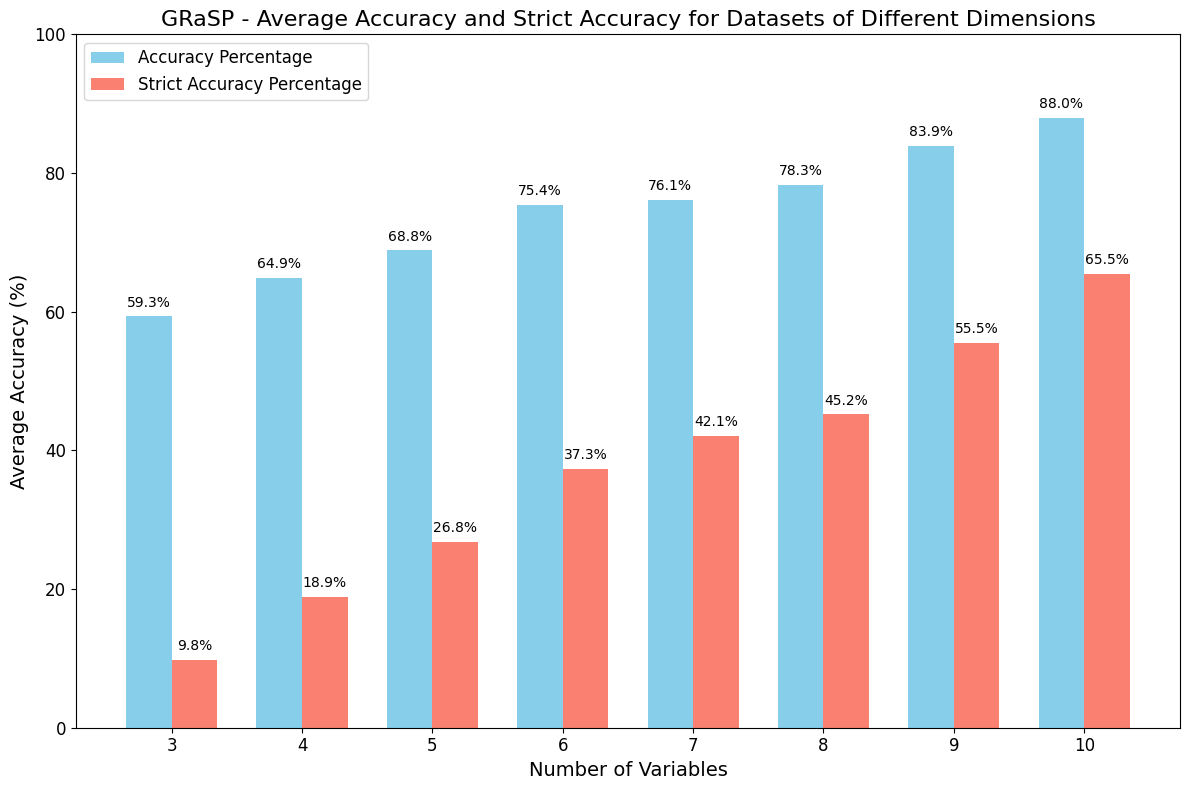

In [21]:
plot_average_accuracy(evaluation_results, 'GRaSP')

## 处理nolinear-ExactSearch

In [14]:
X_y_group_train = pd.read_csv('./mid_data/X_y_group_train_updated_v9.3_PC+ES-more.csv')
print(X_y_group_train.shape)
print(X_y_group_train.columns)

(142910, 86)
Index(['dataset', 'variable', 'dimension', 'corr(v,X)', 'corr(v,Y)',
       'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))',
       'std(corr(v, others))', 'corr(X,Y)', 'ttest(v,X)',
       'pvalue(ttest(v,X))<=0.05', 'ttest(v,Y)', 'pvalue(ttest(v,Y))<=0.05',
       'ttest(X,Y)', 'pvalue(ttest(X,Y))<=0.05', 'MI(v,X)', 'MI(v,Y)',
       'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))',
       'std(MI(v, others))', 'MI(X,Y)', 'label', 'y', 'spearman_corr(v,X)',
       'spearman_corr(v,Y)', 'spearman_corr(X,Y)', 'kendall_corr(v,X)',
       'kendall_corr(v,Y)', 'kendall_corr(X,Y)', 'dcor(v,X)', 'dcor(v,Y)',
       'dcor(X,Y)', 'MI(v,X)^2', 'MI(v,Y)^2', 'MI(X,Y)^2',
       'max(MI(v, others))^2', 'min(MI(v, others))^2', 'conditional_MI(v,X|Y)',
       'conditional_MI(v,Y|X)', 'conditional_MI(X,Y|v)', 'square_dimension',
       'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))',
       'mean(spearman_corr(v, others))', 'std(

In [15]:
"""
'ExactSearch(v-sq,X)', 'ExactSearch(X,v-sq)', 'ExactSearch(v-sq,Y)', 'ExactSearch(Y,v-sq)',
'ExactSearch(v-cos,X)', 'ExactSearch(X,v-cos)', 'ExactSearch(v-cos,Y)', 'ExactSearch(Y,v-cos)', 
'ExactSearch(v-sin,X)', 'ExactSearch(X,v-sin)', 'ExactSearch(v-sin,Y)', 'ExactSearch(Y,v-sin)'
----->>>
'ExactSearch(v-nolinear,X)', 'ExactSearch(X,v-nolinear)', 'ExactSearch(v-nolinear,Y)', 'ExactSearch(Y,v-nolinear)'
"""
# 定义旧列名到新列名的映射
column_mapping = {
    'ExactSearch(v-nonlinear,X)': [
        'ExactSearch(v-sq,X)', 
        'ExactSearch(v-cos,X)', 
        'ExactSearch(v-sin,X)'
    ],
    'ExactSearch(X,v-nonlinear)': [
        'ExactSearch(X,v-sq)', 
        'ExactSearch(X,v-cos)', 
        'ExactSearch(X,v-sin)'
    ],
    'ExactSearch(v-nonlinear,Y)': [
        'ExactSearch(v-sq,Y)', 
        'ExactSearch(v-cos,Y)', 
        'ExactSearch(v-sin,Y)'
    ],
    'ExactSearch(Y,v-nonlinear)': [
        'ExactSearch(Y,v-sq)', 
        'ExactSearch(Y,v-cos)', 
        'ExactSearch(Y,v-sin)'
    ],
}
# 使用 .any(axis=1) 检查每行是否有任意一列为1
for new_col, old_cols in column_mapping.items():
    # 检查所有旧列是否存在于DataFrame中
    missing_cols = set(old_cols) - set(X_y_group_train.columns)
    if missing_cols:
        print(f"警告: 以下列不存在于DataFrame中并将被忽略: {missing_cols}")
        # 仅使用存在的列
        old_cols = [col for col in old_cols if col in X_y_group_train.columns]
    
    # 创建新列
    X_y_group_train[new_col] = X_y_group_train[old_cols].any(axis=1).astype(int)

In [16]:
# 收集所有旧列名
all_old_cols = [col for cols in column_mapping.values() for col in cols]

# 删除旧列（只删除存在于DataFrame中的列）
cols_to_drop = [col for col in all_old_cols if col in X_y_group_train.columns]
X_y_group_train = X_y_group_train.drop(columns=cols_to_drop)
X_y_group_train.to_csv('./mid_data/X_y_group_train_updated_v9.3_PC+ES-merge.csv', index=False)

: 

## psm

In [1]:
"""源代码"""
import pandas as pd
import numpy as np

##################################################################
###################  Utility/Helper Functions  ###################
##################################################################

def get_propensity_scores(model, data, verbose = False):
    '''
    基于指定的逻辑回归模型计算倾向评分

    Parameters
    ----------
    model : string
        a model specification in the form Y ~ X1 + X2 + ... + Xn
    data : Pandas DataFrame
        the data used to calculate propensity scores
    verbose : boolean
        verbosity of the model output

    Returns
    -------
    An array of propensity scores.
    '''
    import statsmodels.api as sm
    glm_binom = sm.formula.glm(formula = model, data = data, family = sm.families.Binomial())
    result = glm_binom.fit()
    if verbose:
        print(result.summary)
    return result.fittedvalues

def get_matched_data(match_ids, raw_data):
    '''
    Subsets the raw data to include data only from the treated cases and
    their respective matched control(s).

    Parameters
    ----------
    match_ids : Pandas DataFrame
        a dataframe of treated case IDs and matched control(s)
    raw_data: Pandas DataFrame
        a dataframe of all of the raw data

    Returns
    -------
    A dataframe containing data only from treated cases and matched control(s).
    '''
    match_ids = flatten_match_ids(match_ids)
    matched_data = raw_data[raw_data.index.isin(match_ids)]
    return matched_data

def make_crosstable(df, var):
    '''
    Makes a frequency-count crosstable for use in chi-square testing.

    Parameters
    ----------
    df : Pandas DataFrame
        a dataframe containing data to be analyzed
    var : string
        the variable to be analyzed

    Returns
    -------
    A Pandas Crosstable object.
    '''
    crosstable = pd.crosstab(df["CASE"], df[var])
    return crosstable

def calc_chi2_2x2(crosstable):
    '''
    Calculates the chi-square statistic, df, and p-value for a 2x2 table.

    Parameters
    ----------
    crosstable : Pandas CrossTab
        the object returned by the make_crosstable() function

    Returns
    -------
    An array containing the resulting chi-square statistic, df, and p-value.
    '''
    from scipy.stats import chi2_contingency
    f_obs = np.array([crosstable.iloc[0][0:2].values,
                      crosstable.iloc[1][0:2].values])
    result = chi2_contingency(f_obs)[0:3]
    round_result = (round(i,4) for i in result)
    return list(round_result)

def calc_chi2_2xC(crosstable):
    '''
    Calculates the chi-square statistic, df, and p-value for a 2xC table.

    Parameters
    ----------
    crosstable : Pandas CrossTab
        the object returned by the make_crosstable() function

    Returns
    -------
    An array containing the resulting chi-square statistic, df, and p-value.
    '''
    from scipy.stats import chi2_contingency
    C = crosstable.shape[1]
    f_obs = np.array([crosstable.iloc[0][0:C].values,
                      crosstable.iloc[1][0:C].values])
    result = chi2_contingency(f_obs)[0:3]
    round_result = (round(i,4) for i in result)
    return list(round_result)

def flatten_match_ids(df):
    '''
    Converts a Pandas DataFrame of matched IDs into a list of those IDs.

    Parameters
    ----------
    df : Pandas Dataframe
        a dataframe consisting of 1 column of treated/case IDs and n columns
        of respective control(s) matched

    Returns
    -------
    A list of treated case and matched control IDs.
    '''
    master_list = []
    master_list.append(df[df.columns[0]].tolist())
    for i in range(1, df.shape[1]):
        master_list.append(df[df.columns[i]].tolist())
    master_list = [item for sublist in master_list for item in sublist]
    return master_list

def write_matched_data(path, df):
    '''
    Writes matched data to file.

    Parameters
    ----------
    path : string
        a file path used to derive the saved file path
    df : Pandas Dataframe
        the dataframe to be written to file.
    '''
    print("Writing matched data to file ...", end = " ")
    save_file = path.split(".")[0] + "_matched_ps.csv"
    df.to_csv(save_file, index = False)
    print("DONE!")
    print()

####################################################
###################  Base Class  ###################
####################################################

class PSMatch(object):
    '''
    Parameters
    ----------
    file : string
        The file path of the data; assumed to be in .csv format.
    model : string
        The model specification for calculating propensity scores; in the format Y ~ X1 + X2 + ... + Xn
    k : string
        The number of controls to be matched to each treated case.
    '''

    def __init__(self, path, model, k):
        self.path = path
        self.model = model
        self.k = int(k)


    def prepare_data(self, **kwargs):
        '''
        Prepares the data for matching.

        Parameters
        ----------
        path : string
            The file path of the data to be analyzed. Assumed to be in .csv format.

        Returns
        -------
        A Pandas DataFrame containing raw data plus a column of propensity scores.
        '''
        # Read in the data specified by the file path
        df = pd.read_csv(self.path)
        df = df.set_index("OPTUM_LAB_ID")
        # Obtain propensity scores and add them to the data
        print("\nCalculating propensity scores ...", end = " ")
        propensity_scores = get_propensity_scores(model = self.model, data = df, verbose = False)
        print("DONE!")
        print("Preparing data ...", end = " ")
        df["PROPENSITY"] = propensity_scores
        # Assign the df attribute to the Match object
        self.df = df
        print("DONE!")


    def match(self, caliper = None, replace = False, **kwargs):
        '''
        Performs propensity score matching.

        Parameters
        ----------
        df : Pandas DataFrame
            the attribute returned by the prepare_data() function

        Returns
        -------
        matches : Pandas DataFrame
            the Match object attribute describing which control IDs are matched
            to a particular treatment case.
        matched_data: Pandas DataFrame
            the Match object attribute containing the raw data for only treatment
            cases and their matched controls.
        '''
        # Assert that the Match object has a df attribute
        if not hasattr(self, 'df'):
            raise AttributeError("%s does not have a 'df' attribute." % (self))

        # Assign treatment group membership
        groups = self.df.CASE
        propensity = self.df.PROPENSITY
        groups = groups == groups.unique()[1]
        n = len(groups)
        n1 = groups[groups==1].sum()
        n2 = n-n1
        g1, g2 = propensity[groups==1], propensity[groups==0]

        if n1 > n2:
            n1, n2, g1, g2 = n2, n1, g2, g1

        # Randomly permute the treatment case IDs
        m_order = list(np.random.permutation(groups[groups==1].index))
        matches = {}
        k = int(self.k)

        # Match treatment cases to controls based on propensity score differences
        print("\nMatching [" + str(k) + "] controls to each case ... ", end = " ")
        for m in m_order:
            # Calculate all propensity score differences
            dist = abs(g1[m]-g2)
            array = np.array(dist)
            # Choose the k smallest differences
            k_smallest = np.partition(array, k)[:k].tolist()
            if caliper:
                caliper = float(caliper)
                keep_diffs = [i for i in k_smallest if i <= caliper]
                keep_ids = np.array(dist[dist.isin(keep_diffs)].index)
            else:
                keep_ids = np.array(dist[dist.isin(k_smallest)].index)

            # Break ties via random choice, if ties are present
            if len(keep_ids) > k:
                matches[m] = list(np.random.choice(keep_ids, k, replace=False))
            elif len(keep_ids) < k:
                while len(matches[m]) <= k:
                    matches[m].append("NA")
            else:
                matches[m] = keep_ids.tolist()

            # Matches are made without replacement
            if not replace:
                g2 = g2.drop(matches[m])

        # Prettify the results by consolidating into a DataFrame
        matches = pd.DataFrame.from_dict(matches, orient="index")
        matches = matches.reset_index()
        column_names = {}
        column_names["index"] = "CASE_ID"
        for i in range(k):
            column_names[i] = str("CONTROL_MATCH_" + str(i+1))
        matches = matches.rename(columns = column_names)

        # Extract data only for treated cases and matched controls
        matched_data = get_matched_data(matches, self.df)
        print("DONE!")
        write_matched_data(self.path, self.df)

        # Assign the matches and matched_data attributes to the Match object
        self.matches = matches
        self.matched_data = matched_data


    def evaluate(self, **kwargs):
        '''
        Conducts chi-square tests to verify statistically that the cases/controls
        are well-matched on the variables of interest.
        '''
        # Assert that the Match object has 'matches' and 'matched_data' attributes
        if not hasattr(self, 'matches'):
            raise AttributeError("%s does not have a 'matches' attribute." % (self))
        if not hasattr(self, 'matched_data'):
            raise AttributeError("%s does not have a 'matched_data' attribute." % (self))

        # Get variables of interest for analysis
        variables = self.df.columns.tolist()[0:-2]
        results = {}
        print("Evaluating matches ...")

        # Evaluate case/control match for each variable of interest
        for var in variables:
            crosstable = make_crosstable(self.df, var)
            if len(self.df[var].unique().tolist()) <= 2:
                p_val = calc_chi2_2x2(crosstable)[1]
            else:
                p_val = calc_chi2_2xC(crosstable)[1]
            results[var] = p_val
            print("\t" + var, end = "")
            if p_val < 0.05:
                print(": FAILED")
            else:
                print(": PASSED")

        if True in [i < 0.05 for i in results.values()]:
            print("\nAt least one variable failed to match!")
            return False
        else:
            print("\nAll variables were successfully matched!")
            return True


    def run(self, **kwargs):
        self.prepare_data()
        self.match()
        self.evaluate()

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import statsmodels.api as sm

##################################################################
###################  Utility/Helper Functions  ###################
##################################################################

def get_propensity_scores(model, data, verbose=False):
    '''
    使用线性回归框架计算连续处理的广义倾向得分
    
    Parameters
    ----------
    model : string
        a model specification in the form Treatment ~ X1 + X2 + ... + Xn
    data : Pandas DataFrame
        the data used to calculate propensity scores

    Returns
    -------
    预测的处理值数组(广义倾向得分)
    '''
    # 使用线性回归模型预测处理程度
    linear_model = sm.formula.ols(formula=model, data=data)
    result = linear_model.fit()
    if verbose:
        print(result.summary())
    return result.fittedvalues

def get_matched_data(match_ids, raw_data):
    '''
    从原始数据中提取处理组案例和对应的匹配对照组数据

    Parameters
    ----------
    match_ids : Pandas DataFrame 
        a dataframe of treated case IDs and matched control(s)
    raw_data: Pandas DataFrame 
        a dataframe of all of the raw data

    Returns
    -------
    仅包含处理组案例和匹配对照组数据的数据框
    '''
    match_ids = flatten_match_ids(match_ids)
    matched_data = raw_data[raw_data.index.isin(match_ids)]
    return matched_data

def flatten_match_ids(df):
    '''
    将匹配ID的数据框转换为ID列表

    Parameters
    ----------
    df : Pandas Dataframe
        a dataframe consisting of 1 column of treated/case IDs and n columns of respective control(s) matched

    Returns
    -------
    处理组和匹配对照组ID的列表
    '''
    master_list = []
    master_list.append(df[df.columns[0]].tolist())
    for i in range(1, df.shape[1]):
        master_list.append(df[df.columns[i]].tolist())
    master_list = [item for sublist in master_list for item in sublist]
    return master_list

def write_matched_data(path, df):
    '''
    将匹配数据写入文件

    Parameters
    ----------
    path : string
        a file path used to derive the saved file path
    df : Pandas Dataframe
        the dataframe to be written to file.
    '''
    print("Writing matched data to file ...", end=" ")
    save_file = path.split(".")[0] + "_matched_ps.csv"
    df.to_csv(save_file, index=False)
    print("DONE!")
    print()

def calc_standardized_mean_diff(df, var):
    '''
    计算处理组和对照组之间指定变量的标准化均值差(SMD)

    Parameters
    ----------
    df : Pandas DataFrame
        the dataframe containing matched data
    var : string
        the variable to calculate SMD for

    Returns
    -------
    表示SMD的浮点数
    '''
    treated = df[df['CASE'] == 1][var]
    control = df[df['CASE'] == 0][var]
    mean_treated = treated.mean()
    mean_control = control.mean()
    std_pooled = np.sqrt((treated.std()**2 + control.std()**2) / 2)
    smd = (mean_treated - mean_control) / std_pooled
    return smd

def calc_p_value_ttest(df, var):
    '''
    对处理组和对照组之间的指定变量执行独立t检验

    Parameters
    ----------
    df : Pandas DataFrame
        the dataframe containing matched data
    var : string
        the variable to perform t-test on

    Returns
    -------
    t检验的p值
    '''
    treated = df[df['CASE'] == 1][var]
    control = df[df['CASE'] == 0][var]
    stat, p_val = ttest_ind(treated, control, equal_var=False)
    return round(p_val, 4)

####################################################
###################  Base Class  ###################
####################################################

class PSMatch(object):
    '''
    Parameters
    ----------
    file : string
        The file path of the data; assumed to be in .csv format.
    model : string
        The model specification for calculating generalized propensity scores; in the format Treatment ~ X1 + X2 + ... + Xn
    k : int
        The number of controls to be matched to each treated case.
    '''
    def __init__(self, path, model, k):
        self.path = path
        self.model = model
        self.k = int(k)

    def prepare_data(self, **kwargs):
        '''
        Prepares the data for matching.

        Parameters
        ----------
        path : string
            The file path of the data to be analyzed. Assumed to be in .csv format.

        Returns
        -------
        A Pandas DataFrame containing raw data plus a column of generalized propensity scores.
        '''
        # Read in the data specified by the file path
        df = pd.read_csv(self.path)
        df = df.set_index("OPTUM_LAB_ID")
        # Obtain generalized propensity scores and add them to the data
        print("\nCalculating generalized propensity scores ...", end=" ")
        propensity_scores = get_propensity_scores(model=self.model, data=df, verbose=False)
        print("DONE!")
        print("Preparing data ...", end=" ")
        df["PROPENSITY"] = propensity_scores
        # Assign the df attribute to the Match object
        self.df = df
        print("DONE!")

    def match(self, caliper=None, replace=False, **kwargs):
        '''
        Performs generalized propensity score matching.

        Parameters
        ----------
        caliper : float, optional
            The maximum allowed difference in propensity scores for matching.
        replace : boolean, default=False
            Whether to allow a control unit to be matched to multiple treated units.
        **kwargs
            Additional arguments.

        Returns
        -------
        matches : Pandas DataFrame
            the Match object attribute describing which control IDs are matched
            to a particular treatment case.
        matched_data: Pandas DataFrame
            the Match object attribute containing the raw data for only treatment
            cases and their matched controls.
        '''
        # Assert that the Match object has a df attribute
        if not hasattr(self, 'df'):
            raise AttributeError(f"{self} does not have a 'df' attribute.")

        # Assign treatment and covariate information
        treatment = self.df['CASE']
        propensity = self.df['PROPENSITY']

        # Assume 'CASE' now represents the continuous treatment variable
        # Define treated as the actual treatment level
        treated = self.df.copy()
        treated['TREATMENT'] = treated['CASE']

        # Initialize matches dictionary
        matches = {}

        # Extract treated and control units
        # Since treatment is continuous, we'll treat everyone as both treated and control
        # and find matches based on proximity in treatment and covariates

        # To simplify, consider each unit as a "treated" unit and find k nearest neighbors
        # Excluding itself in matching

        # Precompute available control units
        control_available = treated.copy()

        # Extract covariate names (excluding 'CASE' and 'PROPENSITY')
        covariates = self.df.columns.tolist()
        covariates.remove('CASE')
        covariates.remove('PROPENSITY')

        # Create a matrix for covariates
        X = self.df[covariates].values
        treatment_values = self.df['CASE'].values

        # Precompute for efficiency
        from sklearn.neighbors import NearestNeighbors

        # Define number of controls to match
        k = self.k

        # Initialize NearestNeighbors
        neigh = NearestNeighbors(n_neighbors=k, metric='euclidean')
        neigh.fit(X)

        print(f"\nMatching [{k}] nearest neighbors based on covariates ... ", end="")
        distances, indices = neigh.kneighbors(X, n_neighbors=k, return_distance=True)

        # Assign matches
        for idx, neighbors in enumerate(indices):
            # Exclude the unit itself if present
            neighbors = neighbors[neighbors != idx]
            # If less than k neighbors after excluding itself, pad with 'NA'
            if len(neighbors) < k:
                chosen_controls = list(neighbors) + ["NA"] * (k - len(neighbors))
            else:
                chosen_controls = neighbors[:k].tolist()
            matches[self.df.index[idx]] = chosen_controls

        # Convert matches to DataFrame
        matches_df = pd.DataFrame.from_dict(matches, orient="index")
        matches_df = matches_df.reset_index()
        column_names = {"index": "CASE_ID"}
        for i in range(k):
            column_names[i] = f"CONTROL_MATCH_{i+1}"
        matches_df = matches_df.rename(columns=column_names)

        # Extract matched data
        matched_ids = flatten_match_ids(matches_df)
        matched_data = self.df[self.df.index.isin(matched_ids)]

        print("DONE!")
        write_matched_data(self.path, matched_data)

        # Assign the matches and matched_data attributes to the Match object
        self.matches = matches_df
        self.matched_data = matched_data

    def evaluate(self, method='smd', threshold=0.1, **kwargs):
        '''
        Conducts balance assessments to verify that the cases/controls
        are well-matched on the variables of interest.

        Parameters
        ----------
        method : string
            The method to evaluate balance. Options: 'smd' (Standardized Mean Difference),
            'ttest' (Independent T-Test)
        threshold : float
            The threshold for the balance metric. For SMD, common thresholds are 0.1 or 0.2.

        Returns
        -------
        A boolean indicating whether all variables passed the balance assessment.
        '''

        # Assert that the Match object has 'matches' and 'matched_data' attributes
        if not hasattr(self, 'matches'):
            raise AttributeError(f"{self} does not have a 'matches' attribute.")
        if not hasattr(self, 'matched_data'):
            raise AttributeError(f"{self} does not have a 'matched_data' attribute.")

        # Get variables of interest for analysis (exclude 'PROPENSITY' and 'CASE')
        variables = self.df.columns.tolist()
        variables.remove('PROPENSITY')
        variables.remove('CASE')

        results = {}
        print("Evaluating matches ...")

        # Evaluate case/control match for each variable of interest
        for var in variables:
            if method == 'smd':
                smd = calc_standardized_mean_diff(self.matched_data, var)
                results[var] = smd
                print(f"\t{var}: SMD = {smd:.4f}", end="")
                if abs(smd) > threshold:
                    print(" --> FAILED")
                else:
                    print(" --> PASSED")
            elif method == 'ttest':
                p_val = calc_p_value_ttest(self.matched_data, var)
                results[var] = p_val
                print(f"\t{var}: p-value = {p_val}", end="")
                if p_val < 0.05:
                    print(" --> FAILED")
                else:
                    print(" --> PASSED")
            else:
                raise ValueError("Unsupported evaluation method. Choose 'smd' or 'ttest'.")

        if method == 'smd':
            failed = [var for var, value in results.items() if abs(value) > threshold]
        elif method == 'ttest':
            failed = [var for var, value in results.items() if value < 0.05]

        if failed:
            print("\n\nThe following variables failed the balance assessment:")
            for var in failed:
                print(f"\t- {var}")
            return False
        else:
            print("\n\nAll variables passed the balance assessment!")
            return True

    def run(self, **kwargs):
        self.prepare_data()
        self.match(**kwargs)
        self.evaluate(**kwargs)

## PPS

In [2]:
"""PPS"""

import numpy as np

from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, f1_score

import pandas as pd
from pandas.api.types import (
    is_numeric_dtype,
    is_bool_dtype,
    is_object_dtype,
    is_categorical_dtype,
    is_string_dtype,
    is_datetime64_any_dtype,
    is_timedelta64_dtype,
)


NOT_SUPPORTED_ANYMORE = "NOT_SUPPORTED_ANYMORE"
TO_BE_CALCULATED = -1


def _calculate_model_cv_score_(
    df, target, feature, task, cross_validation, random_seed, **kwargs
):
    "Calculates the mean model score based on cross-validation"
    # Sources about the used methods:
    # https://scikit-learn.org/stable/modules/tree.html
    # https://scikit-learn.org/stable/modules/cross_validation.html
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
    metric = task["metric_key"]
    model = task["model"]
    # shuffle the rows - this is important for cross-validation
    # because the cross-validation just takes the first n lines
    # if there is a strong pattern in the rows eg 0,0,0,0,1,1,1,1
    # then this will lead to problems because the first cv sees mostly 0 and the later 1
    # this approach might be wrong for timeseries because it might leak information
    df = df.sample(frac=1, random_state=random_seed, replace=False)

    # preprocess target
    if task["type"] == "classification":
        label_encoder = preprocessing.LabelEncoder()
        df[target] = label_encoder.fit_transform(df[target])
        target_series = df[target]
    else:
        target_series = df[target]

    # preprocess feature
    if _dtype_represents_categories(df[feature]):
        one_hot_encoder = preprocessing.OneHotEncoder()
        array = df[feature].__array__()
        sparse_matrix = one_hot_encoder.fit_transform(array.reshape(-1, 1))
        feature_input = sparse_matrix
    else:
        # reshaping needed because there is only 1 feature
        array = df[feature].values
        if not isinstance(array, np.ndarray):  # e.g Int64 IntegerArray
            array = array.to_numpy()
        feature_input = array.reshape(-1, 1)

    # Cross-validation is stratifiedKFold for classification, KFold for regression
    # CV on one core (n_job=1; default) has shown to be fastest
    scores = cross_val_score(
        model, feature_input, target_series.to_numpy(), cv=cross_validation, scoring=metric
    )

    return scores.mean()


def _normalized_mae_score(model_mae, naive_mae):
    "Normalizes the model MAE score, given the baseline score"
    # # Value range of MAE is [0, infinity), 0 is best
    # 10, 5 ==> 0 because worse than naive
    # 10, 20 ==> 0.5
    # 5, 20 ==> 0.75 = 1 - (mae/base_mae)
    if model_mae > naive_mae:
        return 0
    else:
        return 1 - (model_mae / naive_mae)


def _mae_normalizer(df, y, model_score, **kwargs):
    "In case of MAE, calculates the baseline score for y and derives the PPS."
    df["naive"] = df[y].median()
    baseline_score = mean_absolute_error(df[y].to_numpy(), df["naive"].to_numpy())  # true, pred

    ppscore = _normalized_mae_score(abs(model_score), baseline_score)
    return ppscore, baseline_score


def _normalized_f1_score(model_f1, baseline_f1):
    "Normalizes the model F1 score, given the baseline score"
    # # F1 ranges from 0 to 1
    # # 1 is best
    # 0.5, 0.7 ==> 0 because model is worse than naive baseline
    # 0.75, 0.5 ==> 0.5
    #
    if model_f1 < baseline_f1:
        return 0
    else:
        scale_range = 1.0 - baseline_f1  # eg 0.3
        f1_diff = model_f1 - baseline_f1  # eg 0.1
        return f1_diff / scale_range  # 0.1/0.3 = 0.33


def _f1_normalizer(df, y, model_score, random_seed):
    "In case of F1, calculates the baseline score for y and derives the PPS."
    label_encoder = preprocessing.LabelEncoder()
    df["truth"] = label_encoder.fit_transform(df[y])
    df["most_common_value"] = df["truth"].value_counts().index[0]
    random = df["truth"].sample(frac=1, random_state=random_seed)

    baseline_score = max(
        f1_score(df["truth"], df["most_common_value"], average="weighted"),
        f1_score(df["truth"], random, average="weighted"),
    )

    ppscore = _normalized_f1_score(model_score, baseline_score)
    return ppscore, baseline_score


VALID_CALCULATIONS = {
    "regression": {
        "type": "regression",
        "is_valid_score": True,
        "model_score": TO_BE_CALCULATED,
        "baseline_score": TO_BE_CALCULATED,
        "ppscore": TO_BE_CALCULATED,
        "metric_name": "mean absolute error",
        "metric_key": "neg_mean_absolute_error",
        "model": tree.DecisionTreeRegressor(),
        "score_normalizer": _mae_normalizer,
    },
    "classification": {
        "type": "classification",
        "is_valid_score": True,
        "model_score": TO_BE_CALCULATED,
        "baseline_score": TO_BE_CALCULATED,
        "ppscore": TO_BE_CALCULATED,
        "metric_name": "weighted F1",
        "metric_key": "f1_weighted",
        "model": tree.DecisionTreeClassifier(),
        "score_normalizer": _f1_normalizer,
    },
    "predict_itself": {
        "type": "predict_itself",
        "is_valid_score": True,
        "model_score": 1,
        "baseline_score": 0,
        "ppscore": 1,
        "metric_name": None,
        "metric_key": None,
        "model": None,
        "score_normalizer": None,
    },
    "target_is_constant": {
        "type": "target_is_constant",
        "is_valid_score": True,
        "model_score": 1,
        "baseline_score": 1,
        "ppscore": 0,
        "metric_name": None,
        "metric_key": None,
        "model": None,
        "score_normalizer": None,
    },
    "target_is_id": {
        "type": "target_is_id",
        "is_valid_score": True,
        "model_score": 0,
        "baseline_score": 0,
        "ppscore": 0,
        "metric_name": None,
        "metric_key": None,
        "model": None,
        "score_normalizer": None,
    },
    "feature_is_id": {
        "type": "feature_is_id",
        "is_valid_score": True,
        "model_score": 0,
        "baseline_score": 0,
        "ppscore": 0,
        "metric_name": None,
        "metric_key": None,
        "model": None,
        "score_normalizer": None,
    },
}

INVALID_CALCULATIONS = [
    "target_is_datetime",
    "target_data_type_not_supported",
    "empty_dataframe_after_dropping_na",
    "unknown_error",
]


def _dtype_represents_categories(series) -> bool:
    "Determines if the dtype of the series represents categorical values"
    return (
        is_bool_dtype(series)
        or is_object_dtype(series)
        or is_string_dtype(series)
        or is_categorical_dtype(series)
    )


def _determine_case_and_prepare_df(df, x, y, sample=5_000, random_seed=123):
    "Returns str with the name of the determined case based on the columns x and y"
    if x == y:
        return df, "predict_itself"

    df = df[[x, y]]
    # IDEA: log.warning when values have been dropped
    df = df.dropna()

    if len(df) == 0:
        return df, "empty_dataframe_after_dropping_na"
        # IDEA: show warning
        # raise Exception(
        #     "After dropping missing values, there are no valid rows left"
        # )

    df = _maybe_sample(df, sample, random_seed=random_seed)

    if _feature_is_id(df, x):
        return df, "feature_is_id"

    category_count = df[y].value_counts().count()
    if category_count == 1:
        # it is helpful to separate this case in order to save unnecessary calculation time
        return df, "target_is_constant"
    if _dtype_represents_categories(df[y]) and (category_count == len(df[y])):
        # it is important to separate this case in order to save unnecessary calculation time
        return df, "target_is_id"

    if _dtype_represents_categories(df[y]):
        return df, "classification"
    if is_numeric_dtype(df[y]):
        # this check needs to be after is_bool_dtype (which is part of _dtype_represents_categories) because bool is considered numeric by pandas
        return df, "regression"

    if is_datetime64_any_dtype(df[y]) or is_timedelta64_dtype(df[y]):
        # IDEA: show warning
        # raise TypeError(
        #     f"The target column {y} has the dtype {df[y].dtype} which is not supported. A possible solution might be to convert {y} to a string column"
        # )
        return df, "target_is_datetime"

    # IDEA: show warning
    # raise Exception(
    #     f"Could not infer a valid task based on the target {y}. The dtype {df[y].dtype} is not yet supported"
    # )  # pragma: no cover
    return df, "target_data_type_not_supported"


def _feature_is_id(df, x):
    "Returns Boolean if the feature column x is an ID"
    if not _dtype_represents_categories(df[x]):
        return False

    category_count = df[x].value_counts().count()
    return category_count == len(df[x])


def _maybe_sample(df, sample, random_seed=None):
    """
    Maybe samples the rows of the given df to have at most `sample` rows
    If sample is `None` or falsy, there will be no sampling.
    If the df has fewer rows than the sample, there will be no sampling.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe that might be sampled
    sample : int or `None`
        Number of rows to be sampled
    random_seed : int or `None`
        Random seed that is forwarded to pandas.DataFrame.sample as `random_state`

    Returns
    -------
    pandas.DataFrame
        DataFrame after potential sampling
    """
    if sample and len(df) > sample:
        # this is a problem if x or y have more than sample=5000 categories
        # TODO: dont sample when the problem occurs and show warning
        df = df.sample(sample, random_state=random_seed, replace=False)
    return df


def _is_column_in_df(column, df):
    try:
        return column in df.columns
    except:
        return False


def _score(
    df, x, y, task, sample, cross_validation, random_seed, invalid_score, catch_errors
):
    df, case_type = _determine_case_and_prepare_df(
        df, x, y, sample=sample, random_seed=random_seed
    )
    task = _get_task(case_type, invalid_score)

    if case_type in ["classification", "regression"]:
        model_score = _calculate_model_cv_score_(
            df,
            target=y,
            feature=x,
            task=task,
            cross_validation=cross_validation,
            random_seed=random_seed,
        )
        # IDEA: the baseline_scores do sometimes change significantly, e.g. for F1 and thus change the PPS
        # we might want to calculate the baseline_score 10 times and use the mean in order to have less variance
        ppscore, baseline_score = task["score_normalizer"](
            df, y, model_score, random_seed=random_seed
        )
    else:
        model_score = task["model_score"]
        baseline_score = task["baseline_score"]
        ppscore = task["ppscore"]

    return {
        "x": x,
        "y": y,
        "ppscore": ppscore,
        "case": case_type,
        "is_valid_score": task["is_valid_score"],
        "metric": task["metric_name"],
        "baseline_score": baseline_score,
        "model_score": abs(model_score),  # sklearn returns negative mae
        "model": task["model"],
    }


def pps_score(
    df,
    x,
    y,
    task=NOT_SUPPORTED_ANYMORE,
    sample=5_000,
    cross_validation=4,
    random_seed=123,
    invalid_score=0,
    catch_errors=True,
):
    """
    Calculate the Predictive Power Score (PPS) for "x predicts y"
    The score always ranges from 0 to 1 and is data-type agnostic.

    A score of 0 means that the column x cannot predict the column y better than a naive baseline model.
    A score of 1 means that the column x can perfectly predict the column y given the model.
    A score between 0 and 1 states the ratio of how much potential predictive power the model achieved compared to the baseline model.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe that contains the columns x and y
    x : str
        Name of the column x which acts as the feature
    y : str
        Name of the column y which acts as the target
    sample : int or `None`
        Number of rows for sampling. The sampling decreases the calculation time of the PPS.
        If `None` there will be no sampling.
    cross_validation : int
        Number of iterations during cross-validation. This has the following implications:
        For example, if the number is 4, then it is possible to detect patterns when there are at least 4 times the same observation. If the limit is increased, the required minimum observations also increase. This is important, because this is the limit when sklearn will throw an error and the PPS cannot be calculated
    random_seed : int or `None`
        Random seed for the parts of the calculation that require random numbers, e.g. shuffling or sampling.
        If the value is set, the results will be reproducible. If the value is `None` a new random number is drawn at the start of each calculation.
    invalid_score : any
        The score that is returned when a calculation is invalid, e.g. because the data type was not supported.
    catch_errors : bool
        If `True` all errors will be catched and reported as `unknown_error` which ensures convenience. If `False` errors will be raised. This is helpful for inspecting and debugging errors.

    Returns
    -------
    Dict
        A dict that contains multiple fields about the resulting PPS.
        The dict enables introspection into the calculations that have been performed under the hood
    """

    if not isinstance(df, pd.DataFrame):
        raise TypeError(
            f"The 'df' argument should be a pandas.DataFrame but you passed a {type(df)}\nPlease convert your input to a pandas.DataFrame"
        )
    if not _is_column_in_df(x, df):
        raise ValueError(
            f"The 'x' argument should be the name of a dataframe column but the variable that you passed is not a column in the given dataframe.\nPlease review the column name or your dataframe"
        )
    if len(df[[x]].columns) >= 2:
        raise AssertionError(
            f"The dataframe has {len(df[[x]].columns)} columns with the same column name {x}\nPlease adjust the dataframe and make sure that only 1 column has the name {x}"
        )
    if not _is_column_in_df(y, df):
        raise ValueError(
            f"The 'y' argument should be the name of a dataframe column but the variable that you passed is not a column in the given dataframe.\nPlease review the column name or your dataframe"
        )
    if len(df[[y]].columns) >= 2:
        raise AssertionError(
            f"The dataframe has {len(df[[y]].columns)} columns with the same column name {y}\nPlease adjust the dataframe and make sure that only 1 column has the name {y}"
        )
    if task is not NOT_SUPPORTED_ANYMORE:
        raise AttributeError(
            "The attribute 'task' is no longer supported because it led to confusion and inconsistencies.\nThe task of the model is now determined based on the data types of the columns. If you want to change the task please adjust the data type of the column.\nFor more details, please refer to the README"
        )

    if random_seed is None:
        from random import random

        random_seed = int(random() * 1000)

    try:
        return _score(
            df,
            x,
            y,
            task,
            sample,
            cross_validation,
            random_seed,
            invalid_score,
            catch_errors,
        )
    except Exception as exception:
        if catch_errors:
            case_type = "unknown_error"
            task = _get_task(case_type, invalid_score)
            return {
                "x": x,
                "y": y,
                "ppscore": task["ppscore"],
                "case": case_type,
                "is_valid_score": task["is_valid_score"],
                "metric": task["metric_name"],
                "baseline_score": task["baseline_score"],
                "model_score": task["model_score"],  # sklearn returns negative mae
                "model": task["model"],
            }
        else:
            raise exception


def _get_task(case_type, invalid_score):
    if case_type in VALID_CALCULATIONS.keys():
        return VALID_CALCULATIONS[case_type]
    elif case_type in INVALID_CALCULATIONS:
        return {
            "type": case_type,
            "is_valid_score": False,
            "model_score": invalid_score,
            "baseline_score": invalid_score,
            "ppscore": invalid_score,
            "metric_name": None,
            "metric_key": None,
            "model": None,
            "score_normalizer": None,
        }
    raise Exception(f"case_type {case_type} is not supported")


def _format_list_of_dicts(scores, output, sorted):
    """
    Format list of score dicts `scores`
    - maybe sort by ppscore
    - maybe return pandas.Dataframe
    - output can be one of ["df", "list"]
    """
    if sorted:
        scores.sort(key=lambda item: item["ppscore"], reverse=True)

    if output == "df":
        df_columns = [
            "x",
            "y",
            "ppscore",
            "case",
            "is_valid_score",
            "metric",
            "baseline_score",
            "model_score",
            "model",
        ]
        data = {column: [score[column] for score in scores] for column in df_columns}
        scores = pd.DataFrame.from_dict(data)

    return scores


def pps_predictors(df, y, output="df", sorted=True, **kwargs):
    """
    Calculate the Predictive Power Score (PPS) of all the features in the dataframe
    against a target column

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe that contains the data
    y : str
        Name of the column y which acts as the target
    output: str - potential values: "df", "list"
        Control the type of the output. Either return a pandas.DataFrame (df) or a list with the score dicts
    sorted: bool
        Whether or not to sort the output dataframe/list by the ppscore
    kwargs:
        Other key-word arguments that shall be forwarded to the pps.score method,
        e.g. `sample, `cross_validation, `random_seed, `invalid_score`, `catch_errors`

    Returns
    -------
    pandas.DataFrame or list of Dict
        Either returns a tidy dataframe or a list of all the PPS dicts. This can be influenced
        by the output argument
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError(
            f"The 'df' argument should be a pandas.DataFrame but you passed a {type(df)}\nPlease convert your input to a pandas.DataFrame"
        )
    if not _is_column_in_df(y, df):
        raise ValueError(
            f"The 'y' argument should be the name of a dataframe column but the variable that you passed is not a column in the given dataframe.\nPlease review the column name or your dataframe"
        )
    if len(df[[y]].columns) >= 2:
        raise AssertionError(
            f"The dataframe has {len(df[[y]].columns)} columns with the same column name {y}\nPlease adjust the dataframe and make sure that only 1 column has the name {y}"
        )
    if not output in ["df", "list"]:
        raise ValueError(
            f"""The 'output' argument should be one of ["df", "list"] but you passed: {output}\nPlease adjust your input to one of the valid values"""
        )
    if not sorted in [True, False]:
        raise ValueError(
            f"""The 'sorted' argument should be one of [True, False] but you passed: {sorted}\nPlease adjust your input to one of the valid values"""
        )

    scores = [pps_score(df, column, y, **kwargs) for column in df if column != y]

    return _format_list_of_dicts(scores=scores, output=output, sorted=sorted)


def pps_matrix(df, output="df", sorted=False, **kwargs):
    """
    Calculate the Predictive Power Score (PPS) matrix for all columns in the dataframe

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe that contains the data
    output: str - potential values: "df", "list"
        Control the type of the output. Either return a pandas.DataFrame (df) or a list with the score dicts
    sorted: bool
        Whether or not to sort the output dataframe/list by the ppscore
    kwargs:
        Other key-word arguments that shall be forwarded to the pps.score method,
        e.g. `sample, `cross_validation, `random_seed, `invalid_score`, `catch_errors`

    Returns
    -------
    pandas.DataFrame or list of Dict
        Either returns a tidy dataframe or a list of all the PPS dicts. This can be influenced
        by the output argument
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError(
            f"The 'df' argument should be a pandas.DataFrame but you passed a {type(df)}\nPlease convert your input to a pandas.DataFrame"
        )
    if not output in ["df", "list"]:
        raise ValueError(
            f"""The 'output' argument should be one of ["df", "list"] but you passed: {output}\nPlease adjust your input to one of the valid values"""
        )
    if not sorted in [True, False]:
        raise ValueError(
            f"""The 'sorted' argument should be one of [True, False] but you passed: {sorted}\nPlease adjust your input to one of the valid values"""
        )

    scores = [pps_score(df, x, y, **kwargs) for x in df for y in df]

    return _format_list_of_dicts(scores=scores, output=output, sorted=sorted)

In [1]:
import crunch
crunch = crunch.load_notebook()
X_train, y_train, X_test = crunch.load_data()

loaded inline runner with module: <module '__main__'>
download data\X_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_train.pickle (1523944532 bytes)
already exists: file length match
download data\y_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_train.pickle (7017735 bytes)
already exists: file length match
download data\X_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_test_reduced.pickle (122341879 bytes)
already exists: file length match
download data\y_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_test_reduced.pickle (562930 bytes)
already exists: file length match
download data\example_prediction.parquet from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/example_prediction_reduced.parquet (668981 bytes)
already exist

In [3]:
# Example usage
A = X_train['00000']
B = y_train['00000']
print(A)
print(B)

         0      Y      2      3      4      5      6      7      8      X
0    0.311 -0.365  0.327  0.383 -0.519 -0.015 -0.713  0.183  0.515  0.951
1    0.125  0.657 -0.097 -0.341 -0.807 -0.527 -0.027  0.711  0.591 -0.515
2    0.499 -0.307 -0.395  0.067  0.761 -0.147 -0.501  0.015  0.267  0.109
3   -0.337 -0.105  0.455  0.267 -0.091  0.427  0.037 -0.221 -0.455  0.157
4   -0.139 -0.691 -0.287 -0.383 -0.899  0.415  0.899 -0.771 -0.593 -0.049
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
995 -0.965  0.853 -0.187  0.319 -0.841  0.281  0.795  0.599  0.245 -0.931
996  0.323  0.851  0.775 -0.187  0.361 -0.681 -0.307  0.351  0.433 -0.829
997  0.795  0.409 -0.629 -0.879  0.035 -0.761  0.301  0.355  0.941  0.363
998  0.855 -0.721  0.193 -0.025  0.485 -0.351 -0.799 -0.007 -0.329  0.715
999 -0.851 -0.395 -0.925  0.831 -0.275  0.981  0.607 -0.773 -0.691  0.001

[1000 rows x 10 columns]
        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0

In [4]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [10]:
score_dict = pps_score(A, "X", "Y", sample=None, cross_validation=4, random_seed=42)
print(score_dict)

{'x': 'X', 'y': 'Y', 'ppscore': 0.20120000000000005, 'case': 'regression', 'is_valid_score': True, 'metric': 'mean absolute error', 'baseline_score': 0.5, 'model_score': 0.3994, 'model': DecisionTreeRegressor()}


In [5]:
# 计算所有特征对目标列 'y' 的 PPS，并返回一个排序后的 DataFrame
result_df = pps_predictors(A, "Y", sorted=True, sample=None, cross_validation=4, random_seed=42)
print(result_df)

   x  y   ppscore        case  is_valid_score               metric  \
0  X  Y  0.201200  regression            True  mean absolute error   
1  7  Y  0.164936  regression            True  mean absolute error   
2  8  Y  0.105212  regression            True  mean absolute error   
3  0  Y  0.000000  regression            True  mean absolute error   
4  2  Y  0.000000  regression            True  mean absolute error   
5  3  Y  0.000000  regression            True  mean absolute error   
6  4  Y  0.000000  regression            True  mean absolute error   
7  5  Y  0.000000  regression            True  mean absolute error   
8  6  Y  0.000000  regression            True  mean absolute error   

   baseline_score  model_score                    model  
0             0.5     0.399400  DecisionTreeRegressor()  
1             0.5     0.417532  DecisionTreeRegressor()  
2             0.5     0.447394  DecisionTreeRegressor()  
3             0.5     0.648268  DecisionTreeRegressor()  
4        

In [9]:
selected_value = result_df.loc[result_df['x'] == '7', 'ppscore']
print(selected_value)

1    0.164936
Name: ppscore, dtype: float64


In [12]:
# 计算所有特征两两之间的 PPS 矩阵
matrix_df = pps_matrix(A)
print(matrix_df)

    x  y  ppscore            case  is_valid_score               metric  \
0   0  0  1.00000  predict_itself            True                 None   
1   0  Y  0.00000      regression            True  mean absolute error   
2   0  2  0.00000      regression            True  mean absolute error   
3   0  3  0.11196      regression            True  mean absolute error   
4   0  4  0.00000      regression            True  mean absolute error   
.. .. ..      ...             ...             ...                  ...   
95  X  5  0.00000      regression            True  mean absolute error   
96  X  6  0.00000      regression            True  mean absolute error   
97  X  7  0.00000      regression            True  mean absolute error   
98  X  8  0.00000      regression            True  mean absolute error   
99  X  X  1.00000  predict_itself            True                 None   

    baseline_score  model_score                    model  
0              0.0     1.000000                     

: 

In [8]:
pivot_df = pd.pivot_table(matrix_df, index='x', columns='y', values='ppscore')
print(pivot_df)

y         0    2         3    4         5    6         7         8        X  \
x                                                                             
0  1.000000  0.0  0.111960  0.0  0.196496  0.0  0.000000  0.000000  0.00000   
2  0.000000  1.0  0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.00000   
3  0.122136  0.0  1.000000  0.0  0.218164  0.0  0.000000  0.000000  0.00000   
4  0.000000  0.0  0.000000  1.0  0.000000  0.0  0.000000  0.000000  0.00000   
5  0.194052  0.0  0.189532  0.0  1.000000  0.0  0.000000  0.000000  0.00000   
6  0.000000  0.0  0.000000  0.0  0.000000  1.0  0.000000  0.000000  0.00000   
7  0.000000  0.0  0.000000  0.0  0.000000  0.0  1.000000  0.278608  0.00000   
8  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.283364  1.000000  0.00000   
X  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.000000  1.00000   
Y  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.167000  0.133652  0.19474   

y         Y  
x            
0  0.000000  
2  0.0000

## 处理PC ES FCI

In [2]:
import pandas as pd

In [3]:
X_y_group_train = pd.read_csv('./mid_data/X_y_group_train_updated_v9.4_PC+ES+FCI.csv')
print(X_y_group_train.shape)
print(X_y_group_train.columns)

(142910, 79)
Index(['dataset', 'variable', 'dimension', 'corr(v,X)', 'corr(v,Y)',
       'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))',
       'std(corr(v, others))', 'corr(X,Y)', 'ttest(v,X)',
       'pvalue(ttest(v,X))<=0.05', 'ttest(v,Y)', 'pvalue(ttest(v,Y))<=0.05',
       'ttest(X,Y)', 'pvalue(ttest(X,Y))<=0.05', 'MI(v,X)', 'MI(v,Y)',
       'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))',
       'std(MI(v, others))', 'MI(X,Y)', 'label', 'y', 'spearman_corr(v,X)',
       'spearman_corr(v,Y)', 'spearman_corr(X,Y)', 'kendall_corr(v,X)',
       'kendall_corr(v,Y)', 'kendall_corr(X,Y)', 'dcor(v,X)', 'dcor(v,Y)',
       'dcor(X,Y)', 'MI(v,X)^2', 'MI(v,Y)^2', 'MI(X,Y)^2',
       'max(MI(v, others))^2', 'min(MI(v, others))^2', 'conditional_MI(v,X|Y)',
       'conditional_MI(v,Y|X)', 'conditional_MI(X,Y|v)', 'square_dimension',
       'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))',
       'mean(spearman_corr(v, others))', 'std(

In [4]:
X_y_group_train_ES = X_y_group_train.drop(columns=['PC(v,X)', 'PC(X,v)', 'PC(v,Y)', 'PC(Y,v)', 'PC(X,Y)', 
                                                   'FCI(v,X)', 'FCI(X,v)', 'FCI(v,Y)', 'FCI(Y,v)', 'FCI(X,Y)'])
print(X_y_group_train_ES.shape)
print(X_y_group_train_ES.columns)

(142910, 69)
Index(['dataset', 'variable', 'dimension', 'corr(v,X)', 'corr(v,Y)',
       'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))',
       'std(corr(v, others))', 'corr(X,Y)', 'ttest(v,X)',
       'pvalue(ttest(v,X))<=0.05', 'ttest(v,Y)', 'pvalue(ttest(v,Y))<=0.05',
       'ttest(X,Y)', 'pvalue(ttest(X,Y))<=0.05', 'MI(v,X)', 'MI(v,Y)',
       'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))',
       'std(MI(v, others))', 'MI(X,Y)', 'label', 'y', 'spearman_corr(v,X)',
       'spearman_corr(v,Y)', 'spearman_corr(X,Y)', 'kendall_corr(v,X)',
       'kendall_corr(v,Y)', 'kendall_corr(X,Y)', 'dcor(v,X)', 'dcor(v,Y)',
       'dcor(X,Y)', 'MI(v,X)^2', 'MI(v,Y)^2', 'MI(X,Y)^2',
       'max(MI(v, others))^2', 'min(MI(v, others))^2', 'conditional_MI(v,X|Y)',
       'conditional_MI(v,Y|X)', 'conditional_MI(X,Y|v)', 'square_dimension',
       'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))',
       'mean(spearman_corr(v, others))', 'std(

In [5]:
X_y_group_train_ES.to_csv('./mid_data/X_y_group_train_updated_v9.4.1_ES.csv', index=False)

In [7]:
X_y_group_train_ES_PC = X_y_group_train.drop(columns=['FCI(v,X)', 'FCI(X,v)', 'FCI(v,Y)', 'FCI(Y,v)', 'FCI(X,Y)'])
order = ['dataset', 'variable', 'dimension', 'corr(v,X)', 'corr(v,Y)',
       'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))',
       'std(corr(v, others))', 'corr(X,Y)', 'ttest(v,X)',
       'pvalue(ttest(v,X))<=0.05', 'ttest(v,Y)', 'pvalue(ttest(v,Y))<=0.05',
       'ttest(X,Y)', 'pvalue(ttest(X,Y))<=0.05', 'MI(v,X)', 'MI(v,Y)',
       'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))',
       'std(MI(v, others))', 'MI(X,Y)', 'label', 'y', 'spearman_corr(v,X)',
       'spearman_corr(v,Y)', 'spearman_corr(X,Y)', 'kendall_corr(v,X)',
       'kendall_corr(v,Y)', 'kendall_corr(X,Y)', 'dcor(v,X)', 'dcor(v,Y)',
       'dcor(X,Y)', 'MI(v,X)^2', 'MI(v,Y)^2', 'MI(X,Y)^2',
       'max(MI(v, others))^2', 'min(MI(v, others))^2', 'conditional_MI(v,X|Y)',
       'conditional_MI(v,Y|X)', 'conditional_MI(X,Y|v)', 'square_dimension',
       'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))',
       'mean(spearman_corr(v, others))', 'std(spearman_corr(v, others))',
       'max(kendall_corr(v, others))', 'min(kendall_corr(v, others))',
       'mean(kendall_corr(v, others))', 'std(kendall_corr(v, others))',
       'partial_corr(v,X|Y)', 'partial_corr(v,Y|X)', 'partial_corr(X,Y|v)',
       'v~Y_coefficient', 'v_squared~Y_coefficient', 'v~X_coefficient',
       'v_squared~X_coefficient', 'v_cos~X_coefficient', 'v_sin~X_coefficient',
       'X~Y_coefficient', 'v~Y_ridge_coefficient', 'v~X_ridge_coefficient',
       'X~Y_ridge_coefficient', 'ExactSearch(v,X)', 'ExactSearch(X,v)', 'ExactSearch(v,Y)',
       'ExactSearch(Y,v)', 'ExactSearch(X,Y)', 'PC(v,X)', 'PC(X,v)', 'PC(v,Y)', 'PC(Y,v)',
       'PC(X,Y)']
X_y_group_train_ES_PC = X_y_group_train_ES_PC[order]
print(X_y_group_train_ES_PC.shape)
print(X_y_group_train_ES_PC.columns)

(142910, 74)
Index(['dataset', 'variable', 'dimension', 'corr(v,X)', 'corr(v,Y)',
       'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))',
       'std(corr(v, others))', 'corr(X,Y)', 'ttest(v,X)',
       'pvalue(ttest(v,X))<=0.05', 'ttest(v,Y)', 'pvalue(ttest(v,Y))<=0.05',
       'ttest(X,Y)', 'pvalue(ttest(X,Y))<=0.05', 'MI(v,X)', 'MI(v,Y)',
       'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))',
       'std(MI(v, others))', 'MI(X,Y)', 'label', 'y', 'spearman_corr(v,X)',
       'spearman_corr(v,Y)', 'spearman_corr(X,Y)', 'kendall_corr(v,X)',
       'kendall_corr(v,Y)', 'kendall_corr(X,Y)', 'dcor(v,X)', 'dcor(v,Y)',
       'dcor(X,Y)', 'MI(v,X)^2', 'MI(v,Y)^2', 'MI(X,Y)^2',
       'max(MI(v, others))^2', 'min(MI(v, others))^2', 'conditional_MI(v,X|Y)',
       'conditional_MI(v,Y|X)', 'conditional_MI(X,Y|v)', 'square_dimension',
       'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))',
       'mean(spearman_corr(v, others))', 'std(

In [8]:
X_y_group_train_ES_PC.to_csv('./mid_data/X_y_group_train_updated_v9.4.2_ES+PC.csv', index=False)

In [9]:
X_y_group_train_ES_FCI = X_y_group_train.drop(columns=['PC(v,X)', 'PC(X,v)', 'PC(v,Y)', 'PC(Y,v)', 'PC(X,Y)'])
order = ['dataset', 'variable', 'dimension', 'corr(v,X)', 'corr(v,Y)',
       'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))',
       'std(corr(v, others))', 'corr(X,Y)', 'ttest(v,X)',
       'pvalue(ttest(v,X))<=0.05', 'ttest(v,Y)', 'pvalue(ttest(v,Y))<=0.05',
       'ttest(X,Y)', 'pvalue(ttest(X,Y))<=0.05', 'MI(v,X)', 'MI(v,Y)',
       'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))',
       'std(MI(v, others))', 'MI(X,Y)', 'label', 'y', 'spearman_corr(v,X)',
       'spearman_corr(v,Y)', 'spearman_corr(X,Y)', 'kendall_corr(v,X)',
       'kendall_corr(v,Y)', 'kendall_corr(X,Y)', 'dcor(v,X)', 'dcor(v,Y)',
       'dcor(X,Y)', 'MI(v,X)^2', 'MI(v,Y)^2', 'MI(X,Y)^2',
       'max(MI(v, others))^2', 'min(MI(v, others))^2', 'conditional_MI(v,X|Y)',
       'conditional_MI(v,Y|X)', 'conditional_MI(X,Y|v)', 'square_dimension',
       'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))',
       'mean(spearman_corr(v, others))', 'std(spearman_corr(v, others))',
       'max(kendall_corr(v, others))', 'min(kendall_corr(v, others))',
       'mean(kendall_corr(v, others))', 'std(kendall_corr(v, others))',
       'partial_corr(v,X|Y)', 'partial_corr(v,Y|X)', 'partial_corr(X,Y|v)',
       'v~Y_coefficient', 'v_squared~Y_coefficient', 'v~X_coefficient',
       'v_squared~X_coefficient', 'v_cos~X_coefficient', 'v_sin~X_coefficient',
       'X~Y_coefficient', 'v~Y_ridge_coefficient', 'v~X_ridge_coefficient',
       'X~Y_ridge_coefficient', 'ExactSearch(v,X)', 'ExactSearch(X,v)', 'ExactSearch(v,Y)',
       'ExactSearch(Y,v)', 'ExactSearch(X,Y)', 'FCI(v,X)', 'FCI(X,v)', 'FCI(v,Y)', 'FCI(Y,v)', 'FCI(X,Y)']
X_y_group_train_ES_FCI = X_y_group_train_ES_FCI[order]
print(X_y_group_train_ES_FCI.shape)
print(X_y_group_train_ES_FCI.columns)

(142910, 74)
Index(['dataset', 'variable', 'dimension', 'corr(v,X)', 'corr(v,Y)',
       'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))',
       'std(corr(v, others))', 'corr(X,Y)', 'ttest(v,X)',
       'pvalue(ttest(v,X))<=0.05', 'ttest(v,Y)', 'pvalue(ttest(v,Y))<=0.05',
       'ttest(X,Y)', 'pvalue(ttest(X,Y))<=0.05', 'MI(v,X)', 'MI(v,Y)',
       'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))',
       'std(MI(v, others))', 'MI(X,Y)', 'label', 'y', 'spearman_corr(v,X)',
       'spearman_corr(v,Y)', 'spearman_corr(X,Y)', 'kendall_corr(v,X)',
       'kendall_corr(v,Y)', 'kendall_corr(X,Y)', 'dcor(v,X)', 'dcor(v,Y)',
       'dcor(X,Y)', 'MI(v,X)^2', 'MI(v,Y)^2', 'MI(X,Y)^2',
       'max(MI(v, others))^2', 'min(MI(v, others))^2', 'conditional_MI(v,X|Y)',
       'conditional_MI(v,Y|X)', 'conditional_MI(X,Y|v)', 'square_dimension',
       'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))',
       'mean(spearman_corr(v, others))', 'std(

In [10]:
X_y_group_train_ES_FCI.to_csv('./mid_data/X_y_group_train_updated_v9.4.3_ES+FCI.csv', index=False)

In [4]:
order = ['dataset', 'variable', 'dimension', 'corr(v,X)', 'corr(v,Y)',
       'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))',
       'std(corr(v, others))', 'corr(X,Y)', 'ttest(v,X)',
       'pvalue(ttest(v,X))<=0.05', 'ttest(v,Y)', 'pvalue(ttest(v,Y))<=0.05',
       'ttest(X,Y)', 'pvalue(ttest(X,Y))<=0.05', 'MI(v,X)', 'MI(v,Y)',
       'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))',
       'std(MI(v, others))', 'MI(X,Y)', 'label', 'y', 'spearman_corr(v,X)',
       'spearman_corr(v,Y)', 'spearman_corr(X,Y)', 'kendall_corr(v,X)',
       'kendall_corr(v,Y)', 'kendall_corr(X,Y)', 'dcor(v,X)', 'dcor(v,Y)',
       'dcor(X,Y)', 'MI(v,X)^2', 'MI(v,Y)^2', 'MI(X,Y)^2',
       'max(MI(v, others))^2', 'min(MI(v, others))^2', 'conditional_MI(v,X|Y)',
       'conditional_MI(v,Y|X)', 'conditional_MI(X,Y|v)', 'square_dimension',
       'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))',
       'mean(spearman_corr(v, others))', 'std(spearman_corr(v, others))',
       'max(kendall_corr(v, others))', 'min(kendall_corr(v, others))',
       'mean(kendall_corr(v, others))', 'std(kendall_corr(v, others))',
       'partial_corr(v,X|Y)', 'partial_corr(v,Y|X)', 'partial_corr(X,Y|v)',
       'v~Y_coefficient', 'v_squared~Y_coefficient', 'v~X_coefficient',
       'v_squared~X_coefficient', 'v_cos~X_coefficient', 'v_sin~X_coefficient',
       'X~Y_coefficient', 'v~Y_ridge_coefficient', 'v~X_ridge_coefficient',
       'X~Y_ridge_coefficient', 'ExactSearch(v,X)', 'ExactSearch(X,v)', 'ExactSearch(v,Y)',
       'ExactSearch(Y,v)', 'ExactSearch(X,Y)', 'PC(v,X)', 'PC(X,v)', 'PC(v,Y)', 'PC(Y,v)', 'PC(X,Y)',
       'FCI(v,X)', 'FCI(X,v)', 'FCI(v,Y)', 'FCI(Y,v)', 'FCI(X,Y)']
X_y_group_train_ES_PC_FCI = X_y_group_train[order]
print(X_y_group_train_ES_PC_FCI.shape)
print(X_y_group_train_ES_PC_FCI.columns)

(142910, 79)
Index(['dataset', 'variable', 'dimension', 'corr(v,X)', 'corr(v,Y)',
       'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))',
       'std(corr(v, others))', 'corr(X,Y)', 'ttest(v,X)',
       'pvalue(ttest(v,X))<=0.05', 'ttest(v,Y)', 'pvalue(ttest(v,Y))<=0.05',
       'ttest(X,Y)', 'pvalue(ttest(X,Y))<=0.05', 'MI(v,X)', 'MI(v,Y)',
       'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))',
       'std(MI(v, others))', 'MI(X,Y)', 'label', 'y', 'spearman_corr(v,X)',
       'spearman_corr(v,Y)', 'spearman_corr(X,Y)', 'kendall_corr(v,X)',
       'kendall_corr(v,Y)', 'kendall_corr(X,Y)', 'dcor(v,X)', 'dcor(v,Y)',
       'dcor(X,Y)', 'MI(v,X)^2', 'MI(v,Y)^2', 'MI(X,Y)^2',
       'max(MI(v, others))^2', 'min(MI(v, others))^2', 'conditional_MI(v,X|Y)',
       'conditional_MI(v,Y|X)', 'conditional_MI(X,Y|v)', 'square_dimension',
       'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))',
       'mean(spearman_corr(v, others))', 'std(

In [5]:
X_y_group_train_ES_PC_FCI.to_csv('./mid_data/X_y_group_train_updated_v9.4.4_ES+PC+FCI.csv', index=False)

: 

## 处理PPS

In [1]:
import pandas as pd

In [2]:
X_y_group_train = pd.read_csv('./mid_data/X_y_group_train_updated_v9.4_ES+PC+FCI.csv')
print(X_y_group_train.shape)
print(X_y_group_train.columns)

(142910, 79)
Index(['dataset', 'variable', 'dimension', 'corr(v,X)', 'corr(v,Y)',
       'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))',
       'std(corr(v, others))', 'corr(X,Y)', 'ttest(v,X)',
       'pvalue(ttest(v,X))<=0.05', 'ttest(v,Y)', 'pvalue(ttest(v,Y))<=0.05',
       'ttest(X,Y)', 'pvalue(ttest(X,Y))<=0.05', 'MI(v,X)', 'MI(v,Y)',
       'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))',
       'std(MI(v, others))', 'MI(X,Y)', 'label', 'y', 'spearman_corr(v,X)',
       'spearman_corr(v,Y)', 'spearman_corr(X,Y)', 'kendall_corr(v,X)',
       'kendall_corr(v,Y)', 'kendall_corr(X,Y)', 'dcor(v,X)', 'dcor(v,Y)',
       'dcor(X,Y)', 'MI(v,X)^2', 'MI(v,Y)^2', 'MI(X,Y)^2',
       'max(MI(v, others))^2', 'min(MI(v, others))^2', 'conditional_MI(v,X|Y)',
       'conditional_MI(v,Y|X)', 'conditional_MI(X,Y|v)', 'square_dimension',
       'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))',
       'mean(spearman_corr(v, others))', 'std(

In [3]:
X_y_group_train_PPS = pd.read_csv('./mid_data/X_y_group_train_updated_v10.1_PPS.csv')
print(X_y_group_train_PPS.shape)
print(X_y_group_train_PPS.columns)

(142910, 81)
Index(['dataset', 'variable', 'dimension', 'corr(v,X)', 'corr(v,Y)',
       'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))',
       'std(corr(v, others))', 'corr(X,Y)', 'ttest(v,X)',
       'pvalue(ttest(v,X))<=0.05', 'ttest(v,Y)', 'pvalue(ttest(v,Y))<=0.05',
       'ttest(X,Y)', 'pvalue(ttest(X,Y))<=0.05', 'MI(v,X)', 'MI(v,Y)',
       'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))',
       'std(MI(v, others))', 'MI(X,Y)', 'label', 'y', 'spearman_corr(v,X)',
       'spearman_corr(v,Y)', 'spearman_corr(X,Y)', 'kendall_corr(v,X)',
       'kendall_corr(v,Y)', 'kendall_corr(X,Y)', 'dcor(v,X)', 'dcor(v,Y)',
       'dcor(X,Y)', 'MI(v,X)^2', 'MI(v,Y)^2', 'MI(X,Y)^2',
       'max(MI(v, others))^2', 'min(MI(v, others))^2', 'conditional_MI(v,X|Y)',
       'conditional_MI(v,Y|X)', 'conditional_MI(X,Y|v)', 'square_dimension',
       'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))',
       'mean(spearman_corr(v, others))', 'std(

In [4]:
X_y_group_train[['PPS(v,X)', 'PPS(X,v)', 'PPS(v,Y)', 'PPS(Y,v)', 'PPS(X,Y)', 'max(PPS(v,others))', 'mean(PPS(v,others))']] = X_y_group_train_PPS[['PPS(v,X)', 'PPS(X,v)', 'PPS(v,Y)', 'PPS(Y,v)', 'PPS(X,Y)', 'max(PPS(v,others))', 'mean(PPS(v,others))']]
print(X_y_group_train.shape)
print(X_y_group_train.columns)

(142910, 86)
Index(['dataset', 'variable', 'dimension', 'corr(v,X)', 'corr(v,Y)',
       'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))',
       'std(corr(v, others))', 'corr(X,Y)', 'ttest(v,X)',
       'pvalue(ttest(v,X))<=0.05', 'ttest(v,Y)', 'pvalue(ttest(v,Y))<=0.05',
       'ttest(X,Y)', 'pvalue(ttest(X,Y))<=0.05', 'MI(v,X)', 'MI(v,Y)',
       'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))',
       'std(MI(v, others))', 'MI(X,Y)', 'label', 'y', 'spearman_corr(v,X)',
       'spearman_corr(v,Y)', 'spearman_corr(X,Y)', 'kendall_corr(v,X)',
       'kendall_corr(v,Y)', 'kendall_corr(X,Y)', 'dcor(v,X)', 'dcor(v,Y)',
       'dcor(X,Y)', 'MI(v,X)^2', 'MI(v,Y)^2', 'MI(X,Y)^2',
       'max(MI(v, others))^2', 'min(MI(v, others))^2', 'conditional_MI(v,X|Y)',
       'conditional_MI(v,Y|X)', 'conditional_MI(X,Y|v)', 'square_dimension',
       'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))',
       'mean(spearman_corr(v, others))', 'std(

In [5]:
X_y_group_train.to_csv('./mid_data/X_y_group_train_updated_v10.1_PPS.csv', index=False)

## 处理Copula

In [6]:
import pandas as pd

In [7]:
X_y_group_train = pd.read_csv('./mid_data/X_y_group_train_updated_v10.1_PPS.csv')
print(X_y_group_train.shape)
print(X_y_group_train.columns)

(142910, 86)
Index(['dataset', 'variable', 'dimension', 'corr(v,X)', 'corr(v,Y)',
       'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))',
       'std(corr(v, others))', 'corr(X,Y)', 'ttest(v,X)',
       'pvalue(ttest(v,X))<=0.05', 'ttest(v,Y)', 'pvalue(ttest(v,Y))<=0.05',
       'ttest(X,Y)', 'pvalue(ttest(X,Y))<=0.05', 'MI(v,X)', 'MI(v,Y)',
       'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))',
       'std(MI(v, others))', 'MI(X,Y)', 'label', 'y', 'spearman_corr(v,X)',
       'spearman_corr(v,Y)', 'spearman_corr(X,Y)', 'kendall_corr(v,X)',
       'kendall_corr(v,Y)', 'kendall_corr(X,Y)', 'dcor(v,X)', 'dcor(v,Y)',
       'dcor(X,Y)', 'MI(v,X)^2', 'MI(v,Y)^2', 'MI(X,Y)^2',
       'max(MI(v, others))^2', 'min(MI(v, others))^2', 'conditional_MI(v,X|Y)',
       'conditional_MI(v,Y|X)', 'conditional_MI(X,Y|v)', 'square_dimension',
       'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))',
       'mean(spearman_corr(v, others))', 'std(

In [8]:
X_y_group_train_copula = pd.read_csv('./mid_data/X_y_group_train_updated_v10.2_copula.csv')
print(X_y_group_train_copula.shape)
print(X_y_group_train_copula.columns)

(142910, 77)
Index(['dataset', 'variable', 'dimension', 'corr(v,X)', 'corr(v,Y)',
       'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))',
       'std(corr(v, others))', 'corr(X,Y)', 'ttest(v,X)',
       'pvalue(ttest(v,X))<=0.05', 'ttest(v,Y)', 'pvalue(ttest(v,Y))<=0.05',
       'ttest(X,Y)', 'pvalue(ttest(X,Y))<=0.05', 'MI(v,X)', 'MI(v,Y)',
       'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))',
       'std(MI(v, others))', 'MI(X,Y)', 'label', 'y', 'spearman_corr(v,X)',
       'spearman_corr(v,Y)', 'spearman_corr(X,Y)', 'kendall_corr(v,X)',
       'kendall_corr(v,Y)', 'kendall_corr(X,Y)', 'dcor(v,X)', 'dcor(v,Y)',
       'dcor(X,Y)', 'MI(v,X)^2', 'MI(v,Y)^2', 'MI(X,Y)^2',
       'max(MI(v, others))^2', 'min(MI(v, others))^2', 'conditional_MI(v,X|Y)',
       'conditional_MI(v,Y|X)', 'conditional_MI(X,Y|v)', 'square_dimension',
       'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))',
       'mean(spearman_corr(v, others))', 'std(

In [9]:
X_y_group_train[['copula_entropy(v,X)', 'copula_entropy(v,Y)', 'copula_entropy(X,Y)']] = X_y_group_train_copula[['copula_entropy(v,X)', 'copula_entropy(v,Y)', 'copula_entropy(X,Y)']]
print(X_y_group_train.shape)
print(X_y_group_train.columns)

(142910, 89)
Index(['dataset', 'variable', 'dimension', 'corr(v,X)', 'corr(v,Y)',
       'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))',
       'std(corr(v, others))', 'corr(X,Y)', 'ttest(v,X)',
       'pvalue(ttest(v,X))<=0.05', 'ttest(v,Y)', 'pvalue(ttest(v,Y))<=0.05',
       'ttest(X,Y)', 'pvalue(ttest(X,Y))<=0.05', 'MI(v,X)', 'MI(v,Y)',
       'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))',
       'std(MI(v, others))', 'MI(X,Y)', 'label', 'y', 'spearman_corr(v,X)',
       'spearman_corr(v,Y)', 'spearman_corr(X,Y)', 'kendall_corr(v,X)',
       'kendall_corr(v,Y)', 'kendall_corr(X,Y)', 'dcor(v,X)', 'dcor(v,Y)',
       'dcor(X,Y)', 'MI(v,X)^2', 'MI(v,Y)^2', 'MI(X,Y)^2',
       'max(MI(v, others))^2', 'min(MI(v, others))^2', 'conditional_MI(v,X|Y)',
       'conditional_MI(v,Y|X)', 'conditional_MI(X,Y|v)', 'square_dimension',
       'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))',
       'mean(spearman_corr(v, others))', 'std(

In [10]:
X_y_group_train.to_csv('./mid_data/X_y_group_train_updated_v10.2_PPS+copula.csv', index=False)

## MIC

In [1]:
import numpy as np
import logging
import sys

class CyrusMIC(object):
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    screen_handler = logging.StreamHandler(sys.stdout)
    screen_handler.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(module)s.%(funcName)s:%(lineno)d - %(levelname)s - %(message)s')
    screen_handler.setFormatter(formatter)
    logger.addHandler(screen_handler)
    def __init__(self,x_num=[None,None],y_num=[None,None]):
        self.x_max_num = x_num[1]
        self.x_min_num = x_num[0]
        self.y_min_num = y_num[0]
        self.y_max_num = y_num[1]

        self.x = None
        self.y = None

    def cal_mut_info(self,p_matrix):
        """
        计算互信息值
        :param p_matrix: 变量X和Y的构成的概率矩阵
        :return: 互信息值
        """
        mut_info = 0
        p_matrix = np.array(p_matrix)
        for i in range(p_matrix.shape[0]):
            for j in range(p_matrix.shape[1]):
                if p_matrix[i,j] != 0:
                    mut_info += p_matrix[i,j]*np.log2(p_matrix[i,j]/(p_matrix[i,:].sum()*p_matrix[:,j].sum()))
        self.logger.info("信息系数为：{}".format(mut_info/np.log2(min(p_matrix.shape[0],p_matrix.shape[1]))))
        return mut_info/np.log2(min(p_matrix.shape[0],p_matrix.shape[1]))

    def divide_bin(self,x_num,y_num):
        """
        指定在两个变量方向上需划分的网格数，返回概率矩阵
        :param x_num:
        :param y_num:
        :return: p_matrix
        """
        p_matrix = np.zeros([x_num,y_num])
        x_bin = np.linspace(self.x.min(),self.x.max()+1,x_num+1)
        y_bin = np.linspace(self.y.min(),self.y.max()+1,y_num+1)
        for i in range(x_num):
            for j in range(y_num):
                p_matrix[i,j] = sum([1 if (self.x[value] < x_bin[i + 1] and self.x[value] >= x_bin[i] and self.y[value] < y_bin[j + 1] and
                      self.y[value] >= y_bin[j]) else 0 for value in range(self.x.shape[0])])/self.x.shape[0]
        return p_matrix

    def cal_MIC(self,x,y):
        self.x = np.array(x).reshape((-1,))
        self.y = np.array(y).reshape((-1,))
        if not self.x_max_num:
            self.x_max_num = int(round(self.x.shape[0]**0.3,0))
            self.y_max_num = self.x_max_num
            self.x_min_num = 2
            self.y_min_num = 2
        mics = []
        for i in range(self.x_min_num,self.x_max_num+1):
            for j in range(self.y_min_num,self.x_max_num+1):
                self.logger.info("划分区间数量为：[{},{}]".format(i,j))
                mics.append(self.cal_mut_info(self.divide_bin(i,j)))
        self.logger.info("最大信息系数为:{}".format(max(mics)))
        return max(mics)

In [2]:
import crunch
crunch = crunch.load_notebook()
X_train, y_train, X_test = crunch.load_data()

loaded inline runner with module: <module '__main__'>
download data\X_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_train.pickle (1523944532 bytes)
already exists: file length match
download data\y_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_train.pickle (7017735 bytes)
already exists: file length match
download data\X_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_test_reduced.pickle (122341879 bytes)
already exists: file length match
download data\y_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_test_reduced.pickle (562930 bytes)
already exists: file length match
download data\example_prediction.parquet from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/example_prediction_reduced.parquet (668981 bytes)
already exist

In [3]:
# Example usage
A = X_train['00000'].copy()
print(A)
B = y_train['00000'].copy()
print(B)

         0      Y      2      3      4      5      6      7      8      X
0    0.311 -0.365  0.327  0.383 -0.519 -0.015 -0.713  0.183  0.515  0.951
1    0.125  0.657 -0.097 -0.341 -0.807 -0.527 -0.027  0.711  0.591 -0.515
2    0.499 -0.307 -0.395  0.067  0.761 -0.147 -0.501  0.015  0.267  0.109
3   -0.337 -0.105  0.455  0.267 -0.091  0.427  0.037 -0.221 -0.455  0.157
4   -0.139 -0.691 -0.287 -0.383 -0.899  0.415  0.899 -0.771 -0.593 -0.049
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
995 -0.965  0.853 -0.187  0.319 -0.841  0.281  0.795  0.599  0.245 -0.931
996  0.323  0.851  0.775 -0.187  0.361 -0.681 -0.307  0.351  0.433 -0.829
997  0.795  0.409 -0.629 -0.879  0.035 -0.761  0.301  0.355  0.941  0.363
998  0.855 -0.721  0.193 -0.025  0.485 -0.351 -0.799 -0.007 -0.329  0.715
999 -0.851 -0.395 -0.925  0.831 -0.275  0.981  0.607 -0.773 -0.691  0.001

[1000 rows x 10 columns]
        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0

In [5]:
mic_tool = CyrusMIC()
mic_tool.cal_MIC(A['5'], A['0'])

2024-10-05 15:49:08,813 - 1585741204.cal_MIC:64 - INFO - 划分区间数量为：[2,2]
2024-10-05 15:49:08,816 - 1585741204.cal_mut_info:34 - INFO - 信息系数为：0.12255624891826566
2024-10-05 15:49:08,819 - 1585741204.cal_MIC:64 - INFO - 划分区间数量为：[2,3]
2024-10-05 15:49:08,822 - 1585741204.cal_mut_info:34 - INFO - 信息系数为：0.22027949261828803
2024-10-05 15:49:08,823 - 1585741204.cal_MIC:64 - INFO - 划分区间数量为：[2,4]
2024-10-05 15:49:08,827 - 1585741204.cal_mut_info:34 - INFO - 信息系数为：0.27430581714530483
2024-10-05 15:49:08,830 - 1585741204.cal_MIC:64 - INFO - 划分区间数量为：[2,5]
2024-10-05 15:49:08,837 - 1585741204.cal_mut_info:34 - INFO - 信息系数为：0.2917515892483302
2024-10-05 15:49:08,838 - 1585741204.cal_MIC:64 - INFO - 划分区间数量为：[2,6]
2024-10-05 15:49:08,845 - 1585741204.cal_mut_info:34 - INFO - 信息系数为：0.29414132864746895
2024-10-05 15:49:08,848 - 1585741204.cal_MIC:64 - INFO - 划分区间数量为：[2,7]
2024-10-05 15:49:08,856 - 1585741204.cal_mut_info:34 - INFO - 信息系数为：0.31621760445703406
2024-10-05 15:49:08,858 - 1585741204.cal_MIC:64

0.31716408157928133

In [16]:
import numpy as np
import pandas as pd

class MIC_by_GU(object):
    def __init__(self, x_num=[None, None], y_num=[None, None]):
        self.x_max_num = x_num[1]
        self.x_min_num = x_num[0]
        self.y_min_num = y_num[0]
        self.y_max_num = y_num[1]

        self.x = None
        self.y = None

    def cal_mut_info(self, p_matrix):
        """
        计算互信息值
        :param p_matrix: 变量X和Y的构成的概率矩阵
        :return: 互信息值
        """
        mut_info = 0
        p_matrix = np.array(p_matrix)
        for i in range(p_matrix.shape[0]):
            for j in range(p_matrix.shape[1]):
                if p_matrix[i, j] != 0:
                    mut_info += p_matrix[i, j] * np.log2(
                        p_matrix[i, j] / (p_matrix[i, :].sum() * p_matrix[:, j].sum())
                    )
        return mut_info / np.log2(min(p_matrix.shape[0], p_matrix.shape[1]))

    def divide_bin(self, x_num, y_num):
        """
        指定在两个变量方向上需划分的网格数，返回概率矩阵
        :param x_num:
        :param y_num:
        :return: p_matrix
        """
        p_matrix = np.zeros([x_num, y_num])
        x_bin = np.linspace(self.x.min(), self.x.max() + 1, x_num + 1)
        y_bin = np.linspace(self.y.min(), self.y.max() + 1, y_num + 1)
        for i in range(x_num):
            for j in range(y_num):
                p_matrix[i, j] = sum(
                    [
                        1
                        if (
                            self.x[value] < x_bin[i + 1]
                            and self.x[value] >= x_bin[i]
                            and self.y[value] < y_bin[j + 1]
                            and self.y[value] >= y_bin[j]
                        )
                        else 0
                        for value in range(self.x.shape[0])
                    ]
                ) / self.x.shape[0]
        return p_matrix

    def cal_MIC(self, x, y):
        """
        计算两个变量之间的MIC
        :param x: 第一个变量的数据
        :param y: 第二个变量的数据
        :return: MIC值
        """
        self.x = np.array(x).reshape((-1,))
        self.y = np.array(y).reshape((-1,))
        if not self.x_max_num:
            self.x_max_num = int(round(self.x.shape[0] ** 0.3, 0))
            self.y_max_num = self.x_max_num
            self.x_min_num = 2
            self.y_min_num = 2
        max_mic = -np.inf  # 初始化为负无穷大
        best_grid = (None, None)  # 初始化最佳网格参数

        # 遍历所有可能的网格划分组合
        for i in range(self.x_min_num, self.x_max_num + 1):
            for j in range(self.y_min_num, self.y_max_num + 1):
                p_matrix = self.divide_bin(i, j)
                mic = self.cal_mut_info(p_matrix)
                # 更新最大MIC及对应的网格参数
                if mic > max_mic:
                    max_mic = mic
                    best_grid = (i, j)

        # 打印出使MIC达到最大值的网格参数
        print(f"最大MIC值: {max_mic:.4f}, 最佳网格参数: X网格数={best_grid[0]}, Y网格数={best_grid[1]}")
        return max_mic

    def cal_MIC_for_df(self, df):
        """
        计算数据框中每对列之间的MIC，并返回一个对称的方阵数据框
        :param df: 输入的数据框，包含多个列
        :return: 包含MIC值的对称方阵数据框，主对角线为1
        """
        columns = df.columns
        num_cols = len(columns)
        # 初始化MIC矩阵为全零
        mic_matrix = np.zeros((num_cols, num_cols))
        # 设置主对角线为1
        np.fill_diagonal(mic_matrix, 1)

        # 遍历每对列，计算MIC
        for i in range(num_cols):
            for j in range(i + 1, num_cols):
                mic = self.cal_MIC(df.iloc[:, i], df.iloc[:, j])
                mic_matrix[i, j] = mic
                mic_matrix[j, i] = mic  # 对称赋值

        # 创建结果数据框
        mic_df = pd.DataFrame(mic_matrix, index=columns, columns=columns)
        return mic_df

In [22]:
mic_tool = MIC_by_GU(x_num=[2, 12], y_num=[2, 12])
mic_tool.cal_MIC(A['5'], A['0'])

最大MIC值: 0.3252, 最佳网格参数: X网格数=2, Y网格数=12


0.32518058108540215

In [8]:
mic_tool.cal_MIC(A['0'], A['5'])

0.3171640815792813

In [23]:
mic_matrix_df = mic_tool.cal_MIC_for_df(A)
print(mic_matrix_df)

最大MIC值: 0.0392, 最佳网格参数: X网格数=8, Y网格数=12
最大MIC值: 0.0127, 最佳网格参数: X网格数=11, Y网格数=12
最大MIC值: 0.2483, 最佳网格参数: X网格数=11, Y网格数=3
最大MIC值: 0.0169, 最佳网格参数: X网格数=12, Y网格数=5
最大MIC值: 0.3252, 最佳网格参数: X网格数=12, Y网格数=2
最大MIC值: 0.1168, 最佳网格参数: X网格数=12, Y网格数=2
最大MIC值: 0.0144, 最佳网格参数: X网格数=10, Y网格数=12
最大MIC值: 0.0208, 最佳网格参数: X网格数=11, Y网格数=11
最大MIC值: 0.0356, 最佳网格参数: X网格数=12, Y网格数=2
最大MIC值: 0.0185, 最佳网格参数: X网格数=11, Y网格数=10
最大MIC值: 0.0478, 最佳网格参数: X网格数=10, Y网格数=2
最大MIC值: 0.0224, 最佳网格参数: X网格数=11, Y网格数=2
最大MIC值: 0.1284, 最佳网格参数: X网格数=2, Y网格数=12
最大MIC值: 0.0340, 最佳网格参数: X网格数=2, Y网格数=11
最大MIC值: 0.2515, 最佳网格参数: X网格数=2, Y网格数=11
最大MIC值: 0.2410, 最佳网格参数: X网格数=2, Y网格数=12
最大MIC值: 0.3188, 最佳网格参数: X网格数=2, Y网格数=11
最大MIC值: 0.0134, 最佳网格参数: X网格数=11, Y网格数=11
最大MIC值: 0.0141, 最佳网格参数: X网格数=11, Y网格数=12
最大MIC值: 0.0191, 最佳网格参数: X网格数=11, Y网格数=11
最大MIC值: 0.0107, 最佳网格参数: X网格数=11, Y网格数=12
最大MIC值: 0.0249, 最佳网格参数: X网格数=10, Y网格数=5
最大MIC值: 0.0278, 最佳网格参数: X网格数=9, Y网格数=5
最大MIC值: 0.0143, 最佳网格参数: X网格数=11, Y网格数=11
最大MIC值: 0.0114, 最佳网格参数: X网格数=11,

: 

## gcastle

In [1]:
import pandas as pd
import numpy as np

In [2]:
X_train = pd.read_pickle('./data/X_train.pickle')
y_train = pd.read_pickle('./data/y_train.pickle')

In [3]:
# Example usage
A = X_train['00000']
B = y_train['00000']
print(A)
print(B)

         0      Y      2      3      4      5      6      7      8      X
0    0.311 -0.365  0.327  0.383 -0.519 -0.015 -0.713  0.183  0.515  0.951
1    0.125  0.657 -0.097 -0.341 -0.807 -0.527 -0.027  0.711  0.591 -0.515
2    0.499 -0.307 -0.395  0.067  0.761 -0.147 -0.501  0.015  0.267  0.109
3   -0.337 -0.105  0.455  0.267 -0.091  0.427  0.037 -0.221 -0.455  0.157
4   -0.139 -0.691 -0.287 -0.383 -0.899  0.415  0.899 -0.771 -0.593 -0.049
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
995 -0.965  0.853 -0.187  0.319 -0.841  0.281  0.795  0.599  0.245 -0.931
996  0.323  0.851  0.775 -0.187  0.361 -0.681 -0.307  0.351  0.433 -0.829
997  0.795  0.409 -0.629 -0.879  0.035 -0.761  0.301  0.355  0.941  0.363
998  0.855 -0.721  0.193 -0.025  0.485 -0.351 -0.799 -0.007 -0.329  0.715
999 -0.851 -0.395 -0.925  0.831 -0.275  0.981  0.607 -0.773 -0.691  0.001

[1000 rows x 10 columns]
        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0

### ANM

In [3]:
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation
from castle.algorithms import ANMNonlinear

2024-10-05 19:42:26,108 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\backend\__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2024-10-05 19:42:26,281 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


In [4]:
weighted_random_dag = DAG.erdos_renyi(n_nodes=6, n_edges=10, weight_range=(0.5, 2.0), seed=1)
dataset = IIDSimulation(W=weighted_random_dag, n=1000, method='nonlinear', sem_type='gp-add')
true_dag, X = dataset.B, dataset.X

anm = ANMNonlinear(alpha=0.05)
anm.learn(data=X)

# plot predict_dag and true_dag
GraphDAG(anm.causal_matrix, true_dag)

mm = MetricsDAG(anm.causal_matrix, true_dag)
print(mm.metrics)

2024-10-05 19:31:00,543 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


[[0 0 1 0 0 0]
 [1 0 1 1 1 1]
 [0 0 0 0 0 0]
 [0 0 1 0 1 0]
 [0 0 0 0 0 0]
 [1 0 0 0 0 0]]
[[-1.932  1.924  3.156  1.184  0.097  0.607]
 [ 1.053  0.991  5.57  -0.503 -0.101 -1.774]
 [ 0.546  0.381  2.866 -0.24  -1.224 -0.406]
 ...
 [ 3.949  0.169 -1.055  1.16   1.735 -1.935]
 [-1.689 -0.6   -0.568  0.795 -0.818  0.631]
 [-0.555  2.023  1.787  0.764  0.06   0.95 ]]


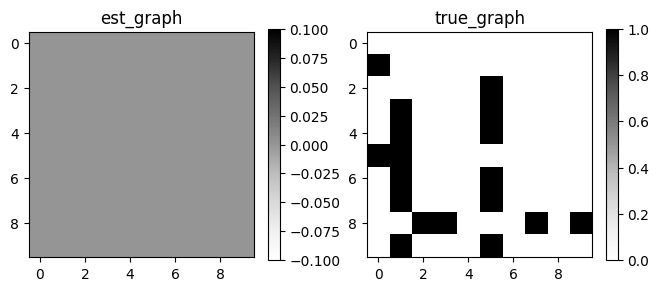

In [6]:
anm = ANMNonlinear(alpha=0.05)
anm.learn(data=A.values)

# plot predict_dag and true_dag
GraphDAG(anm.causal_matrix, B.values)

In [7]:
print(anm.causal_matrix)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### PNL

In [9]:
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation
from castle.algorithms import PNL

pc = PNL(alpha=0.05)
pc.learn(data=A.values)

# plot predict_dag and true_dag
GraphDAG(pc.causal_matrix, B.values)

# calculate accuracy
met = MetricsDAG(pc.causal_matrix, true_dag)
print(met.metrics)

2024-10-05 19:47:21,121 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\gradient\pnl\torch\pnl.py[line:135] - INFO: GPU is unavailable.


KeyboardInterrupt: 

### DAG-GNN

In [4]:
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation
from castle.algorithms import DAG_GNN

gnn = DAG_GNN()
gnn.learn(data=A.values)

2024-10-05 19:51:08,518 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\backend\__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2024-10-05 19:51:08,686 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.
2024-10-05 19:51:08,687 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:167] - INFO: GPU is unavailable.
2024-10-05 19:51:23,260 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 0, epoch: 299, h_new: 0.02953314489328207
2024-10-05 19:51:49,910 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 1, epoch: 299, h_new: 0.001417762793801458
2024-10-05 19:52:16,856 - d:\anaconda3\envs\adia_py311\Lib\site-packages\cas

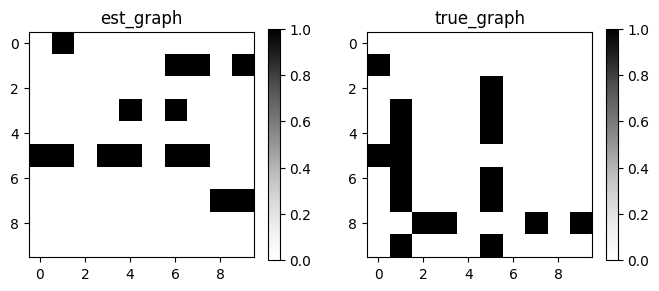

In [5]:
# plot predict_dag and true_dag
GraphDAG(gnn.causal_matrix, B.values)

### RL

In [9]:
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation
from castle.algorithms import RL

rl = RL(nb_epoch=2000)
rl.learn(data=A.values)

2024-10-05 20:15:04,462 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\gradient\rl\torch\rl.py[line:224] - INFO: GPU is unavailable.
2024-10-05 20:15:04,469 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\gradient\rl\torch\rl.py[line:264] - INFO: Python version is 3.11.9
2024-10-05 20:15:04,500 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\gradient\rl\torch\rl.py[line:289] - INFO: Original sl: 0.0733940238947109, su: 1.203971807325439, strue: -9.92660597610529
2024-10-05 20:15:04,501 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\gradient\rl\torch\rl.py[line:290] - INFO: Transfomed sl: 0.0733940238947109, su: 1.203971807325439, lambda2: 0.001, true: -44.225174714008126
2024-10-05 20:15:04,515 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\gradient\rl\torch\rl.py[line:334] - INFO: Finished creating training dataset and reward class
2024-10-05 20:15:04,516 - d:\anaconda3\envs\adia_py311\Li

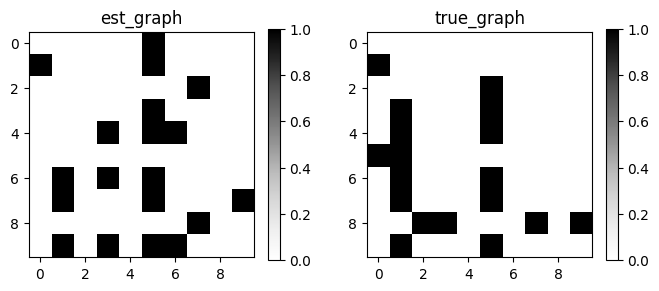

In [11]:
# plot predict_dag and true_dag
GraphDAG(rl.causal_matrix.T, B.values)

2024-10-05 20:24:32,021 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2024-10-05 20:24:32,023 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\gradient\rl\torch\rl.py[line:224] - INFO: GPU is unavailable.
2024-10-05 20:24:32,028 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\gradient\rl\torch\rl.py[line:264] - INFO: Python version is 3.11.9
2024-10-05 20:24:32,069 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\gradient\rl\torch\rl.py[line:289] - INFO: Original sl: 1.120185539844999, su: 5.838377459109804, strue: -8.879814460155002
2024-10-05 20:24:32,071 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\gradient\rl\torch\rl.py[line:290] - INFO: Transfomed sl: 1.120185539844999, su: 5.838377459109804, lambda2: 0.001, true: -10.597279817263361
2024-10-05 20:24:32,098 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\gradi

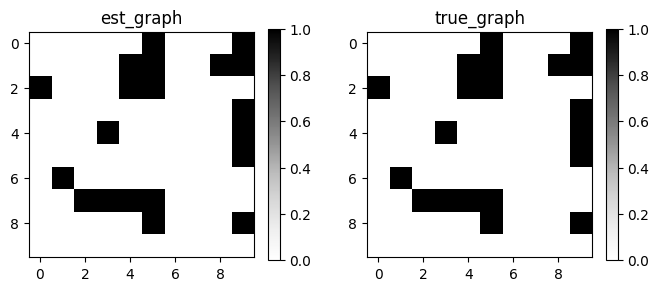

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 20, 'precision': 1.0, 'recall': 1.0, 'F1': 1.0, 'gscore': 1.0}


d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\metrics\evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\metrics\evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\metrics\evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


: 

In [12]:
# simulate data for rl
weighted_random_dag = DAG.erdos_renyi(n_nodes=10, n_edges=20, weight_range=(0.5, 2.0), seed=1)
dataset = IIDSimulation(W=weighted_random_dag, n=2000, method='linear', sem_type='gauss')
true_dag, X = dataset.B, dataset.X

# rl learn
rl = RL(nb_epoch=2000)
rl.learn(X)

# plot est_dag and true_dag
GraphDAG(rl.causal_matrix, true_dag)

# calculate accuracy
met = MetricsDAG(rl.causal_matrix, true_dag)
print(met.metrics)